Note: must turn off radar in settings before recording

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sat Jun 26 14:49:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    33W / 250W |  15977MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

#imports + file upload
print("need to prune imports")
#h+=1

%tensorflow_version 2.x

import os

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image

assert len(tf.config.list_physical_devices('GPU')) > 0

from google.colab import files
from skimage.color import rgb2gray
from collections import Counter
from random import shuffle
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt 
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
need to prune imports


In [6]:
#data processing

#next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)

def data_processing(start_val,num_files):
  
  s_turn = []
  m_turn = []
  adj_turn = []
  no_turn = []
  reverse = []
  """
  l_forward = []
  r_forward = []
  l_backward = []
  r_backward = []
  backward = []
  forward = []
  no_key = []
  w = [1,0,0,0,0,0,0,0,0]
  s = [0,1,0,0,0,0,0,0,0]
  a = [0,0,1,0,0,0,0,0,0]
  d = [0,0,0,1,0,0,0,0,0]
  wa = [0,0,0,0,1,0,0,0,0]
  wd = [0,0,0,0,0,1,0,0,0]
  sa = [0,0,0,0,0,0,1,0,0]
  sd = [0,0,0,0,0,0,0,1,0]
  nk = [0,0,0,0,0,0,0,0,1]
  """
  balanced_data = []
  starting_value = start_val
  continue_loop = True
  #start_time = time.time()
  #i=1
  while continue_loop:
    data_file_name = '/content/drive/MyDrive/GTA Driving Data/processed-training_data-{}.npy'.format(starting_value)
    if os.path.isfile(data_file_name) and starting_value < start_val + num_files:
      print(starting_value)
      starting_value += 1
      processed_data = np.load(data_file_name,allow_pickle=True)    
      #print(len(processed_data))
      #h+= 1
      #i = 0
      for entry in processed_data:
        #print(i)
        #i += 1
        #np_entry =print(entry[0])
        y = entry[0][0:3]
        y_ls = y[2]
        x= entry[1]
        #x = rgb2gray(entry[1])
        #flipping images
        y_flipped = [y[0],y[1],1-y_ls]
        x_flipped = cv2.flip(x, 1)
        keys_pressed = ""
        flipped_keys_pressed = ""
        #print(y_ls)
        
        if ((y_ls > 0.875 or y_ls < 0.125) and y[1] > 0.1):
          #very sharp turn, but it doesn't warrant its own array
          s_turn.append([x,y])
          s_turn.append([x_flipped,y_flipped])
        elif ((y_ls > 0.8 or y_ls < 0.2) and y[1] > 0.1):
          #sharp turn
          s_turn.append([x_flipped,y_flipped])
          s_turn.append([x,y])
        elif ((y_ls > 0.68 or y_ls < 0.32) and y[1] > 0.1):
          #medium turn
          m_turn.append([x,y])
          m_turn.append([x_flipped,y_flipped])
          #i+=1

        elif ((y_ls > 0.63 or y_ls < 0.37) and y[1] > 0.1):
          #light turn, doesn't warrant its own array
          adj_turn.append([x,y])
          adj_turn.append([x_flipped,y_flipped])
          #i+=1
        elif ((y_ls > 0.56 or y_ls < 0.34) and y[1] > 0.1):
          #light turn, doesn't warrant its own array
          adj_turn.append([x,y])
          adj_turn.append([x_flipped,y_flipped])
        elif y[1] > 0.1:
          no_turn.append([x,y])
          no_turn.append([x_flipped,y_flipped])
        elif y[0] > 0.1:
          reverse.append([x,y])
          reverse.append([x_flipped,y_flipped])
        
        """
        if (y_ls > 0.57):
          keys_pressed += "D"
          flipped_keys_pressed += "A"
        elif (y_ls < 0.43):
          keys_pressed += "A"
          flipped_keys_pressed += "D"
        if (y[1] > 0.1):
          keys_pressed += "W"
          flipped_keys_pressed += "W"
        elif (y[0] > 0.1):
          keys_pressed += "S"
          flipped_keys_pressed += "S"
        if keys_pressed == "DW":
          r_forward.append([x,wd])
          l_forward.append([x_flipped,wa])
        elif keys_pressed == "AW":
          l_forward.append([x,wa])
          r_forward.append([x_flipped,wd])
        elif keys_pressed == "DS":
          l_backward.append([x,sa])
          r_backward.append([x_flipped,sd])
        elif keys_pressed == "AS":
          r_backward.append([x,sd])
          l_backward.append([x_flipped,sa])
        elif keys_pressed == 'W':
          forward.append([x,w])
          forward.append([x_flipped,w])
        elif keys_pressed == 'S':
          backward.append([x,s])
          backward.append([x_flipped,s])
        elif keys_pressed == '':
          no_key.append([x,nk])
          no_key.append([x_flipped,nk])
        """
    else:
      if not (starting_value < start_val + num_files):
        continue_loop = False
      else:
        starting_value += 1

  #shuffle(no_turn)
  #without shuffling, array adjustment in next step would mean that the training set is full of mirror repeats 
  #we would prefer to have [img12_mirrored,img1] rather than [img1_mirrored, img1]
  #shuffling allows for this

  #balanced_data = s_turn[0:int(len(adj_turn)/3)] + m_turn + adj_turn[0:int(len(m_turn))] + no_turn[0:int(len(adj_turn)/3)]
  #we want agent to make small adjustments, so adj_turn isn't being adjusted
  #we don't want agent to just go straight, so less of no_turn is being added
  

  #balanced_length=max(len(l_backward),len(r_backward),len(backward))

  arr_lengths = [len(reverse),len(adj_turn),len(m_turn),len(s_turn),len(reverse)]
  #arr_lengths = [len(l_backward),balanced_length*1,len(r_backward),balanced_length*1.5,len(backward),balanced_length*1.5,balanced_length*1]
  arr_names = ["no turn (trimmed)","adjustment turn","medium turn", "sharp turn","reverse"]
  #arr_names = ["l_backward","l_forward","r_backward", "r_forward","backward","forward","no key"]
  plt.bar(arr_names,arr_lengths)
  plt.show()
  
  
  balanced_data = no_turn[0:len(reverse)] + adj_turn + m_turn + s_turn + reverse
  
  no_turn = []
  s_turn = []
  m_turn = []
  adj_turn = []
  reverse = []
  #print(i)
  #[0:int(balanced_length*1.5)] + backward + forward[0:int(balanced_length*1.5)]+no_key[0:balanced_length*1]
  shuffle(balanced_data)
  X = []
  Y = []
  for entry in balanced_data:
    entry[0] = rgb2gray(entry[0])
    #entry[0] = np.expand_dims(rgb2gray(entry[0]), axis=0)



  X , Y = zip(*balanced_data)

  print("done! have {} test cases".format(len(balanced_data)))
  #print("time to run time: {}".format(time.time()-start_time))
  balanced_data = []

  X_train_3dim = tf.convert_to_tensor(X)
  new_shape = list(X_train_3dim.shape) + [1]
  X_train = tf.reshape(X_train_3dim,new_shape)

  Y_train_3dim = tf.convert_to_tensor(Y)
  print(Y_train_3dim.shape)
  new_shape = list(Y_train_3dim.shape) + [1]
  Y_train = tf.transpose(tf.reshape(Y_train_3dim,new_shape),perm = [0,2,1])
  print(Y_train.shape)
  return X_train,Y_train

1
2
3
4
5
6
7
8
9
10


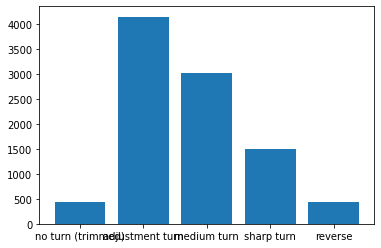

done! have 9502 test cases
(9502, 3)
(9502, 1, 3)


In [7]:
X_train, Y_train = data_processing(1,10)

In [19]:
#saving chunk of training data as testing data (now irrelevant)

#PERCENT_TEST = 20

#test_index_start = int(PERCENT_TEST*len(balanced_data)/100)
#train_data = balanced_data[:-test_index_start]
#test_data = balanced_data[-test_index_start:]

-------------STARTING EPOCH 1-------------
0
1
2
3
4
5
6
7
8
9


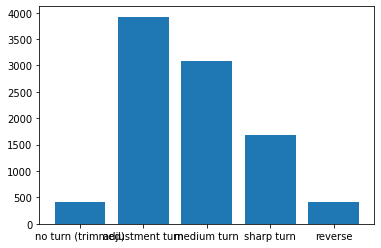

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 35s 9ms/step - loss: 0.3596 - accuracy: 0.5806
10
11
12
13
14
15
16
17
18
19


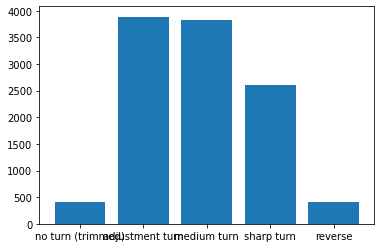

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 9ms/step - loss: 0.0573 - accuracy: 0.6858
20
21
22
23
24
25
26
27
28
29


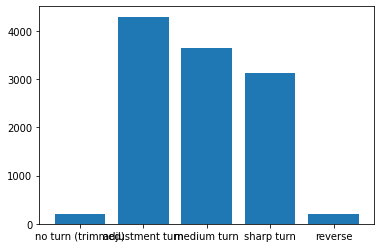

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 9ms/step - loss: 0.0514 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


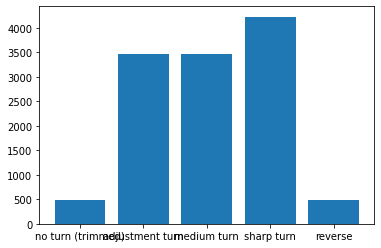

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 9ms/step - loss: 0.0665 - accuracy: 0.6020
40
42
43
44
45
46
47
48
49


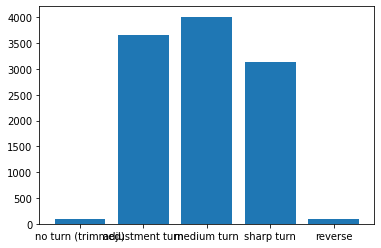

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 9ms/step - loss: 0.0515 - accuracy: 0.7358
50
51
52
53
56
57
58
59


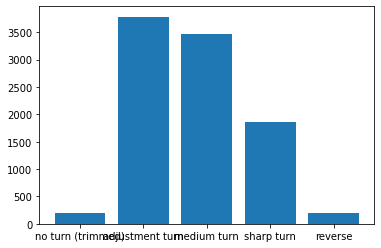

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0476 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


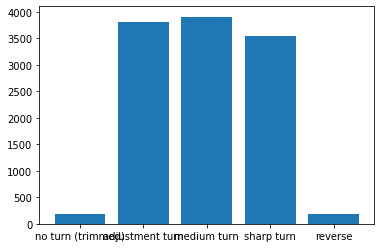

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 9ms/step - loss: 0.0528 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


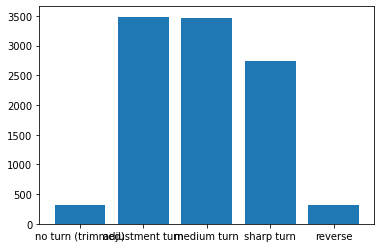

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0607 - accuracy: 0.6537
80
81
82
83
84
85
86
87
88
89


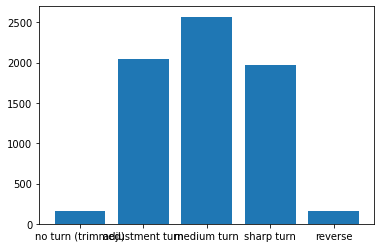

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 9ms/step - loss: 0.0629 - accuracy: 0.6975
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


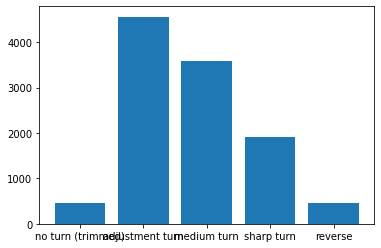

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 8ms/step - loss: 0.0587 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


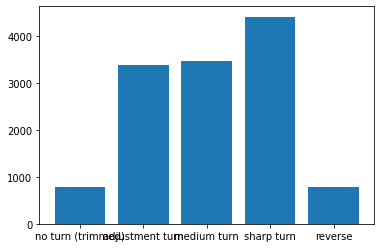

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 9ms/step - loss: 0.0787 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


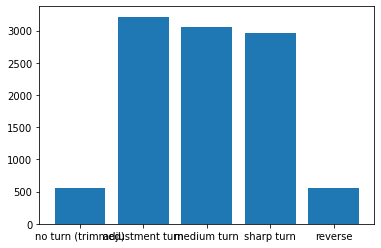

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0697 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


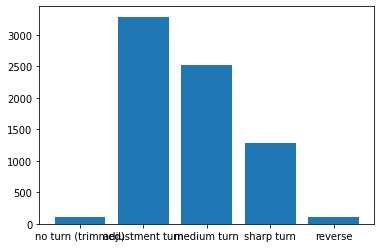

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 9ms/step - loss: 0.0452 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


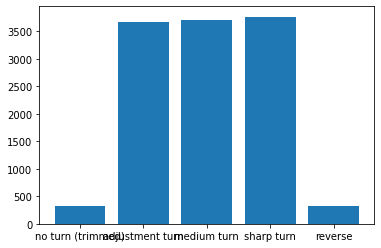

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 5ms/step - loss: 0.0640 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 2-------------
0
1
2
3
4
5
6
7
8
9


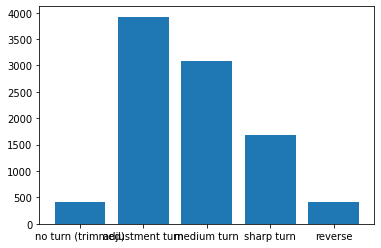

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0503 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


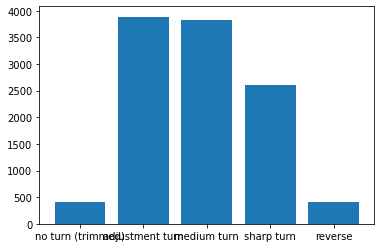

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 9ms/step - loss: 0.0564 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


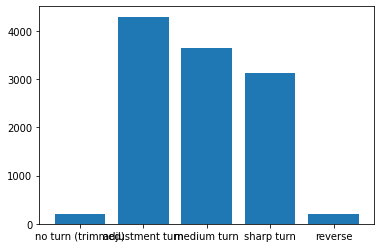

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 9ms/step - loss: 0.0511 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


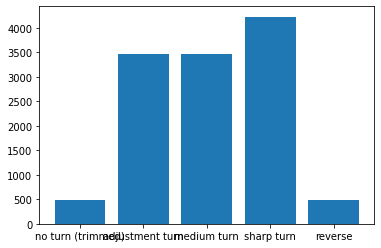

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 3s 9ms/step - loss: 0.0663 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


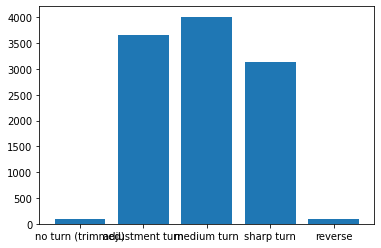

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 9ms/step - loss: 0.0512 - accuracy: 0.7359
50
51
52
53
56
57
58
59


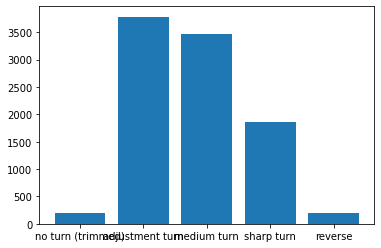

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0474 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


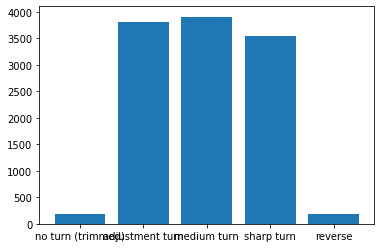

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 9ms/step - loss: 0.0526 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


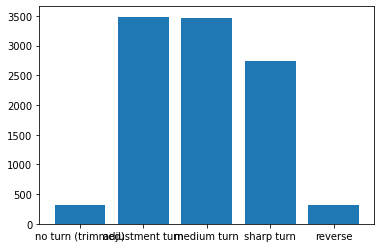

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0603 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


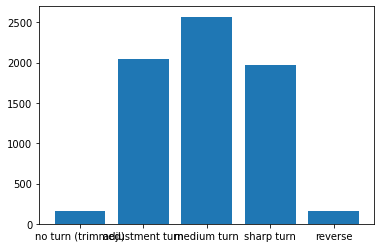

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 9ms/step - loss: 0.0627 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


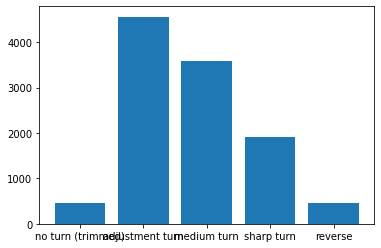

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 9ms/step - loss: 7456.3691 - accuracy: 0.3807
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


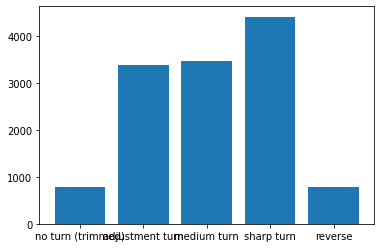

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 9ms/step - loss: 0.0915 - accuracy: 0.2978
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


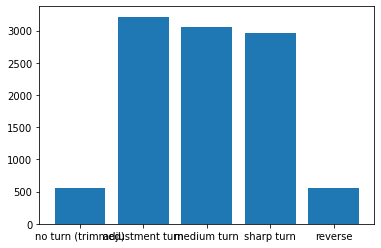

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0832 - accuracy: 0.2751
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


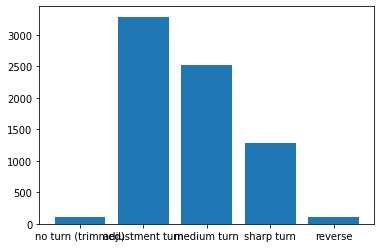

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 9ms/step - loss: 0.0640 - accuracy: 0.2408
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


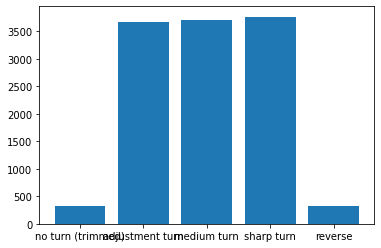

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 5ms/step - loss: 0.0810 - accuracy: 0.2532
Test accuracy: 0.2532295286655426
-------------STARTING EPOCH 3-------------
0
1
2
3
4
5
6
7
8
9


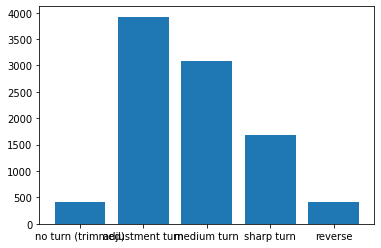

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0604 - accuracy: 0.3111
10
11
12
13
14
15
16
17
18
19


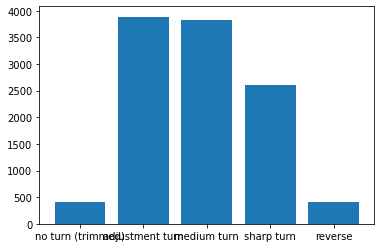

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 9ms/step - loss: 0.0701 - accuracy: 0.2785
20
21
22
23
24
25
26
27
28
29


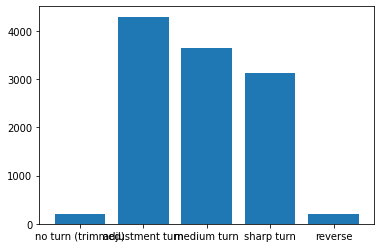

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 9ms/step - loss: 0.0710 - accuracy: 0.2250
30
31
32
33
34
35
36
37
38
39


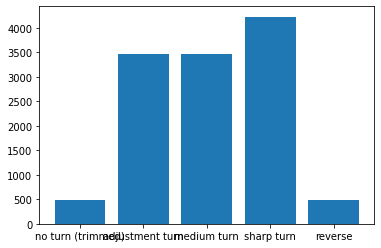

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 3s 9ms/step - loss: 0.0740 - accuracy: 0.3605
40
42
43
44
45
46
47
48
49


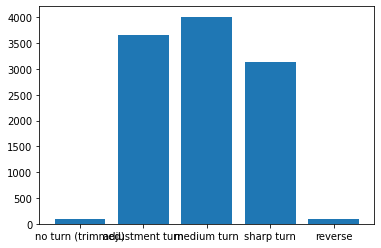

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 9ms/step - loss: 0.0676 - accuracy: 0.2453
50
51
52
53
56
57
58
59


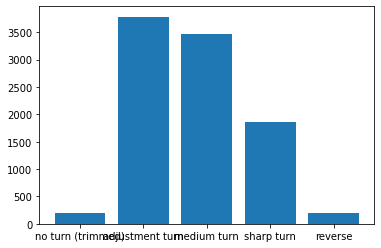

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0724 - accuracy: 0.1456
60
61
62
63
64
65
66
67
68
69


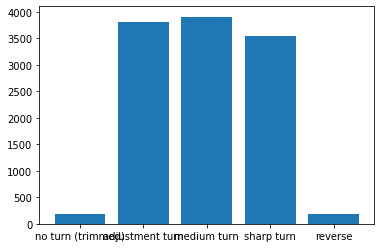

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 9ms/step - loss: 0.0624 - accuracy: 0.2914
70
71
72
73
74
75
76
77
78
79


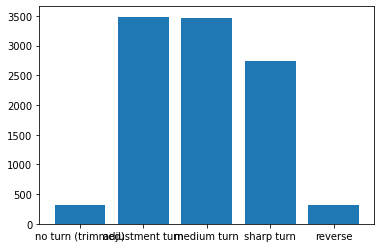

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0682 - accuracy: 0.3035
80
81
82
83
84
85
86
87
88
89


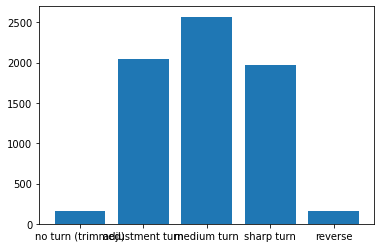

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 9ms/step - loss: 0.0712 - accuracy: 0.2592
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


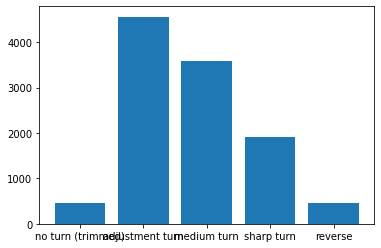

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 9ms/step - loss: 0.0665 - accuracy: 0.2628
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


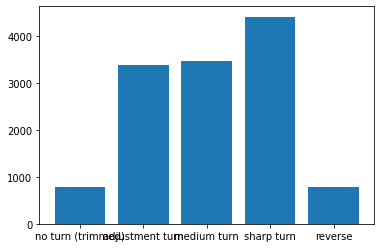

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 9ms/step - loss: 0.0841 - accuracy: 0.2979
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


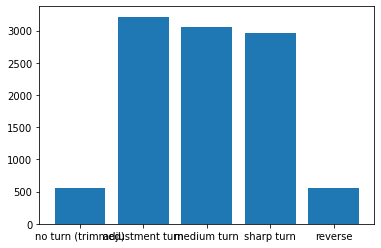

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0746 - accuracy: 0.4073
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


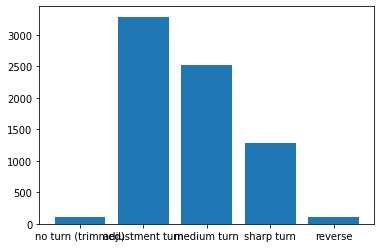

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 9ms/step - loss: 0.0531 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


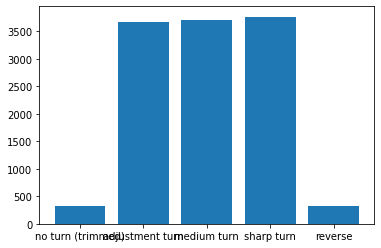

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 5ms/step - loss: 0.0702 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 4-------------
0
1
2
3
4
5
6
7
8
9


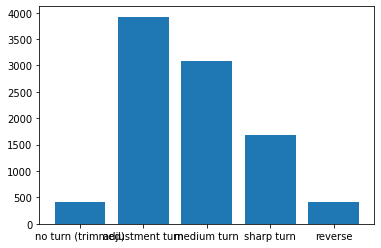

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0526 - accuracy: 0.6442
10
11
12
13
14
15
16
17
18
19


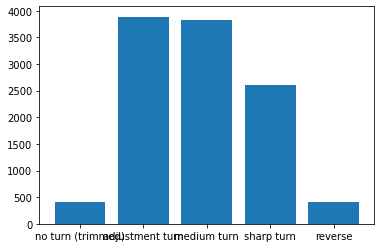

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 9ms/step - loss: 0.0596 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


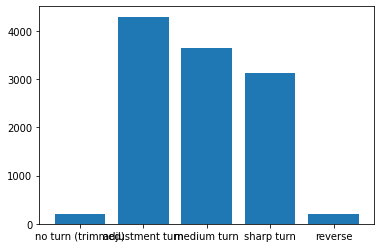

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 9ms/step - loss: 0.0570 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


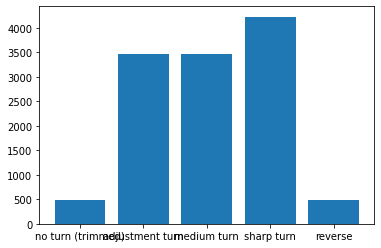

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 3s 9ms/step - loss: 0.0671 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


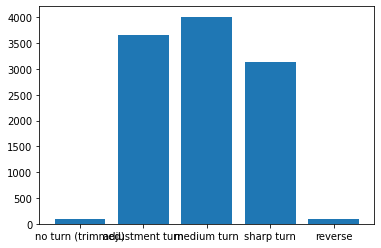

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 9ms/step - loss: 0.0542 - accuracy: 0.7359
50
51
52
53
56
57
58
59


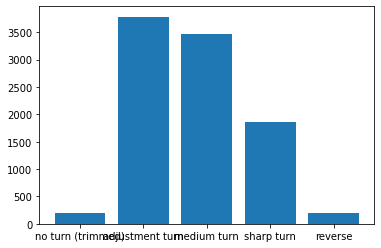

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0537 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


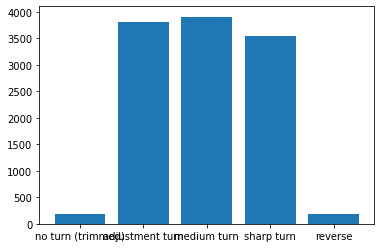

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 9ms/step - loss: 0.0523 - accuracy: 0.6797
70
71
72
73
74
75
76
77
78
79


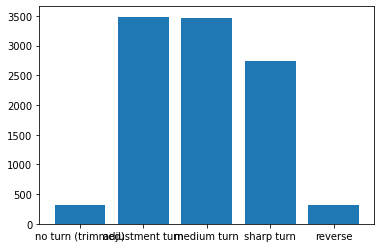

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0603 - accuracy: 0.6540
80
81
82
83
84
85
86
87
88
89


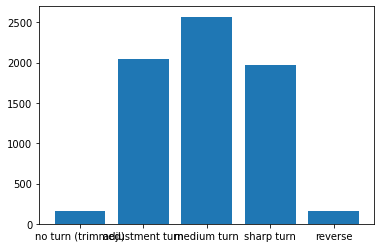

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 9ms/step - loss: 0.0624 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


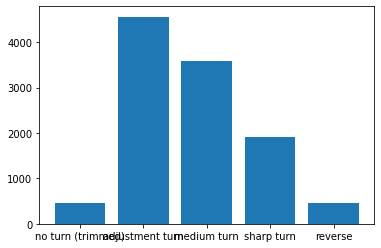

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 9ms/step - loss: 0.0583 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


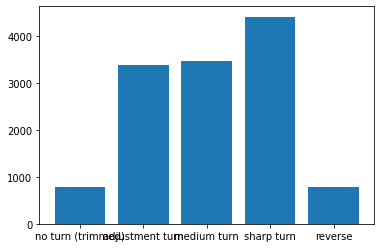

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 9ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


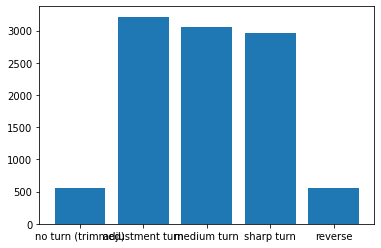

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0692 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


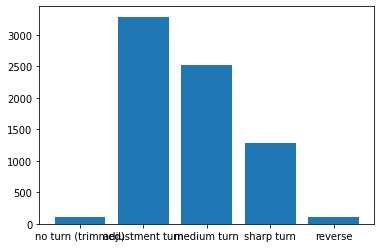

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0462 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


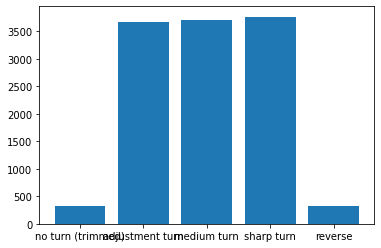

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 5-------------
0
1
2
3
4
5
6
7
8
9


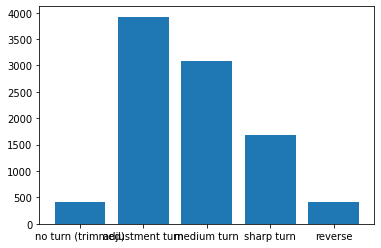

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0507 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


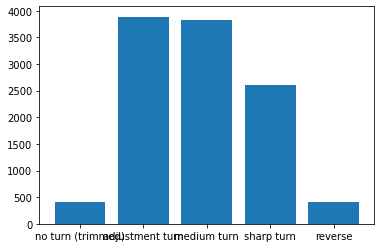

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 9ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


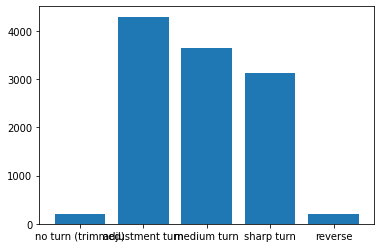

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 9ms/step - loss: 0.0513 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


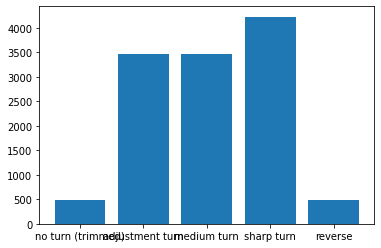

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 3s 9ms/step - loss: 0.0676 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


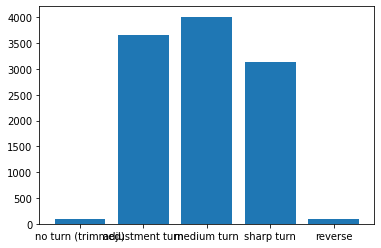

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 10ms/step - loss: 0.0521 - accuracy: 0.7358
50
51
52
53
56
57
58
59


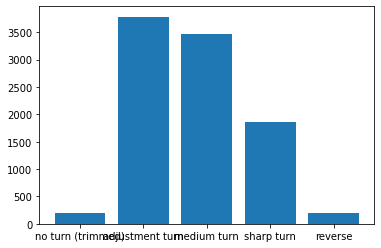

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0478 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


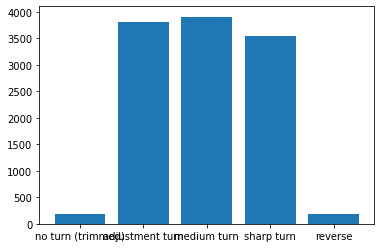

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 9ms/step - loss: 0.0530 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


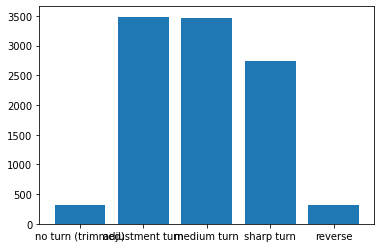

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0601 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


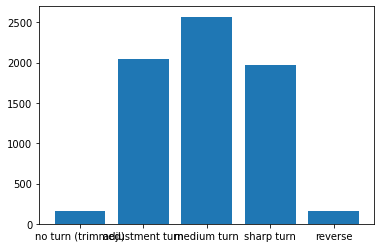

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 9ms/step - loss: 0.0623 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


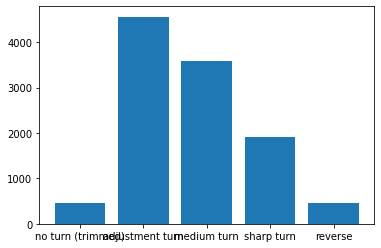

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 9ms/step - loss: 0.0580 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


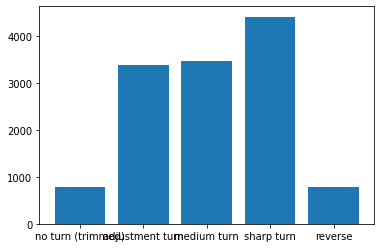

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0781 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


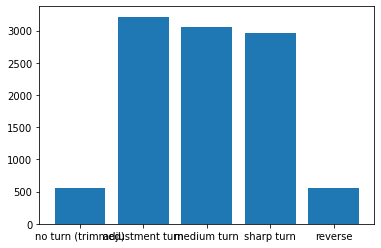

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 9ms/step - loss: 0.0692 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


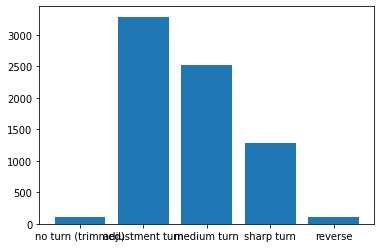

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0452 - accuracy: 0.7444
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


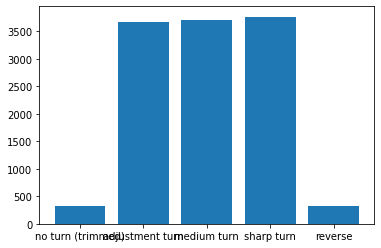

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 6-------------
0
1
2
3
4
5
6
7
8
9


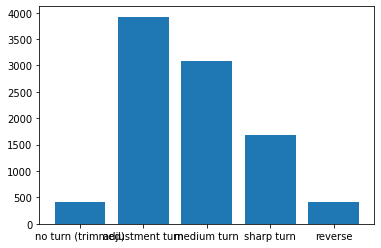

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0504 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


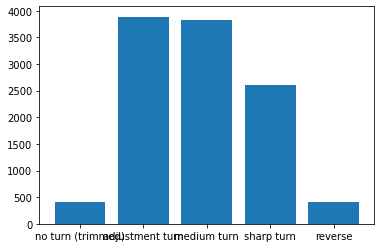

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 10ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


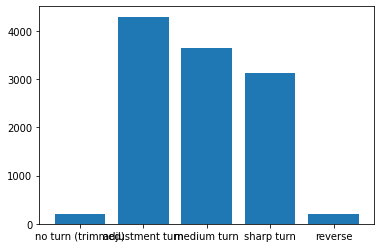

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 10ms/step - loss: 0.0507 - accuracy: 0.7547
30
31
32
33
34
35
36
37
38
39


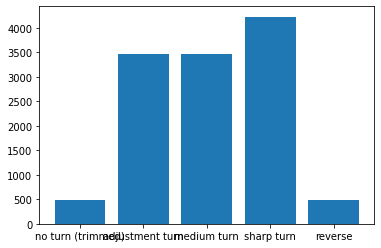

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 9ms/step - loss: 0.0664 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


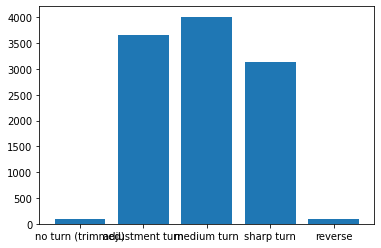

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 10ms/step - loss: 0.0514 - accuracy: 0.7360
50
51
52
53
56
57
58
59


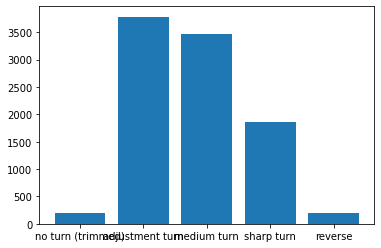

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


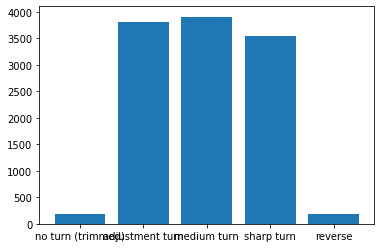

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 10ms/step - loss: 0.0525 - accuracy: 0.6795
70
71
72
73
74
75
76
77
78
79


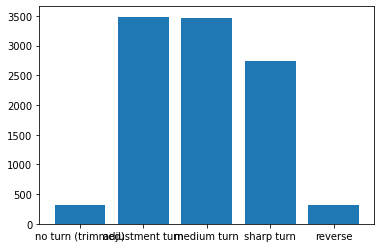

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0601 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


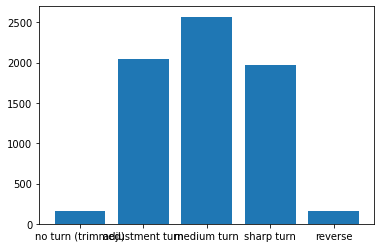

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0623 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


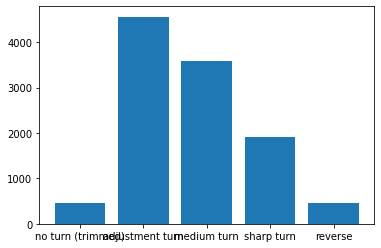

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 10ms/step - loss: 0.0580 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


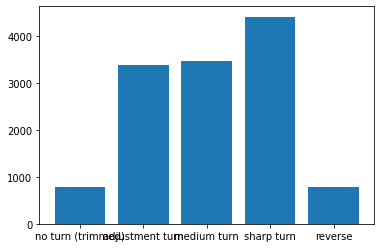

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0781 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


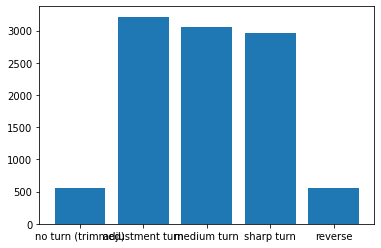

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0692 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


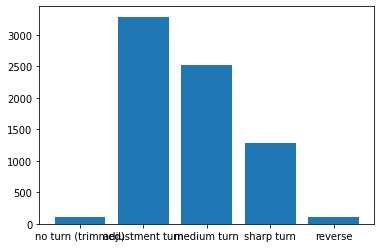

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


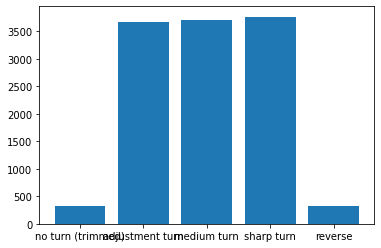

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 7-------------
0
1
2
3
4
5
6
7
8
9


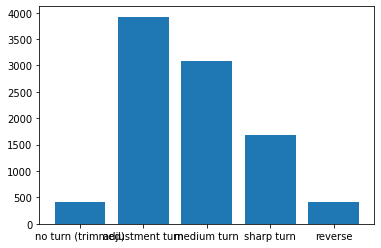

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


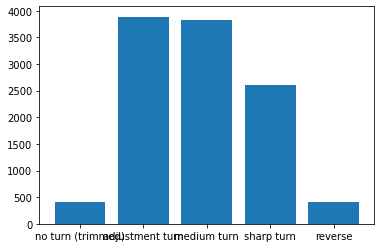

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 10ms/step - loss: 0.0559 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


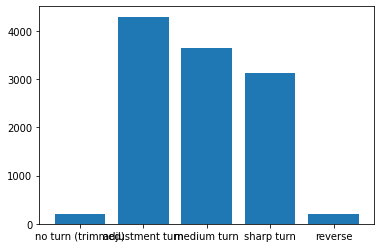

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 3s 10ms/step - loss: 0.0507 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


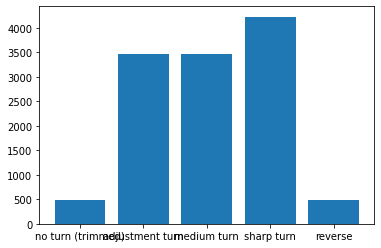

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 9ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


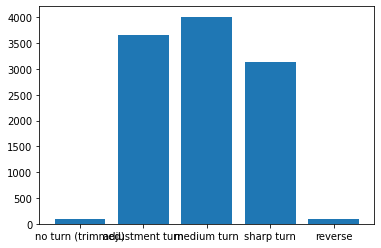

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 10ms/step - loss: 0.0511 - accuracy: 0.7358
50
51
52
53
56
57
58
59


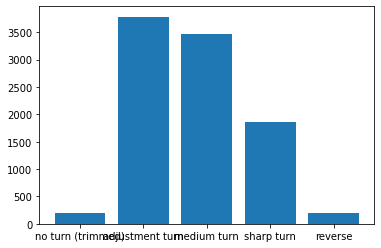

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


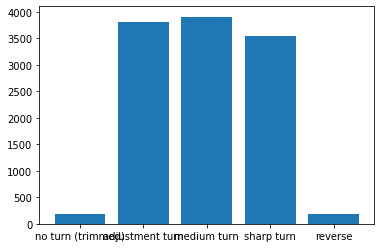

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 10ms/step - loss: 0.0524 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


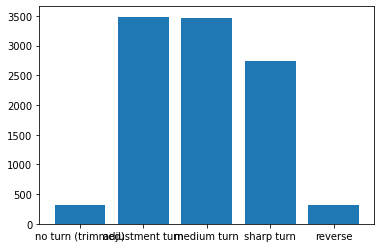

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0601 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


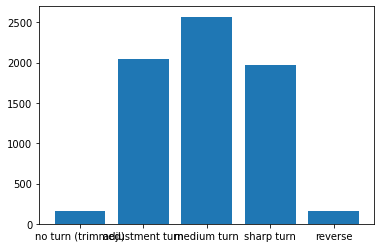

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0623 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


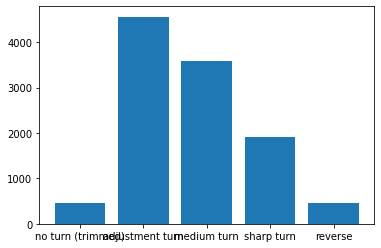

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 10ms/step - loss: 0.0580 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


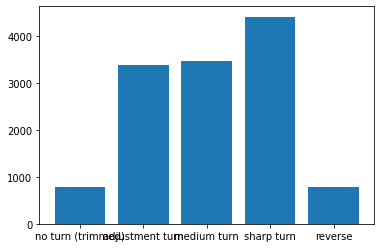

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0781 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


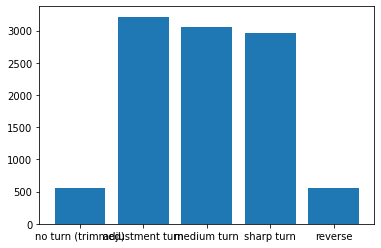

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0692 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


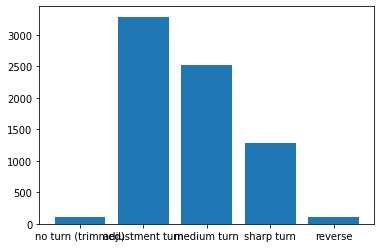

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0449 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


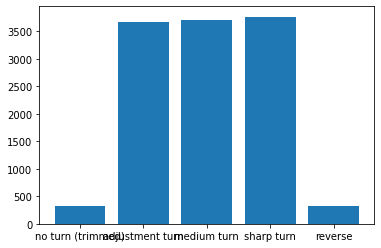

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 8-------------
0
1
2
3
4
5
6
7
8
9


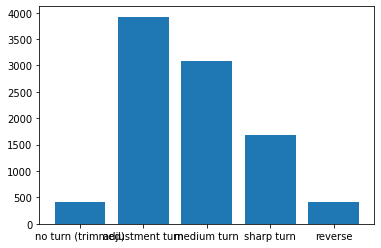

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 9ms/step - loss: 0.0501 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


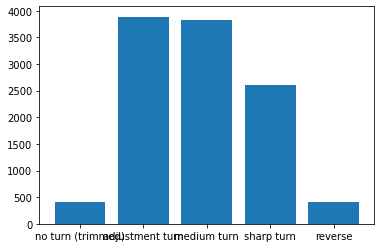

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 10ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


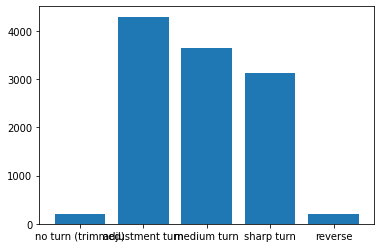

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0507 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


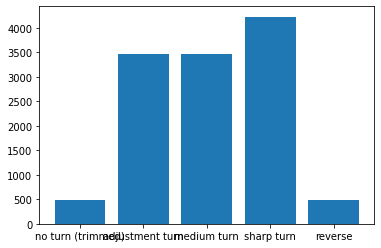

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


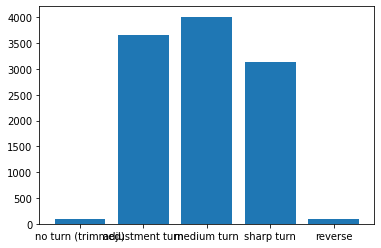

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 10ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


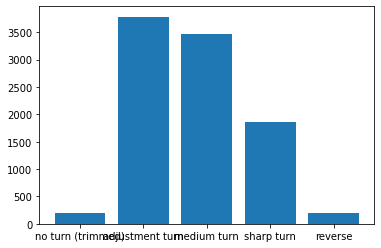

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


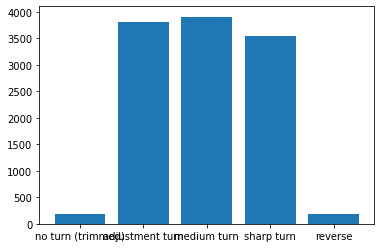

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 3s 10ms/step - loss: 0.0523 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


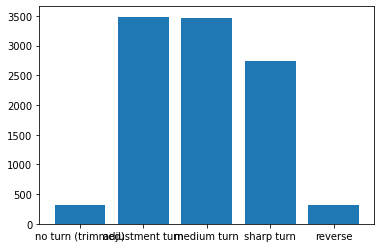

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0601 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


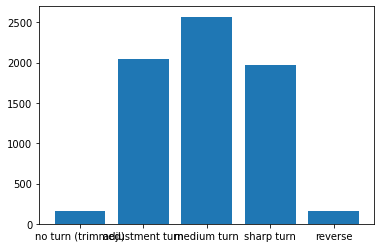

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0624 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


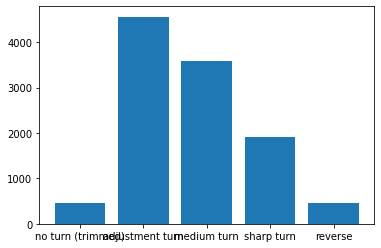

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 10ms/step - loss: 0.0581 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


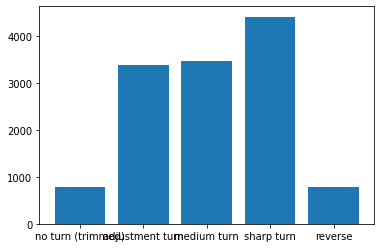

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0782 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


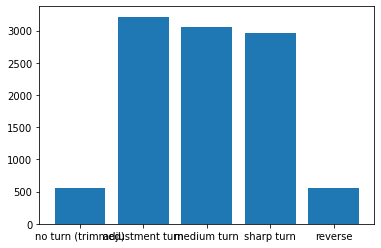

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0693 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


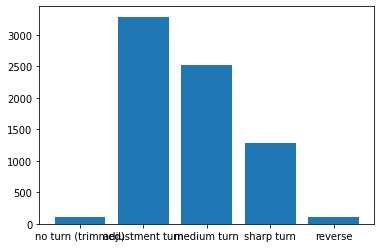

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


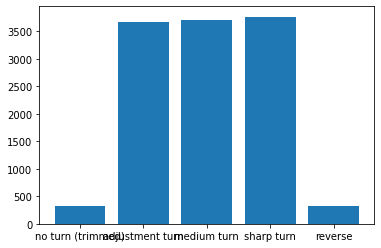

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 9-------------
0
1
2
3
4
5
6
7
8
9


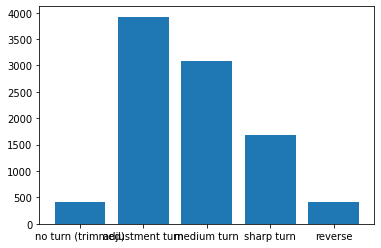

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0501 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


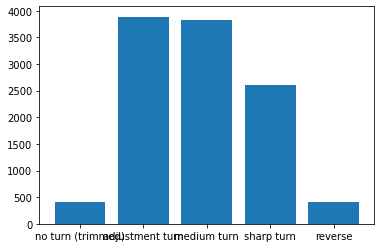

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 3s 10ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


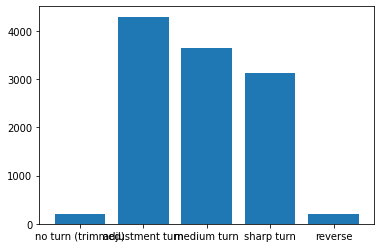

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0507 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


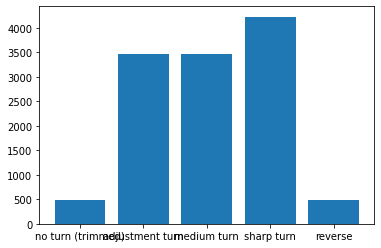

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


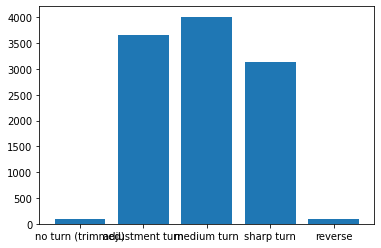

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 10ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


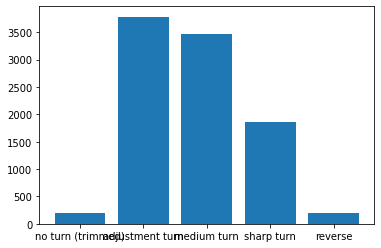

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


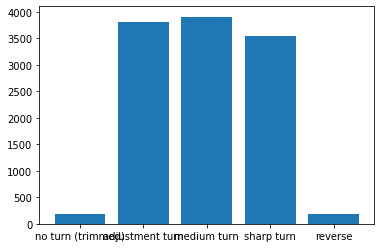

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


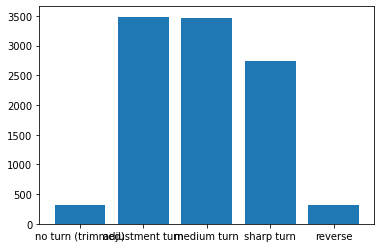

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


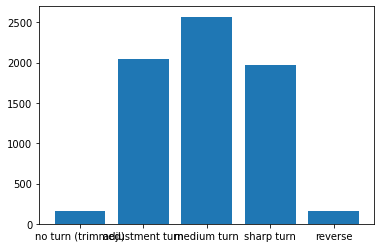

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


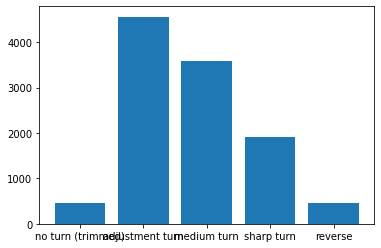

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 3s 10ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


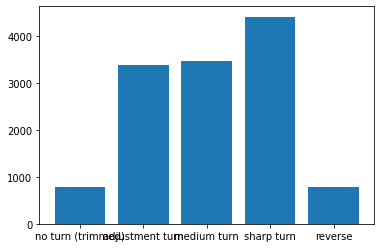

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0783 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


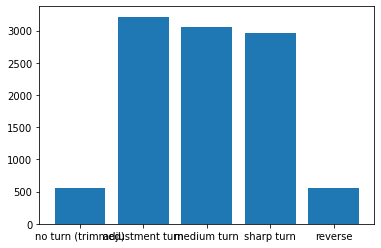

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


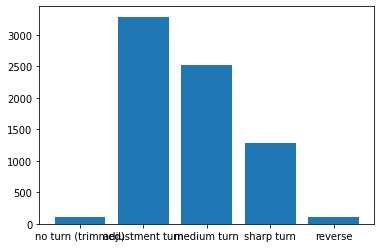

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0450 - accuracy: 0.7440
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


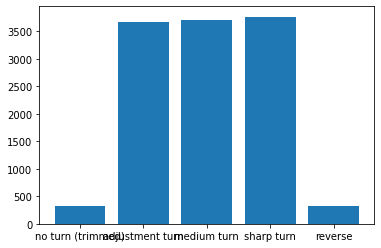

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 10-------------
0
1
2
3
4
5
6
7
8
9


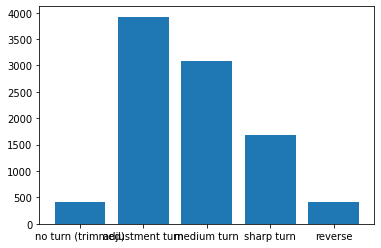

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6446
10
11
12
13
14
15
16
17
18
19


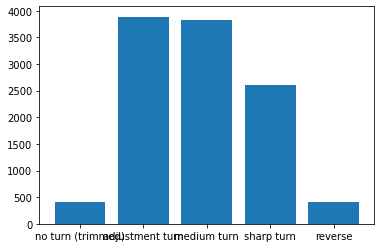

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 10ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


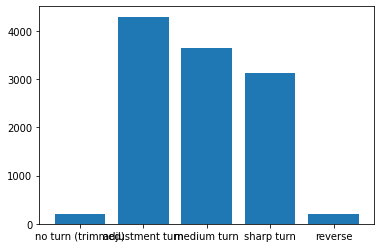

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


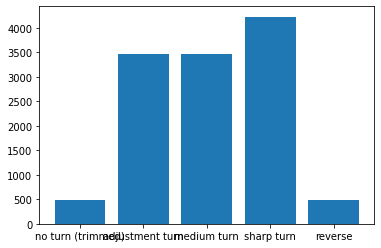

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0662 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


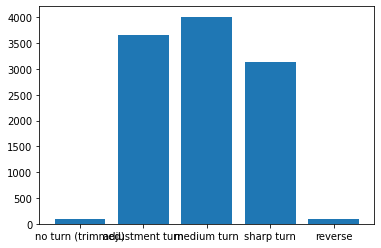

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 3s 10ms/step - loss: 0.0511 - accuracy: 0.7360
50
51
52
53
56
57
58
59


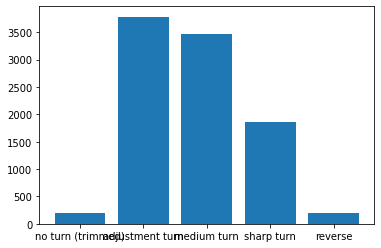

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


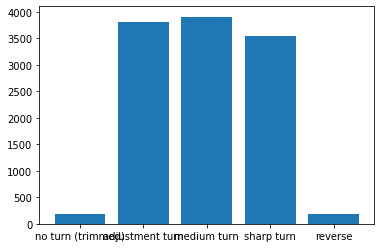

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0525 - accuracy: 0.6797
70
71
72
73
74
75
76
77
78
79


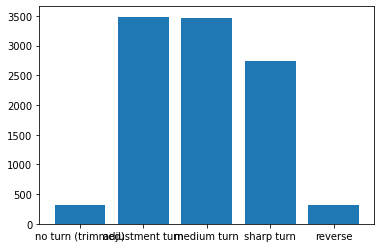

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


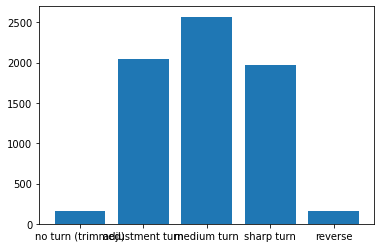

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0626 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


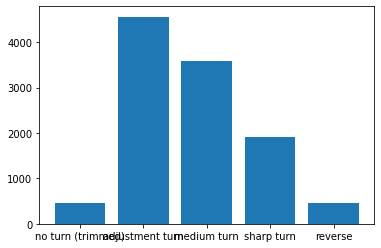

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 10ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


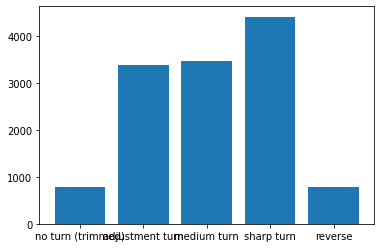

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


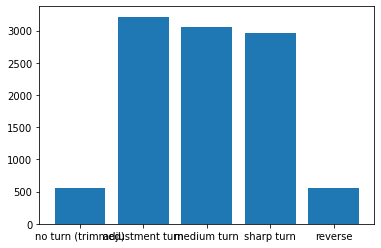

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


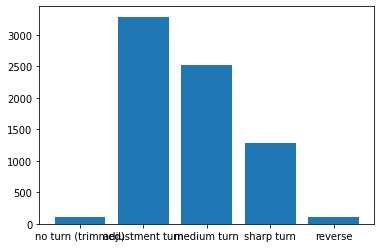

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


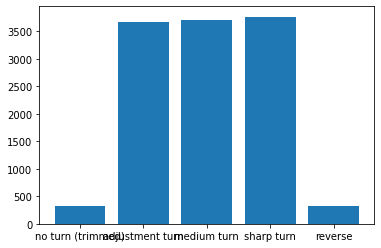

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 11-------------
0
1
2
3
4
5
6
7
8
9


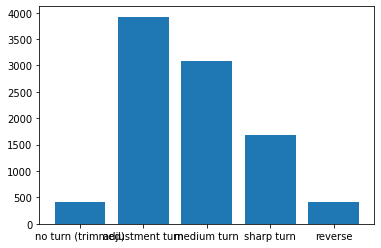

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


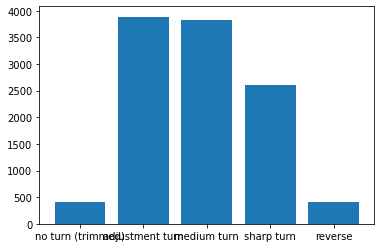

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 10ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


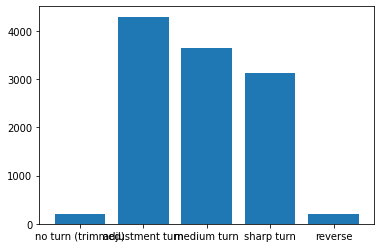

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


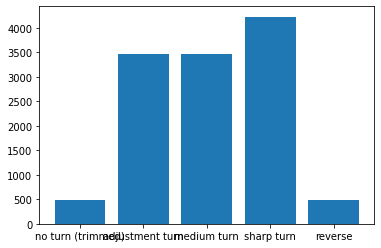

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0659 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


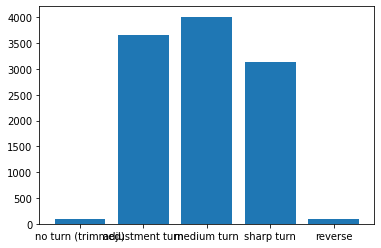

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 10ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


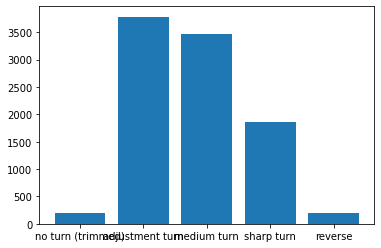

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


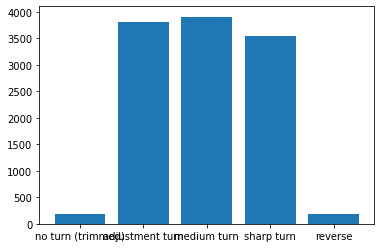

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0525 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


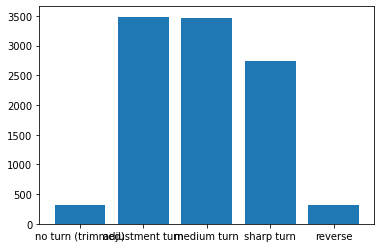

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0602 - accuracy: 0.6540
80
81
82
83
84
85
86
87
88
89


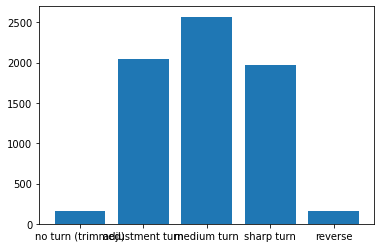

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0626 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


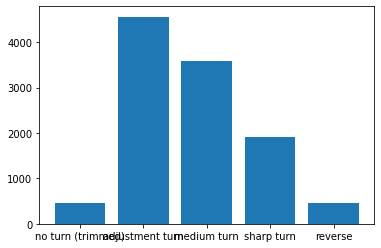

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 10ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


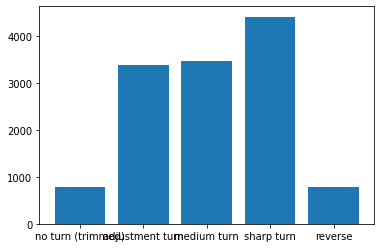

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


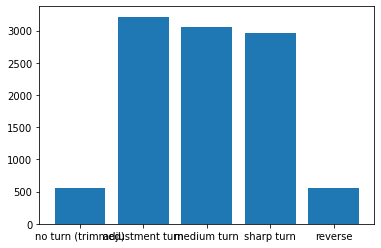

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


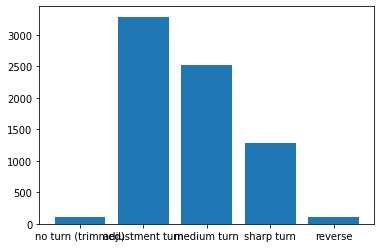

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


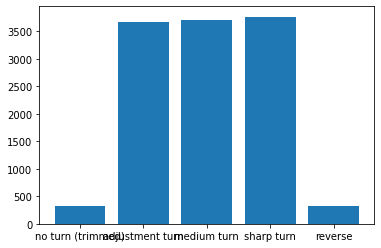

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 12-------------
0
1
2
3
4
5
6
7
8
9


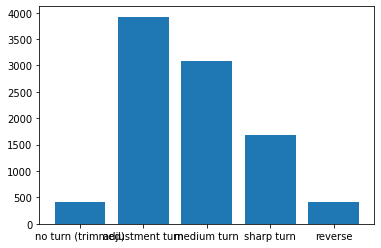

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0501 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


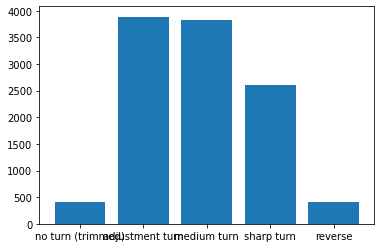

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 10ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


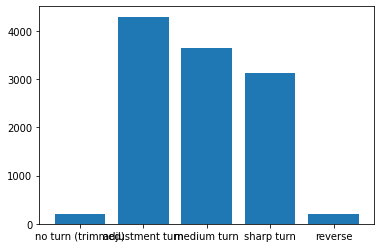

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


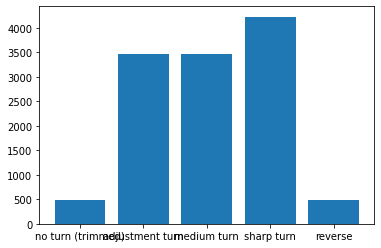

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0662 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


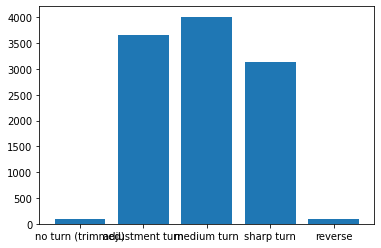

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 10ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


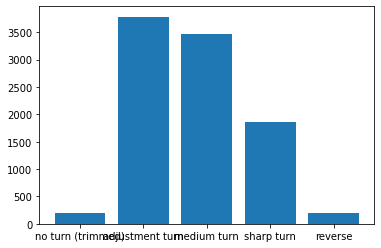

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


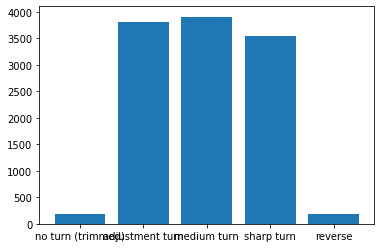

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0524 - accuracy: 0.6797
70
71
72
73
74
75
76
77
78
79


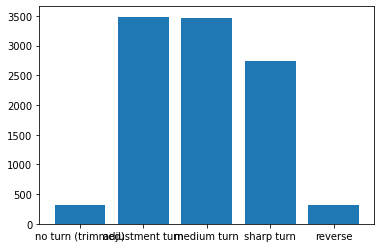

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


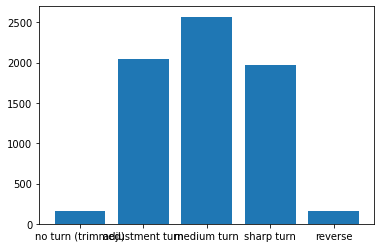

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


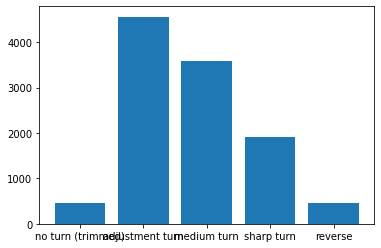

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 10ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


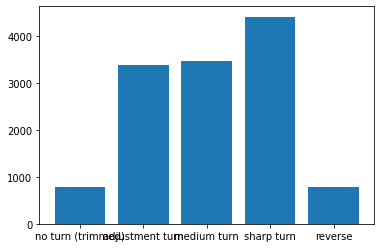

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0783 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


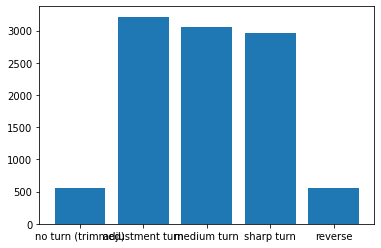

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


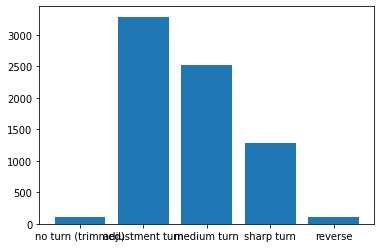

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0450 - accuracy: 0.7440
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


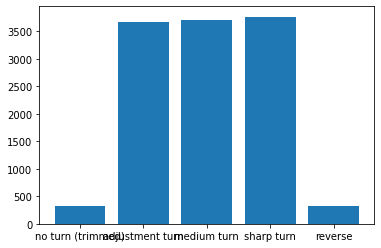

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 13-------------
0
1
2
3
4
5
6
7
8
9


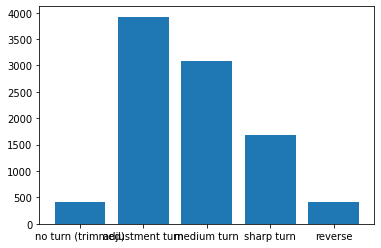

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


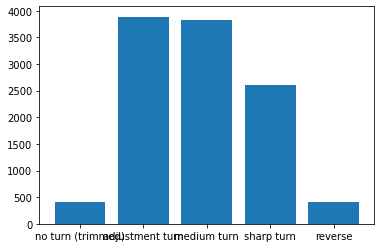

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 10ms/step - loss: 0.0560 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


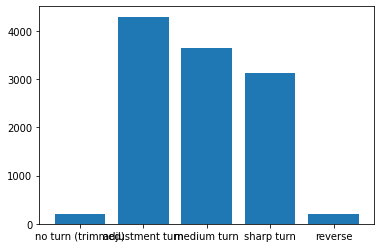

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


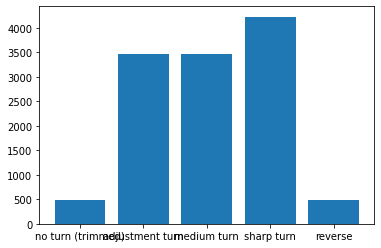

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


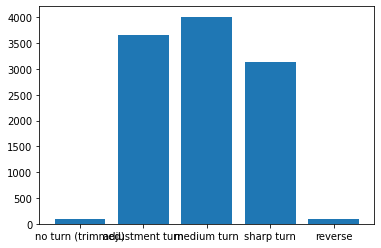

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 10ms/step - loss: 0.0511 - accuracy: 0.7360
50
51
52
53
56
57
58
59


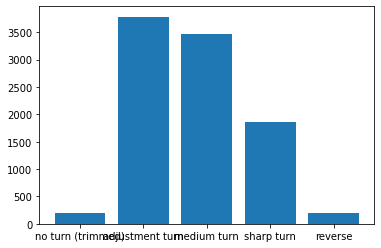

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


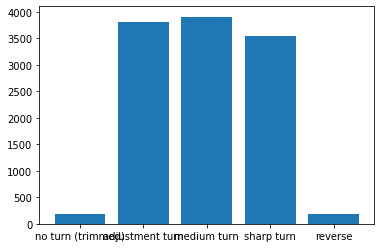

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0525 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


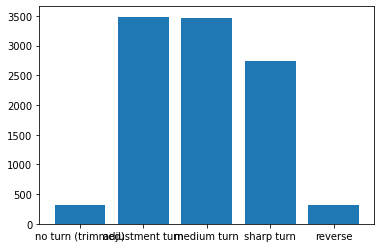

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


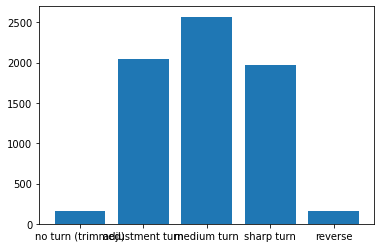

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


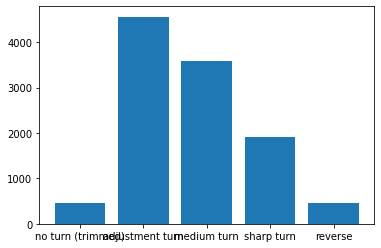

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 10ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


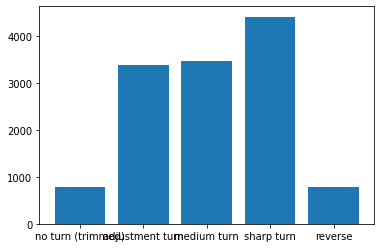

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


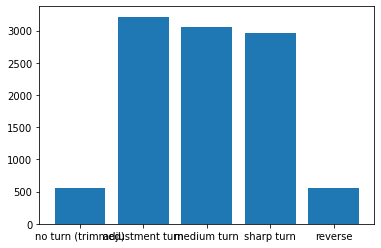

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


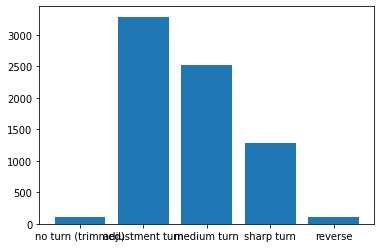

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


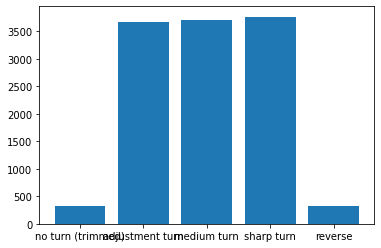

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0645 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 14-------------
0
1
2
3
4
5
6
7
8
9


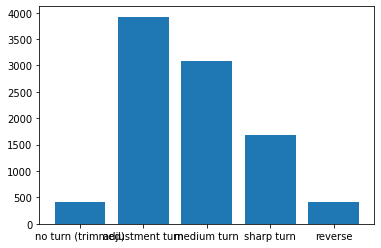

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6446
10
11
12
13
14
15
16
17
18
19


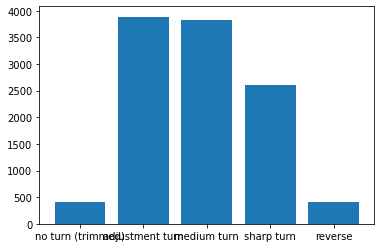

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 10ms/step - loss: 0.0561 - accuracy: 0.6875
20
21
22
23
24
25
26
27
28
29


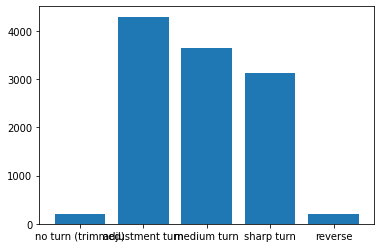

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


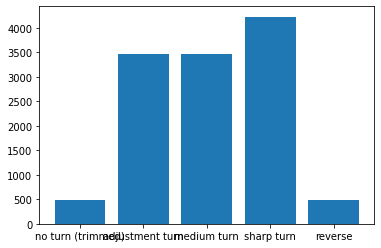

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


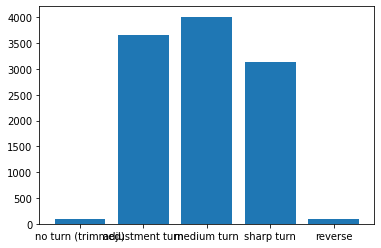

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


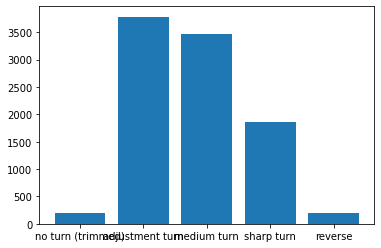

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


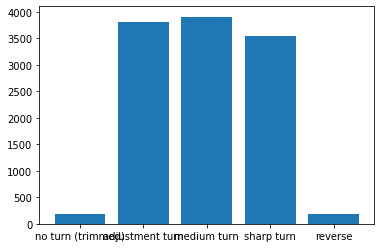

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0524 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


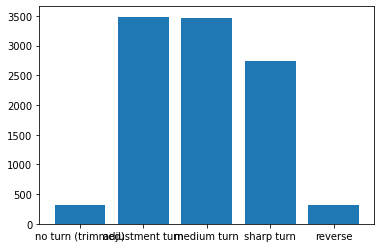

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


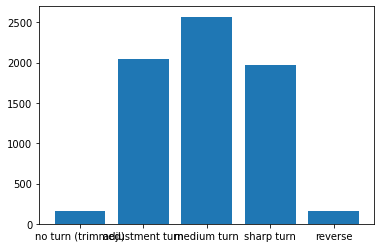

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6972
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


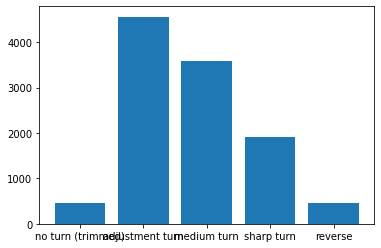

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 10ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


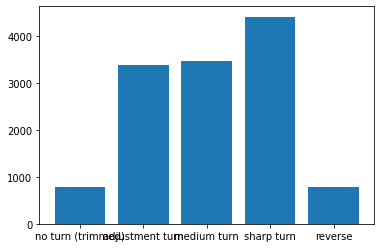

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 10ms/step - loss: 0.0784 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


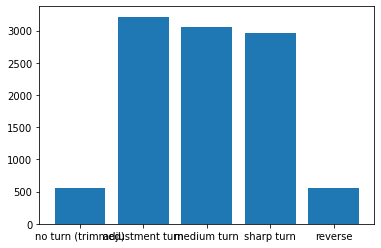

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6759
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


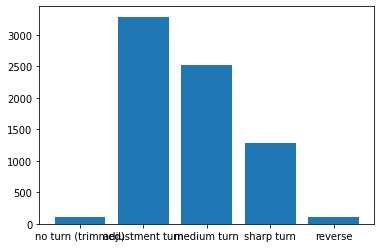

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


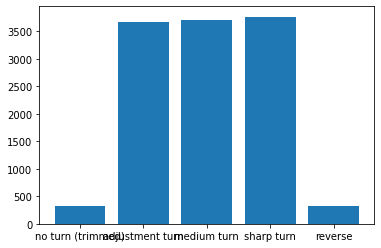

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0638 - accuracy: 0.7181
Test accuracy: 0.7181479334831238
-------------STARTING EPOCH 15-------------
0
1
2
3
4
5
6
7
8
9


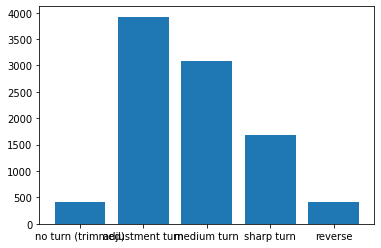

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


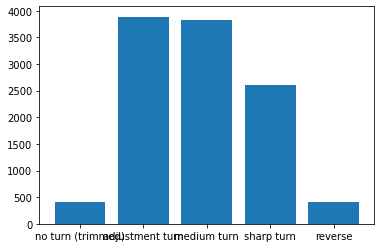

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 10ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


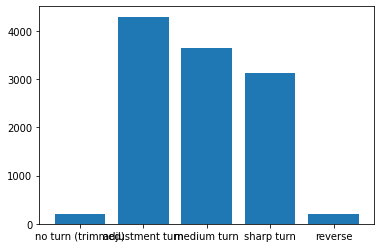

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7550
30
31
32
33
34
35
36
37
38
39


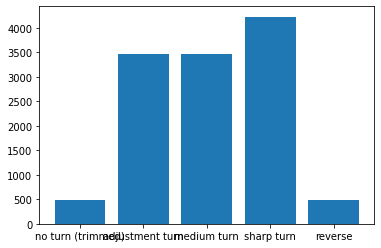

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0662 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


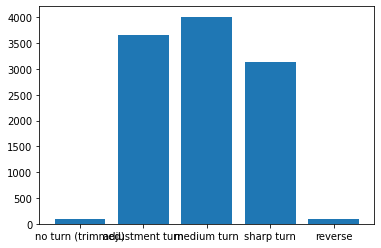

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 10ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


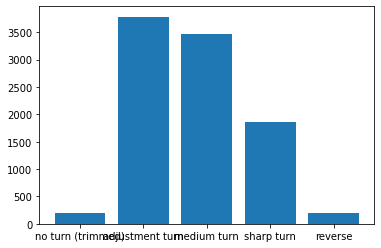

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


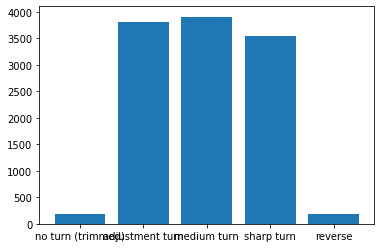

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


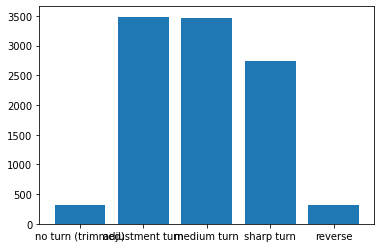

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


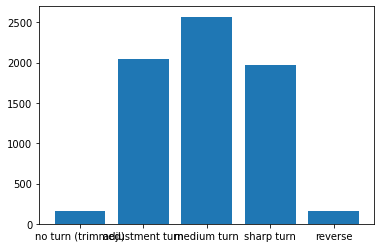

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


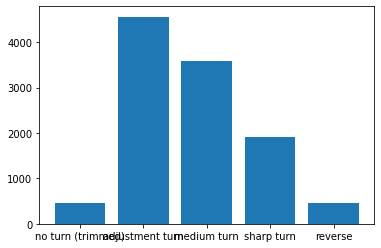

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


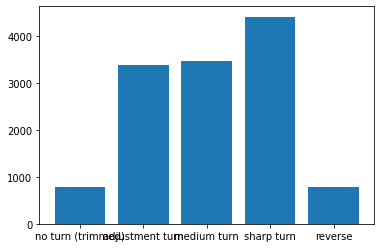

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


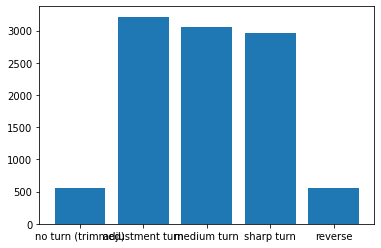

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


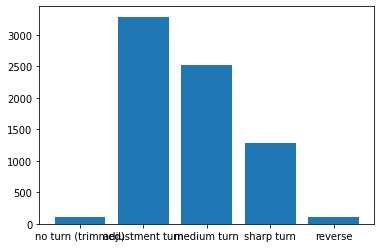

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0452 - accuracy: 0.7439
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


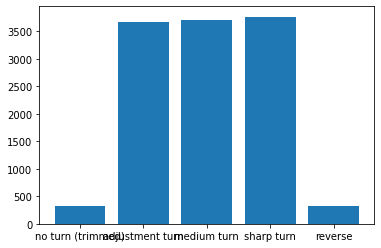

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0645 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 16-------------
0
1
2
3
4
5
6
7
8
9


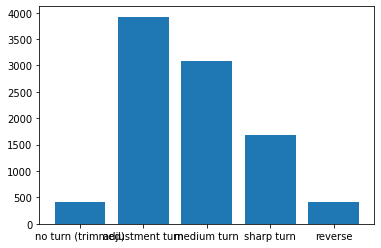

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


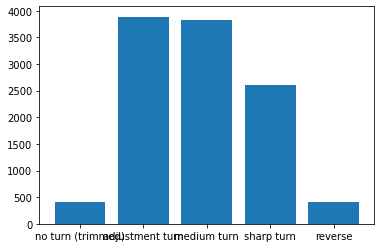

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


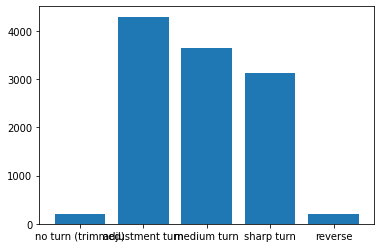

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


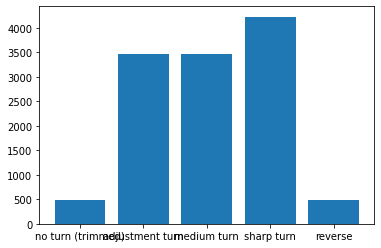

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


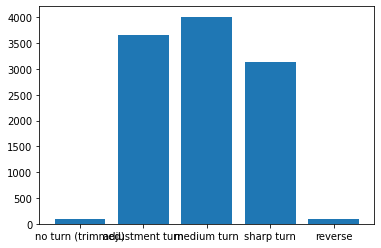

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7360
50
51
52
53
56
57
58
59


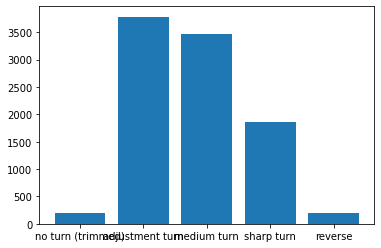

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


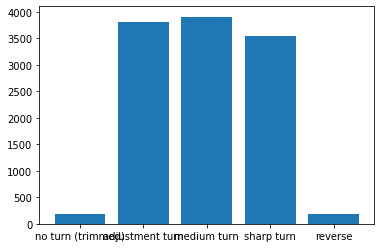

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6797
70
71
72
73
74
75
76
77
78
79


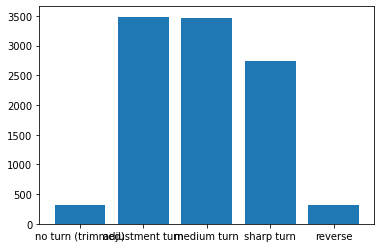

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0603 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


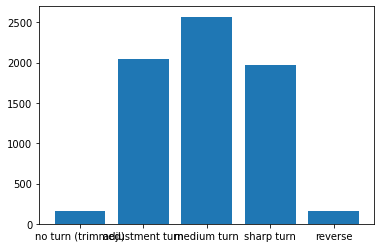

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


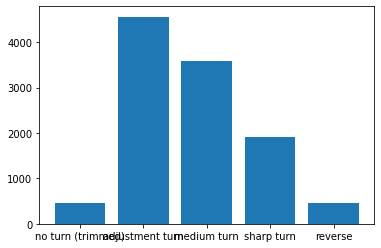

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0581 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


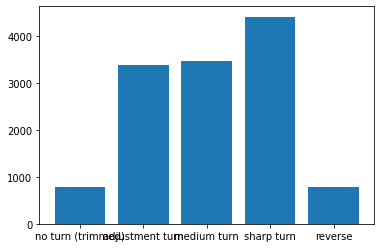

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


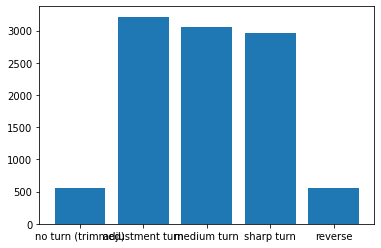

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6755
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


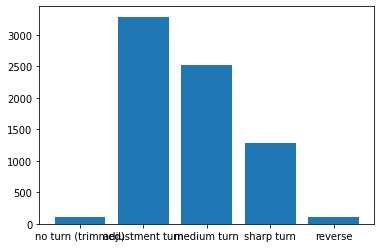

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


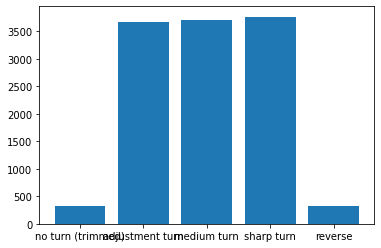

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0637 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 17-------------
0
1
2
3
4
5
6
7
8
9


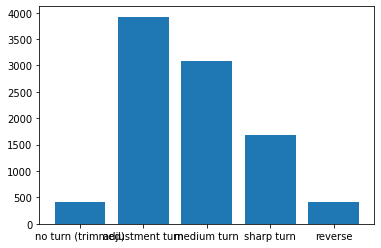

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6446
10
11
12
13
14
15
16
17
18
19


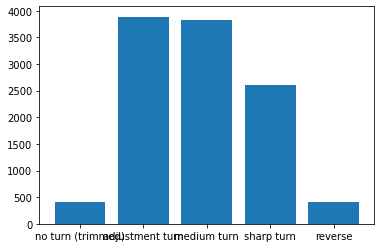

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


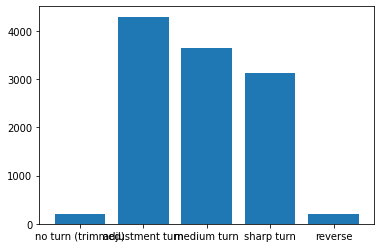

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


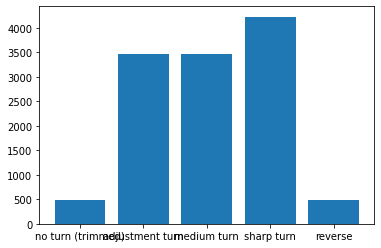

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


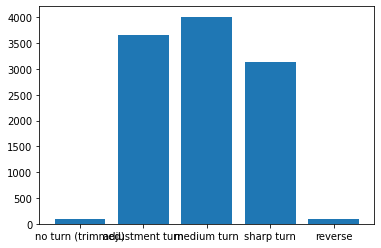

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


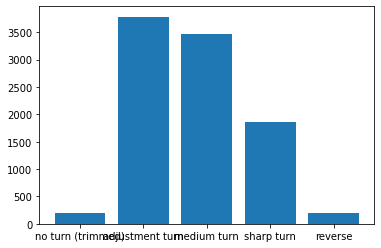

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


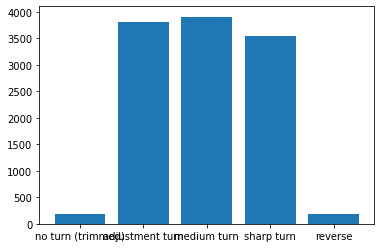

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


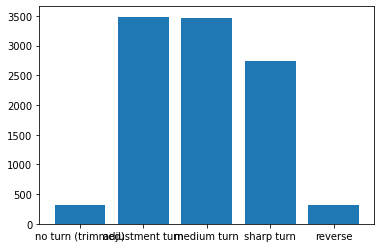

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


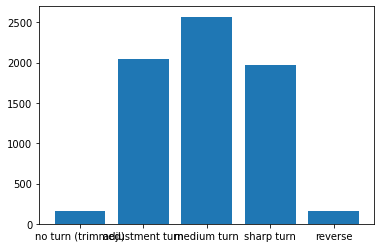

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


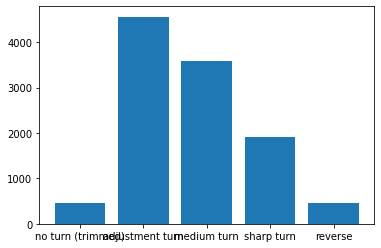

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


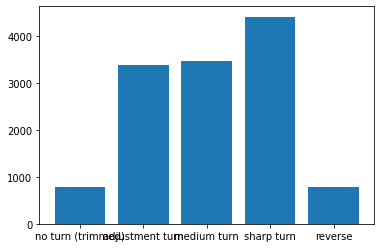

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


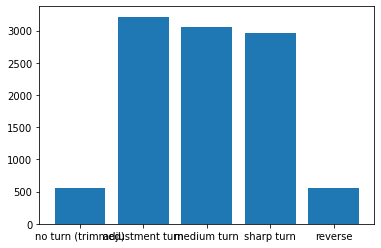

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


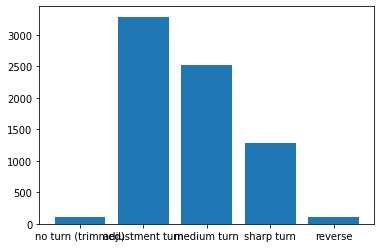

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0451 - accuracy: 0.7440
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


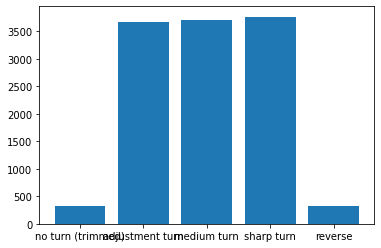

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0640 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 18-------------
0
1
2
3
4
5
6
7
8
9


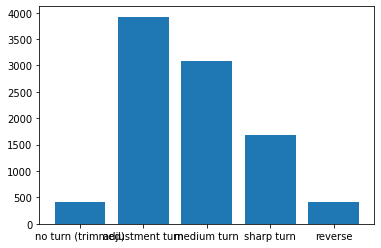

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6442
10
11
12
13
14
15
16
17
18
19


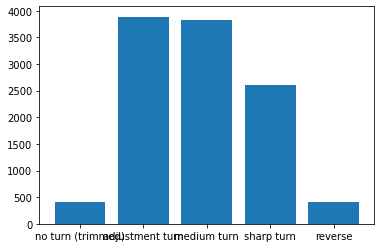

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


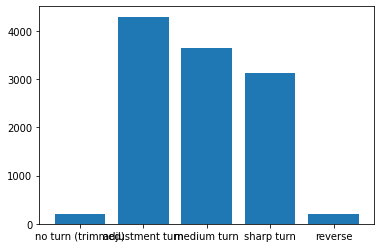

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


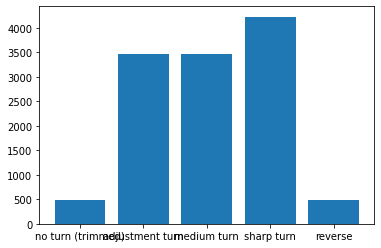

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


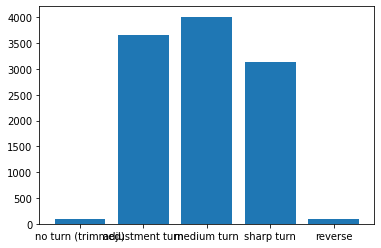

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


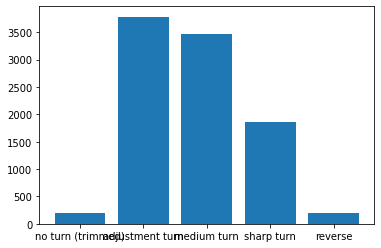

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


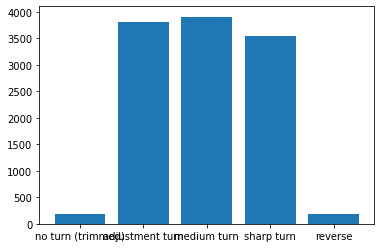

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6795
70
71
72
73
74
75
76
77
78
79


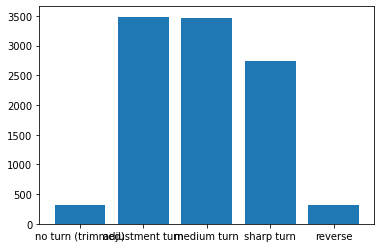

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


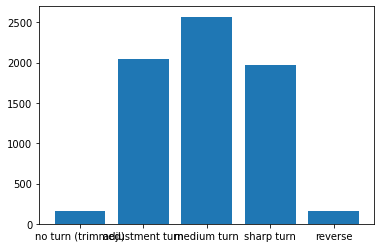

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


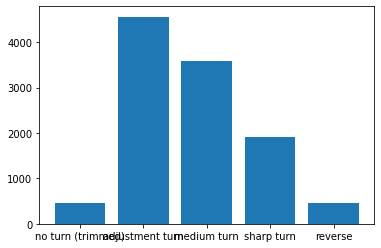

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0583 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


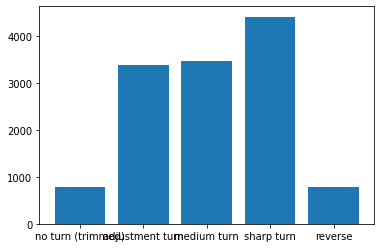

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


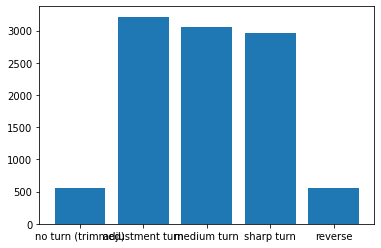

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


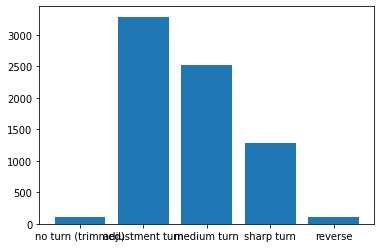

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7443
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


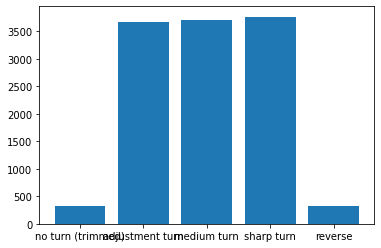

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 19-------------
0
1
2
3
4
5
6
7
8
9


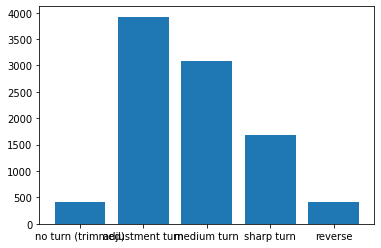

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


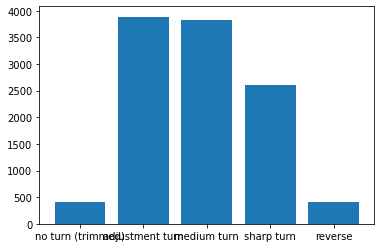

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


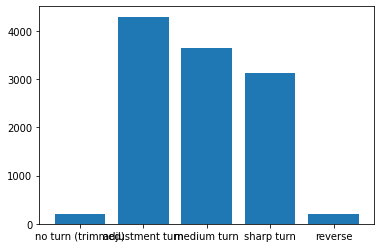

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


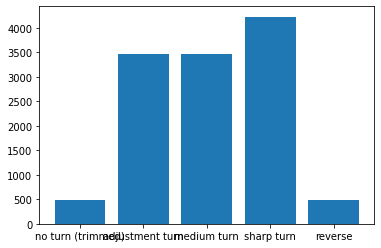

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


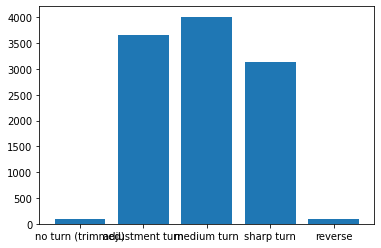

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7358
50
51
52
53
56
57
58
59


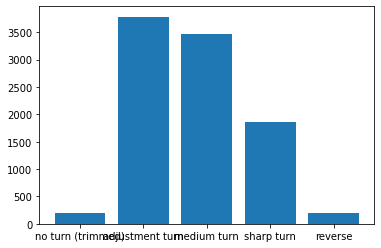

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


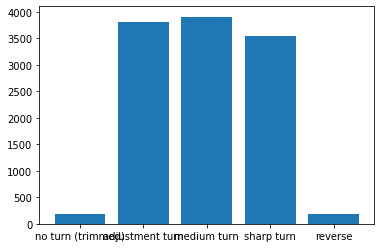

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


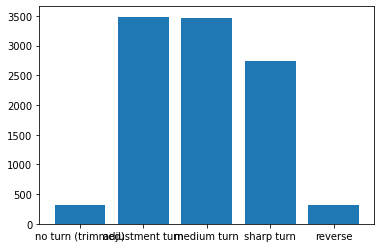

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


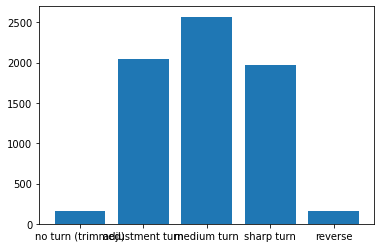

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


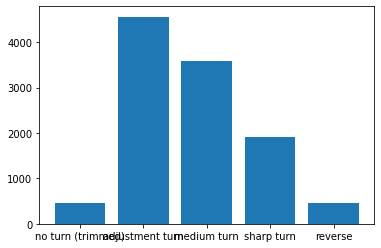

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


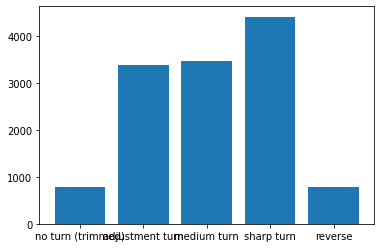

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0782 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


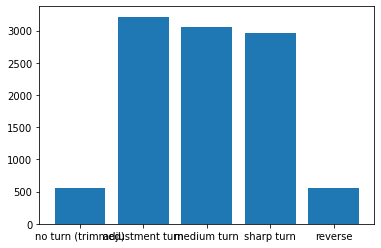

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


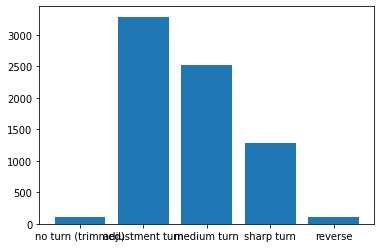

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0451 - accuracy: 0.7440
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


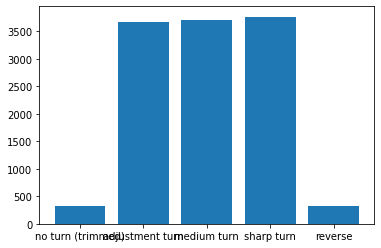

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0638 - accuracy: 0.7181
Test accuracy: 0.7181479334831238
-------------STARTING EPOCH 20-------------
0
1
2
3
4
5
6
7
8
9


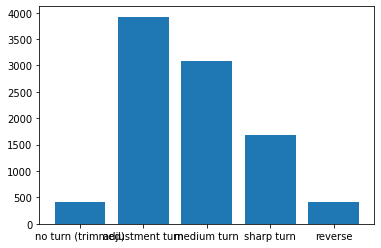

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


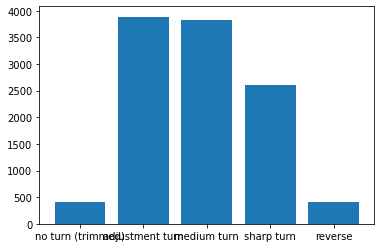

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


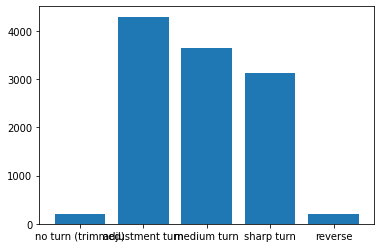

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


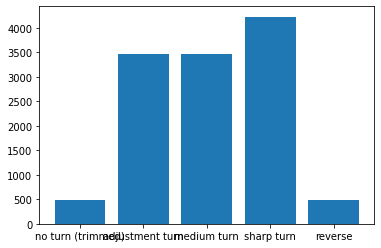

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


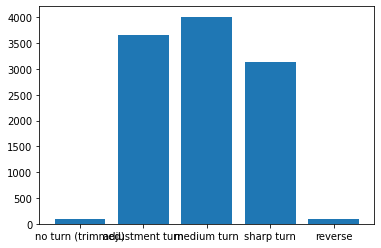

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7359
50
51
52
53
56
57
58
59


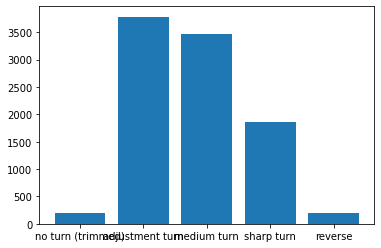

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


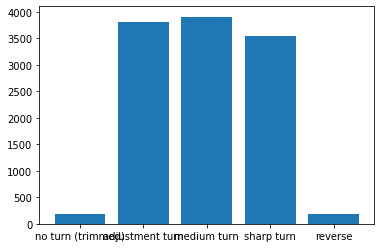

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


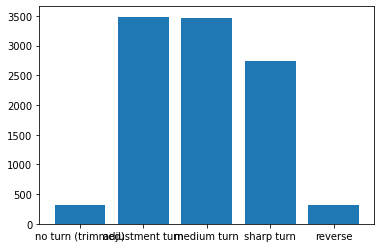

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


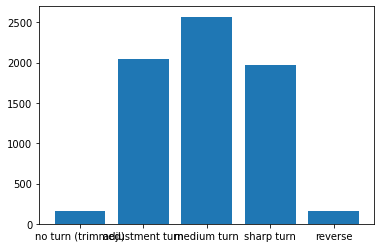

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0626 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


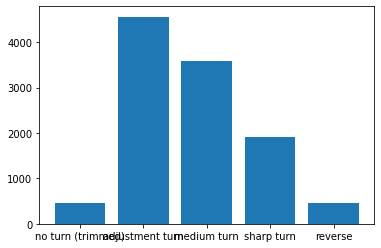

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


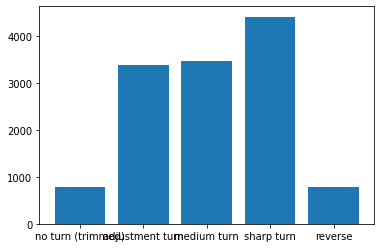

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0782 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


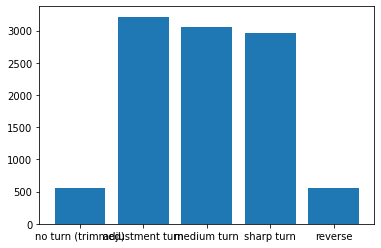

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


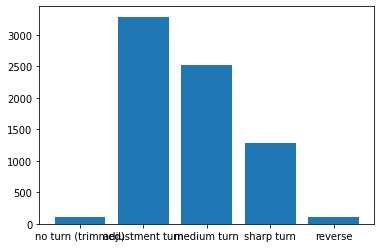

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0451 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


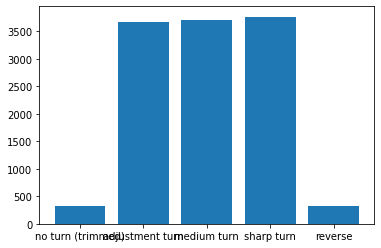

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0637 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
SAVED
-------------STARTING EPOCH 21-------------
0
1
2
3
4
5
6
7
8
9


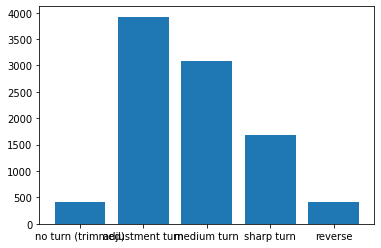

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


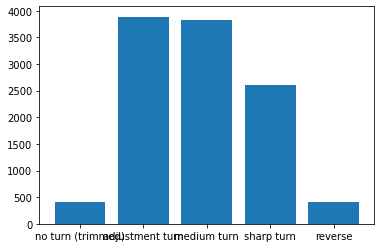

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


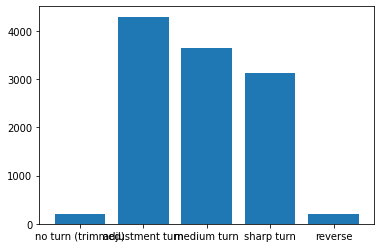

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


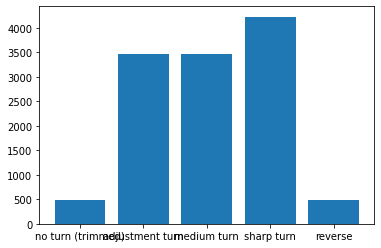

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


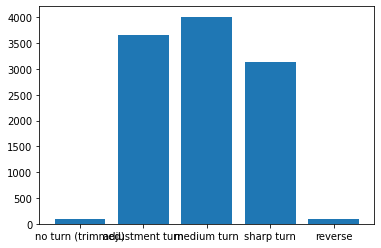

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 10ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


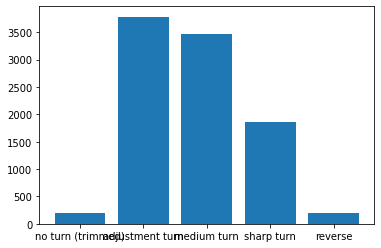

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0473 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


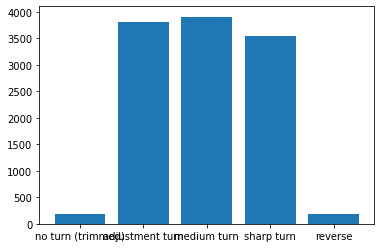

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


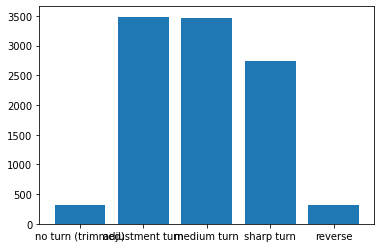

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


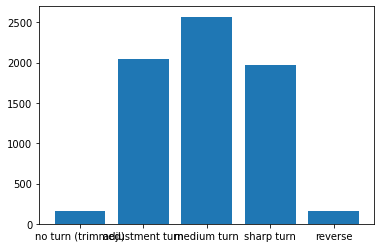

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


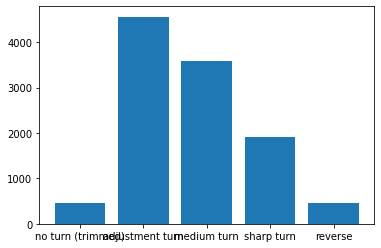

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


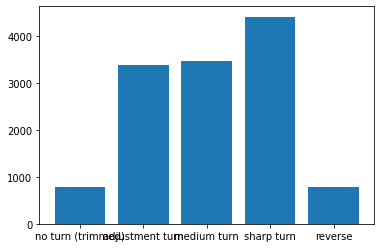

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


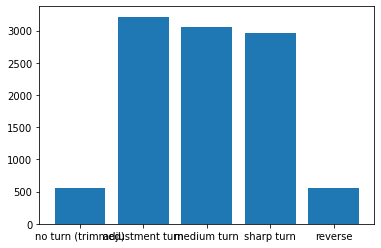

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0695 - accuracy: 0.6759
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


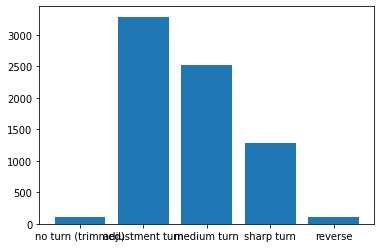

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


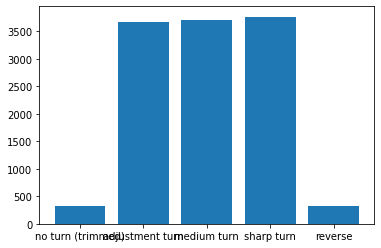

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0639 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 22-------------
0
1
2
3
4
5
6
7
8
9


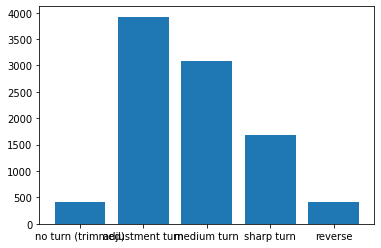

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


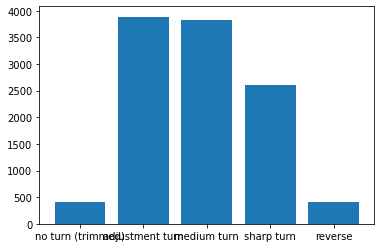

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


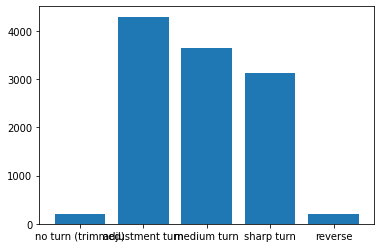

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


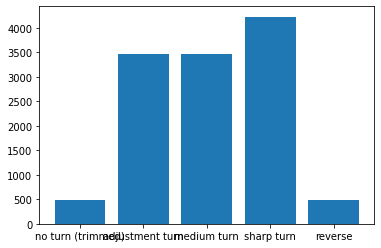

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0662 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


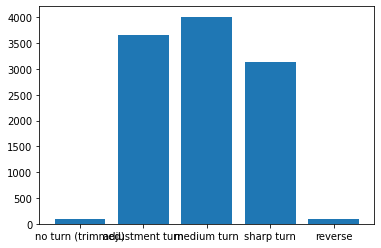

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


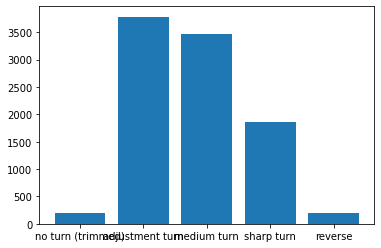

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


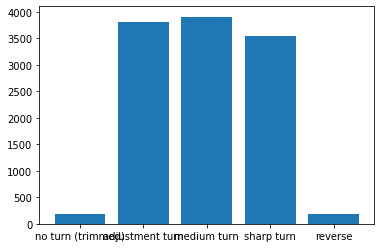

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


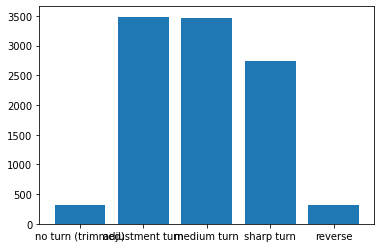

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


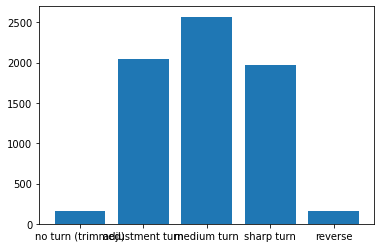

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


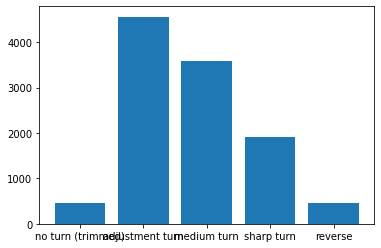

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0581 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


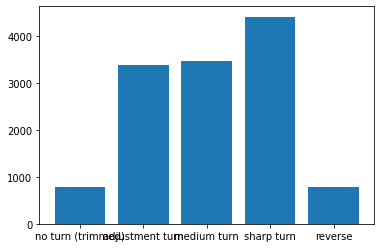

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


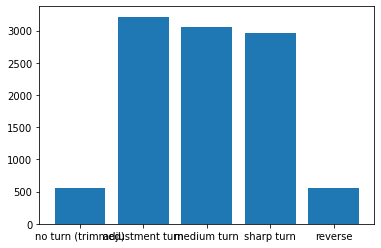

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


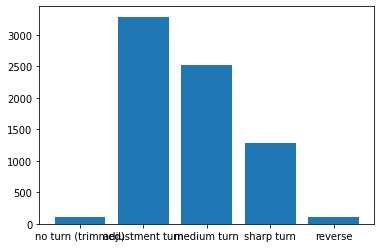

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


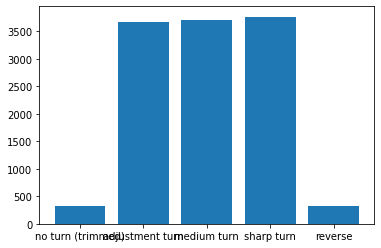

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 6ms/step - loss: 0.0641 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 23-------------
0
1
2
3
4
5
6
7
8
9


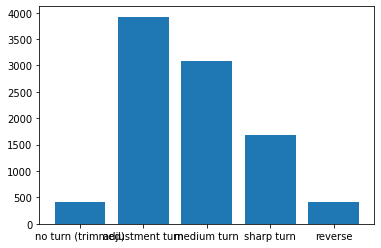

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6446
10
11
12
13
14
15
16
17
18
19


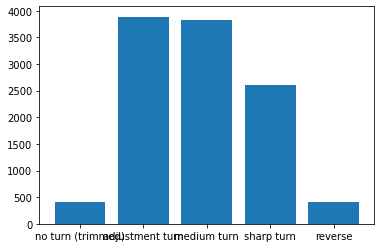

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


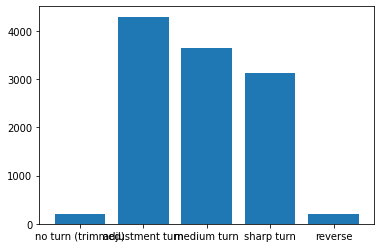

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


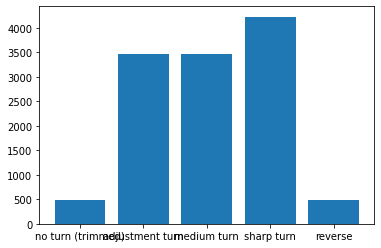

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0662 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


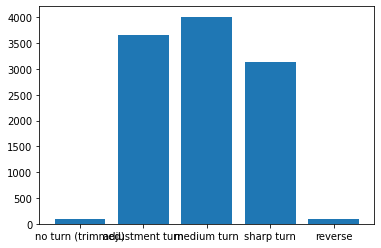

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


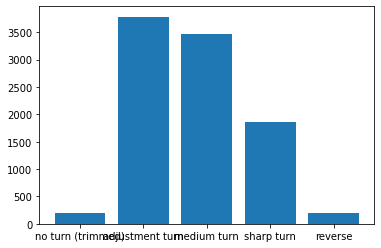

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


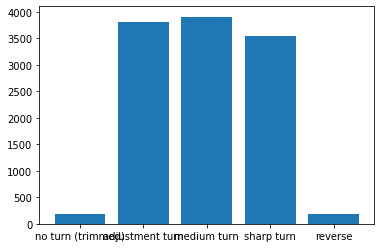

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


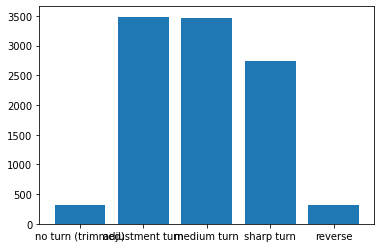

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0603 - accuracy: 0.6540
80
81
82
83
84
85
86
87
88
89


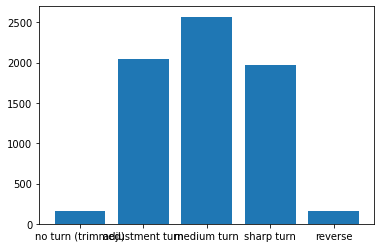

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0624 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


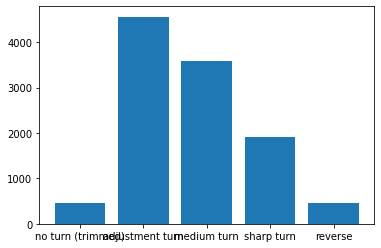

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


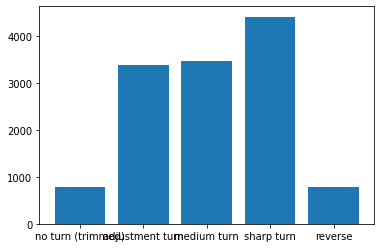

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


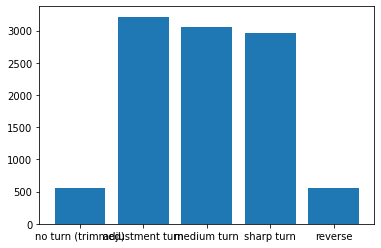

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


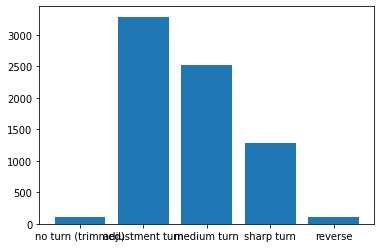

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0449 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


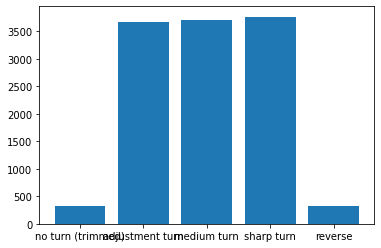

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0643 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 24-------------
0
1
2
3
4
5
6
7
8
9


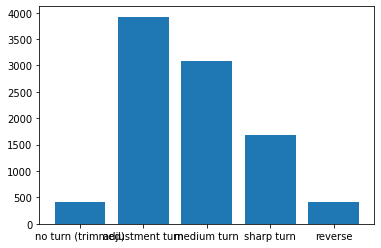

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0503 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


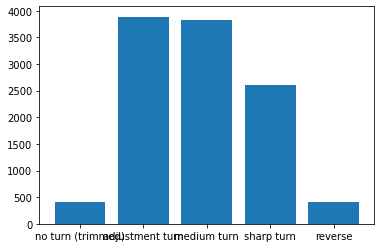

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


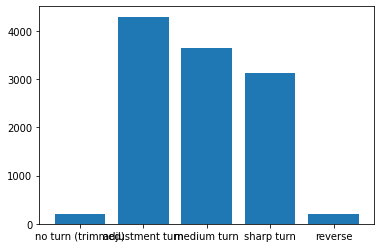

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


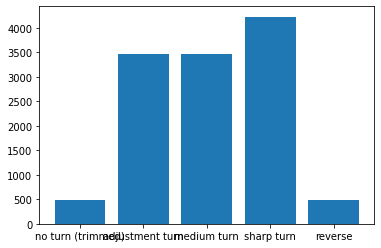

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


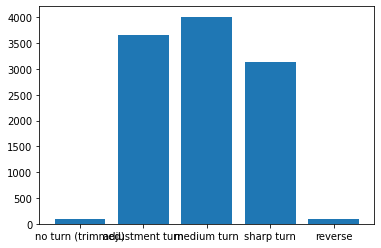

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7359
50
51
52
53
56
57
58
59


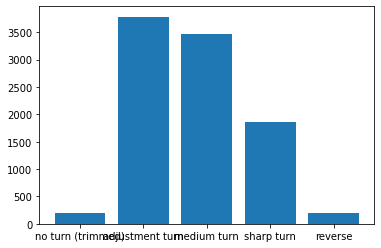

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


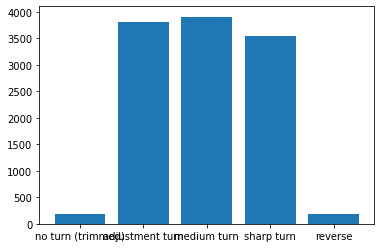

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


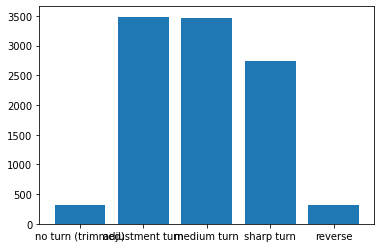

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


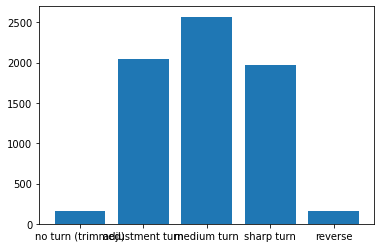

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


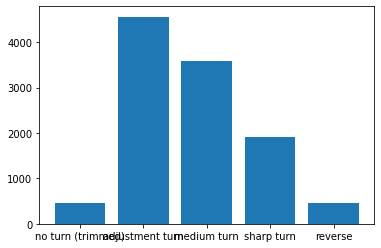

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


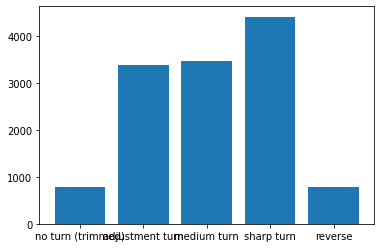

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6240
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


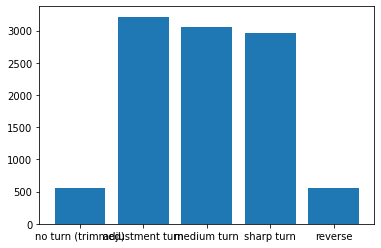

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0693 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


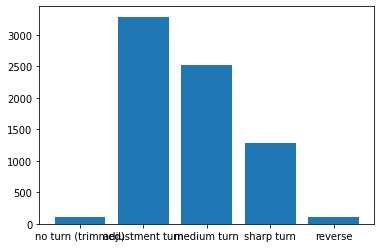

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


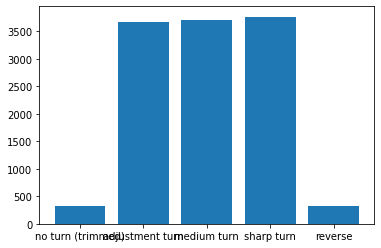

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 25-------------
0
1
2
3
4
5
6
7
8
9


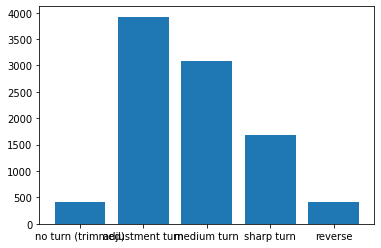

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 10ms/step - loss: 0.0502 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


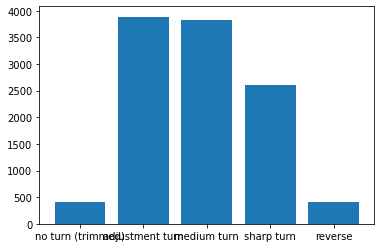

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


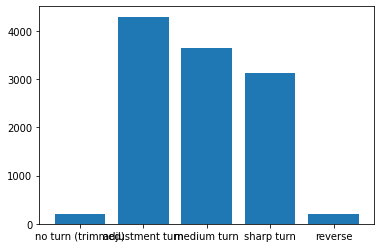

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7547
30
31
32
33
34
35
36
37
38
39


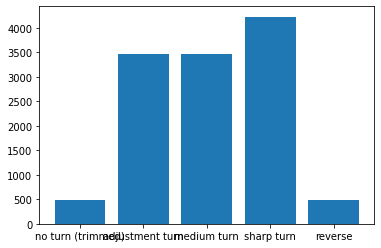

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


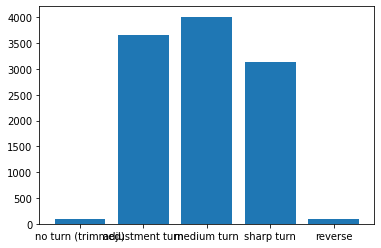

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7358
50
51
52
53
56
57
58
59


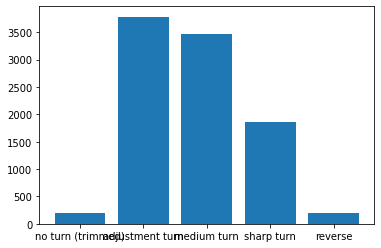

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


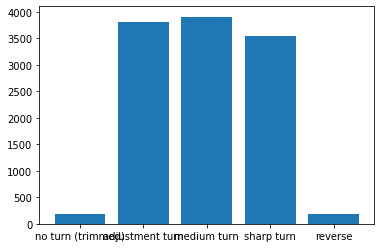

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


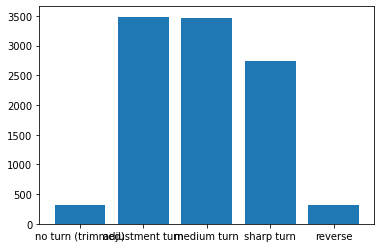

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


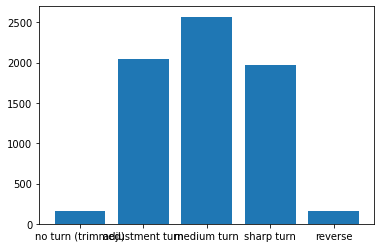

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


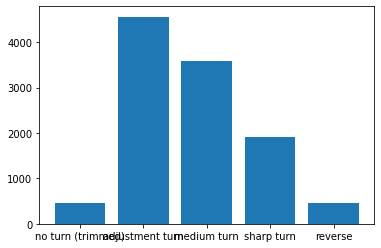

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


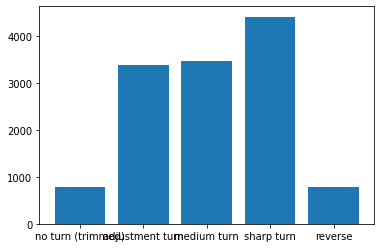

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


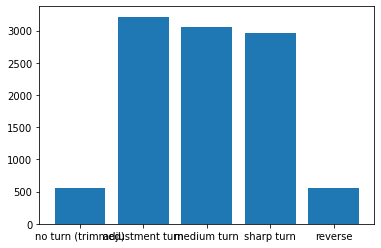

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


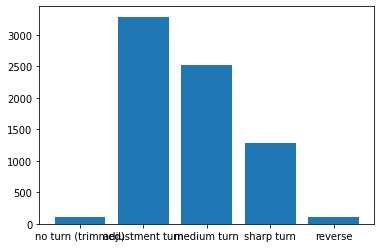

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7443
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


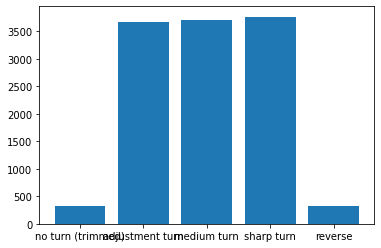

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 26-------------
0
1
2
3
4
5
6
7
8
9


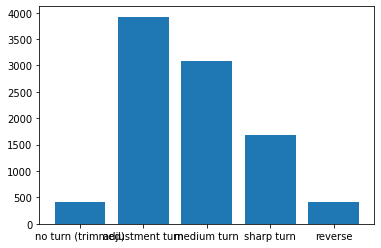

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6442
10
11
12
13
14
15
16
17
18
19


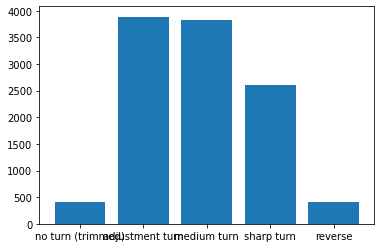

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


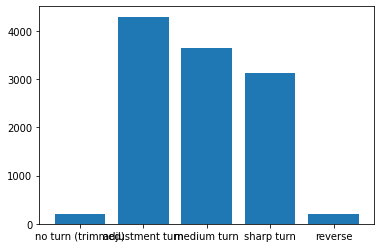

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


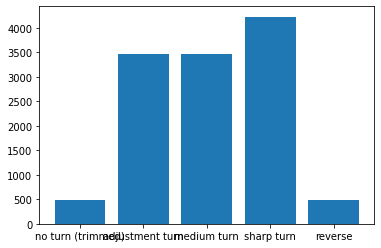

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


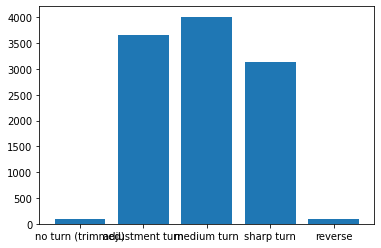

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


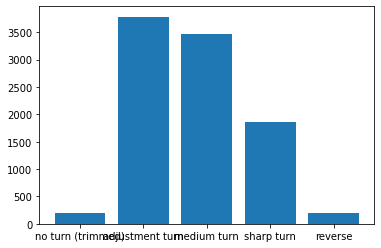

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


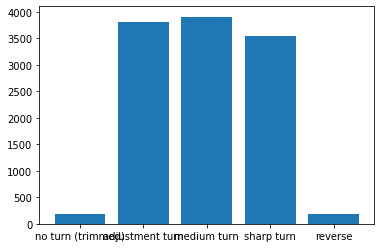

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


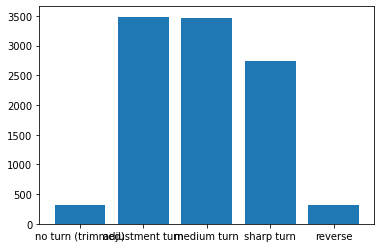

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


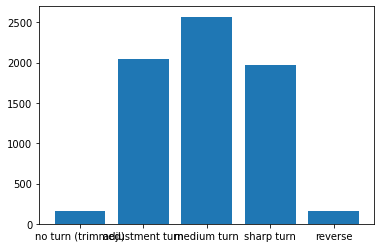

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


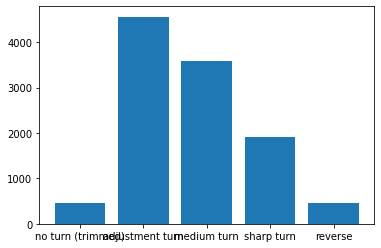

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


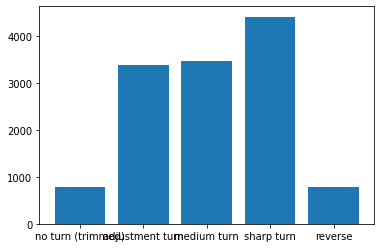

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


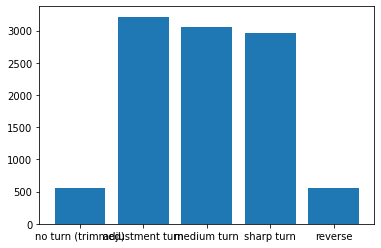

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


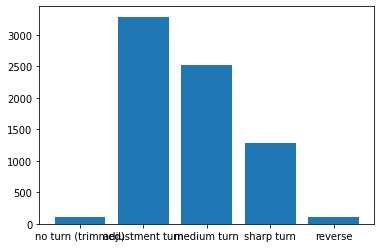

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


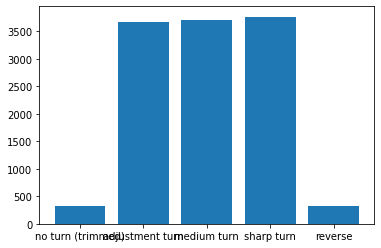

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0636 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 27-------------
0
1
2
3
4
5
6
7
8
9


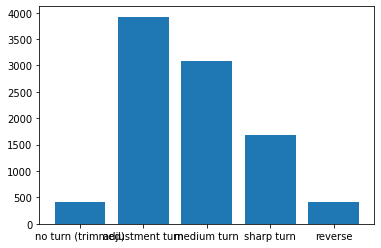

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6442
10
11
12
13
14
15
16
17
18
19


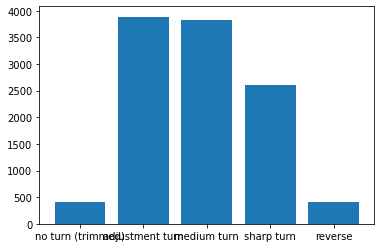

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


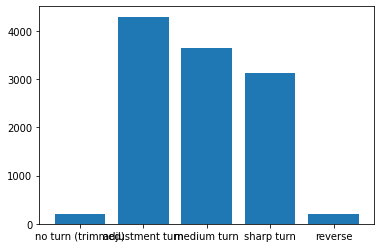

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0507 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


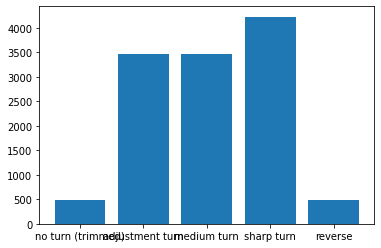

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


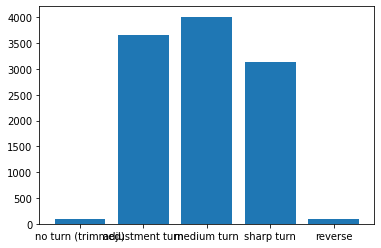

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7360
50
51
52
53
56
57
58
59


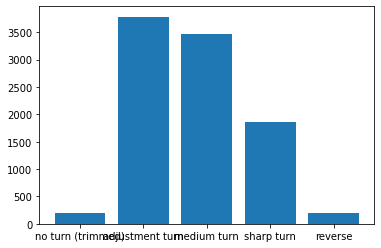

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


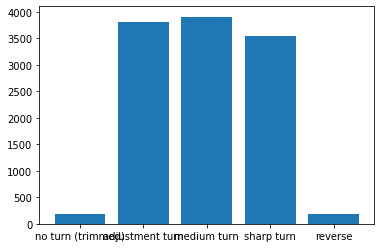

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


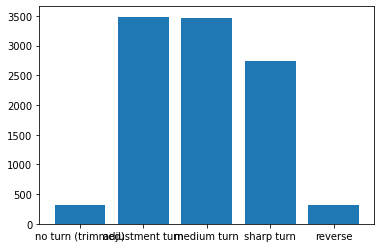

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0603 - accuracy: 0.6537
80
81
82
83
84
85
86
87
88
89


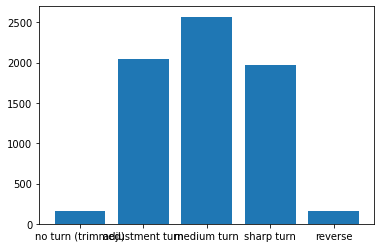

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 10ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


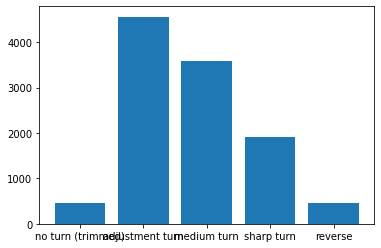

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


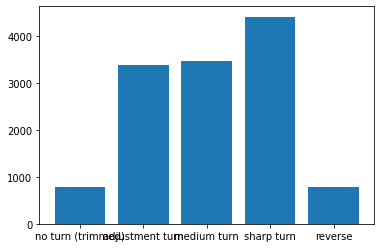

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6240
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


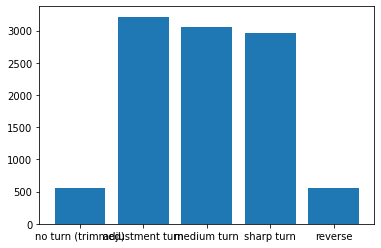

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


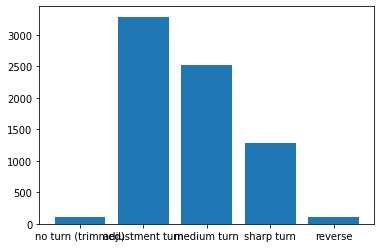

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


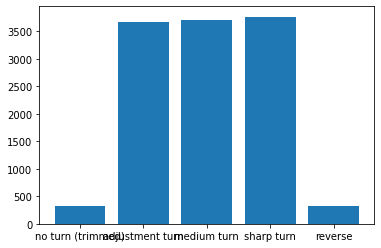

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0640 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 28-------------
0
1
2
3
4
5
6
7
8
9


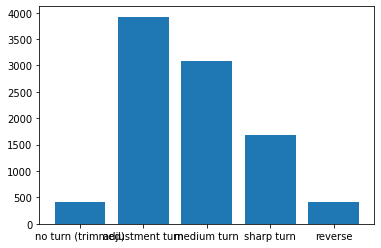

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


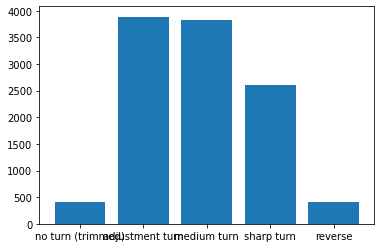

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


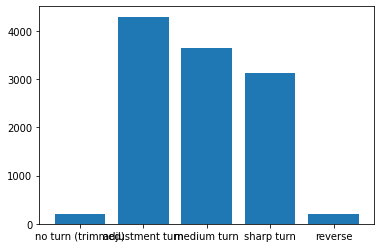

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


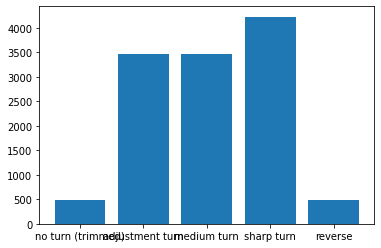

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


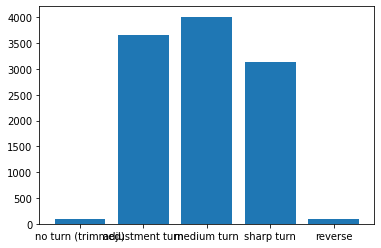

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7359
50
51
52
53
56
57
58
59


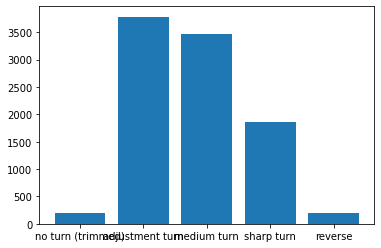

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


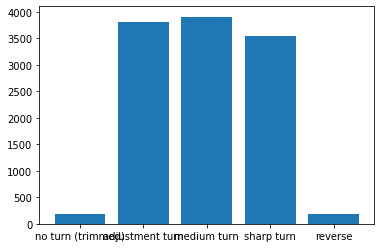

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


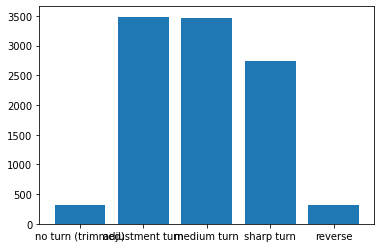

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0604 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


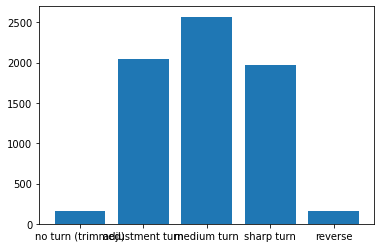

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


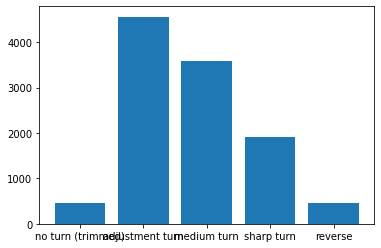

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


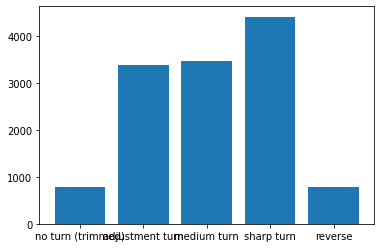

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


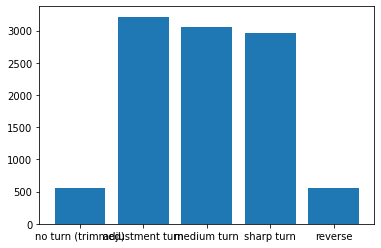

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0694 - accuracy: 0.6759
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


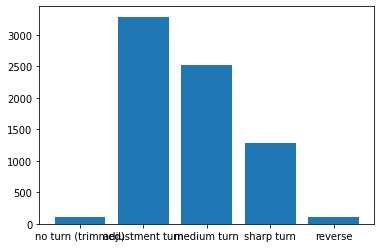

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0451 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


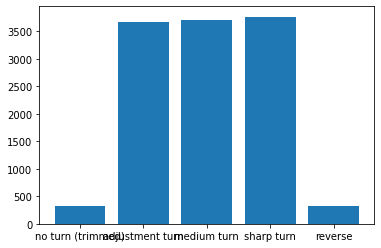

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0636 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 29-------------
0
1
2
3
4
5
6
7
8
9


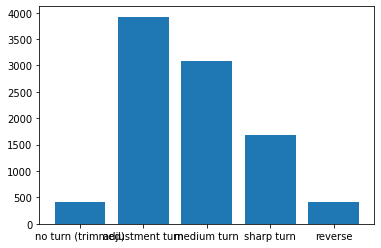

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


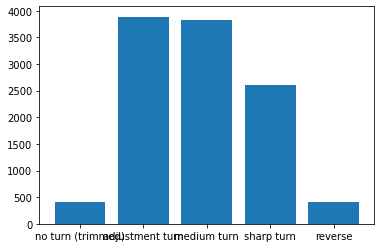

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


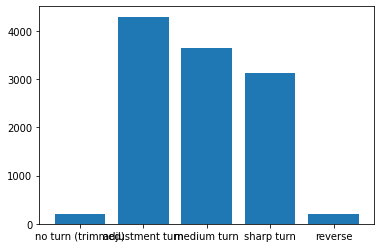

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


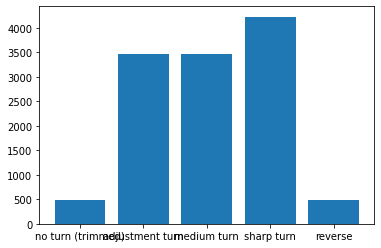

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


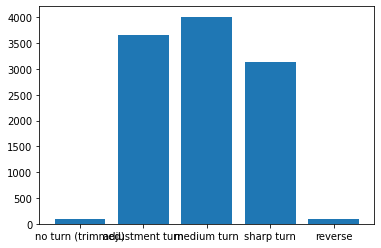

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7359
50
51
52
53
56
57
58
59


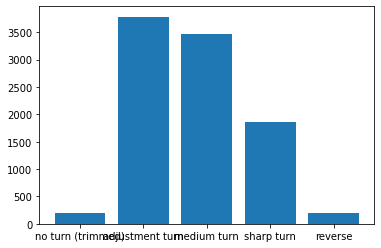

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


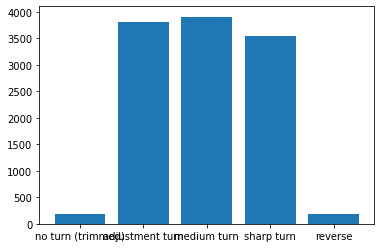

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


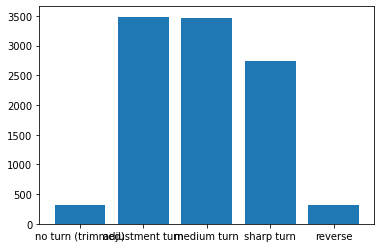

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


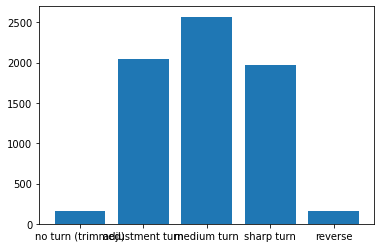

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


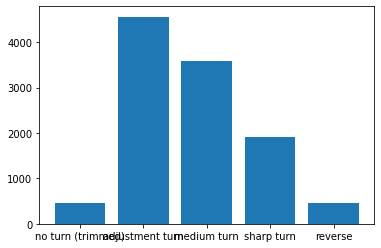

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


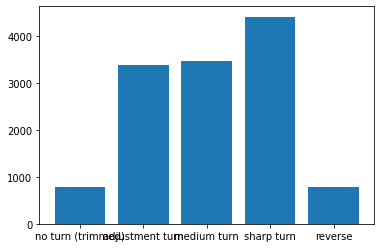

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0782 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


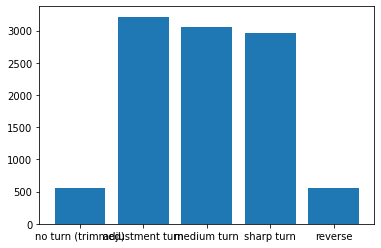

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6755
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


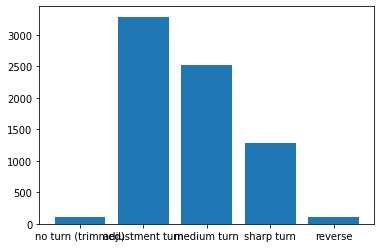

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


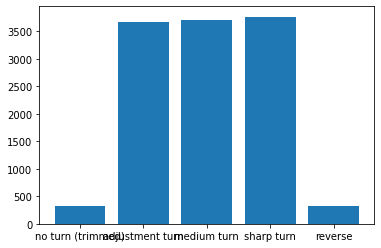

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 30-------------
0
1
2
3
4
5
6
7
8
9


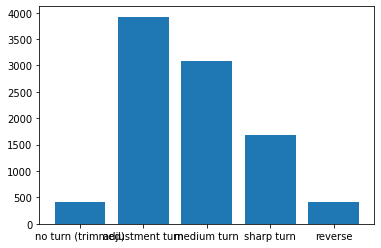

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6446
10
11
12
13
14
15
16
17
18
19


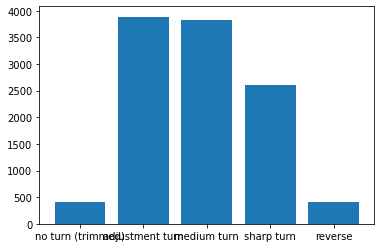

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


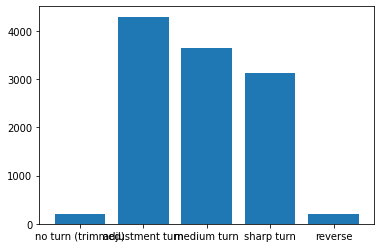

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0507 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


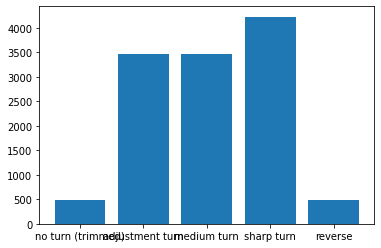

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


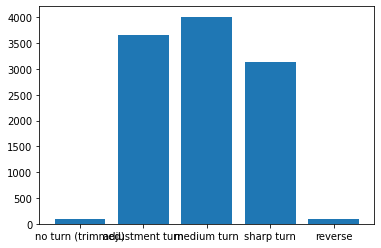

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


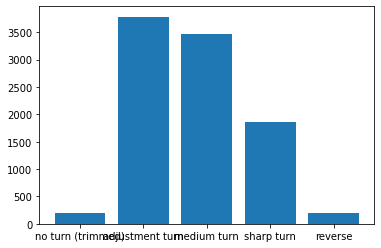

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


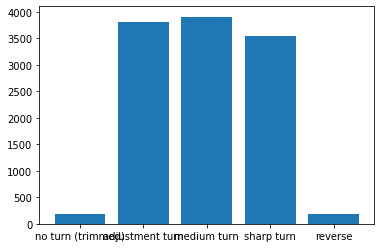

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


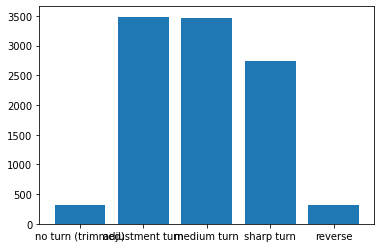

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


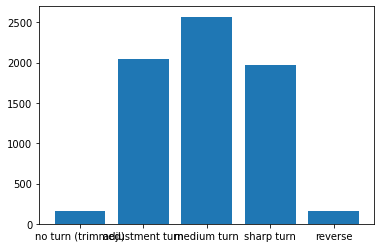

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6972
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


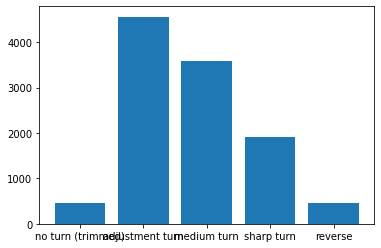

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


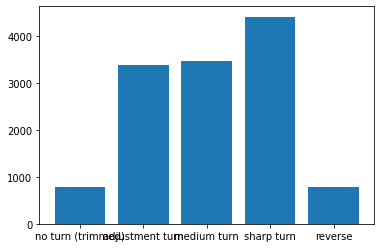

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0782 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


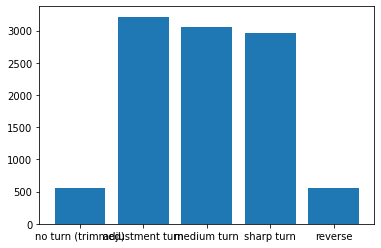

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


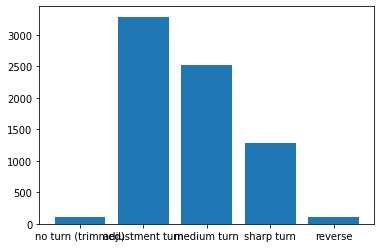

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


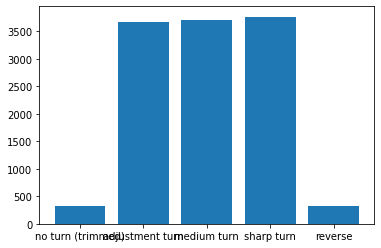

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 31-------------
0
1
2
3
4
5
6
7
8
9


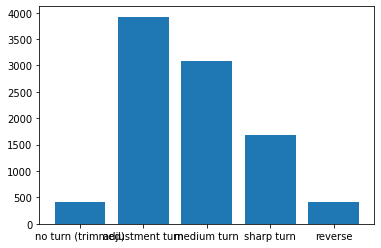

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


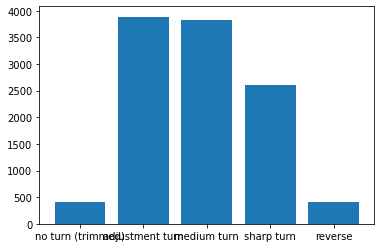

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


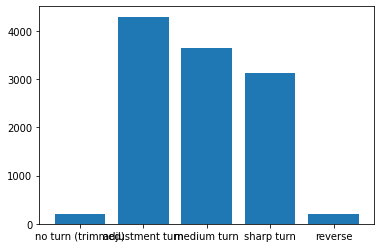

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


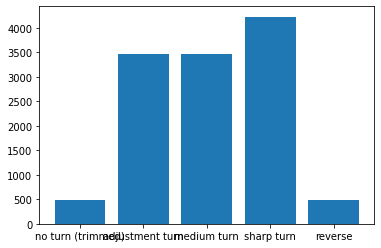

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


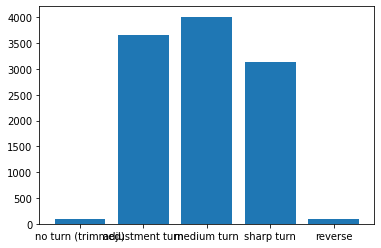

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


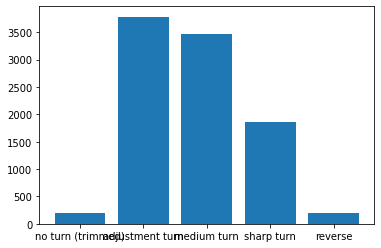

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 12ms/step - loss: 0.0472 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


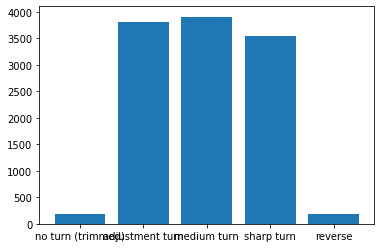

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0523 - accuracy: 0.6797
70
71
72
73
74
75
76
77
78
79


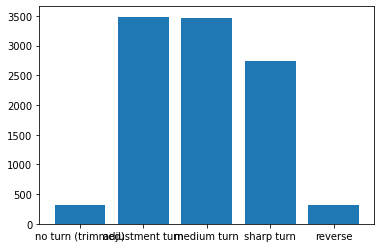

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


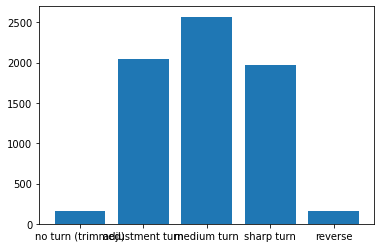

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


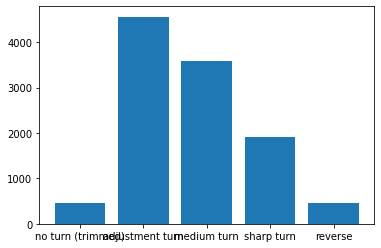

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


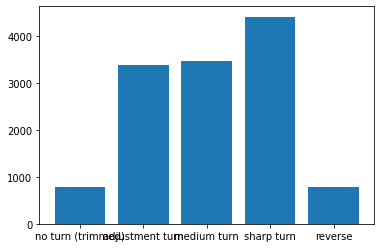

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


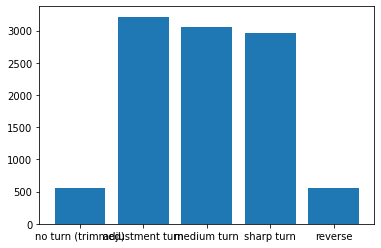

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


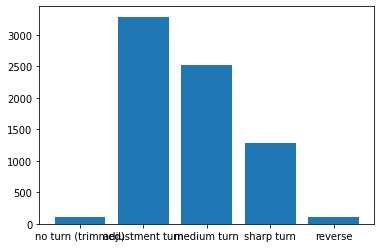

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7443
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


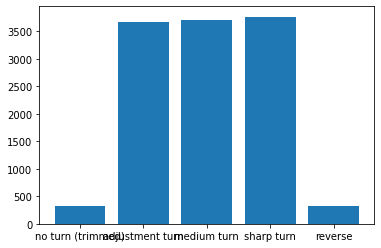

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0640 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 32-------------
0
1
2
3
4
5
6
7
8
9


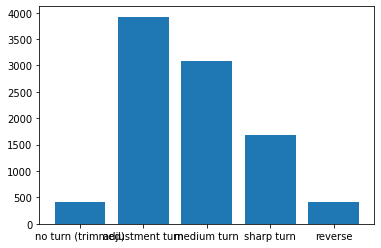

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


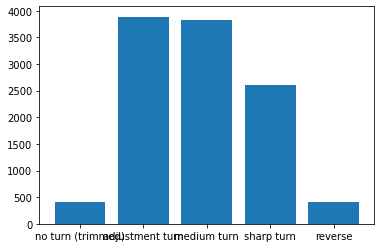

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


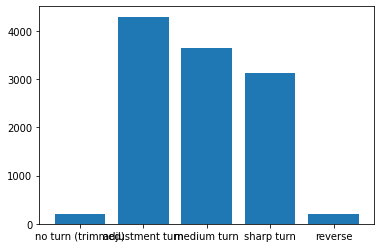

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


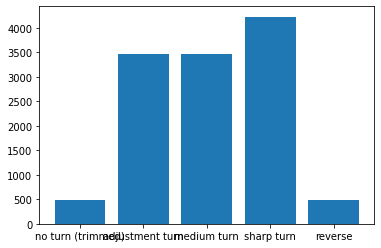

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0659 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


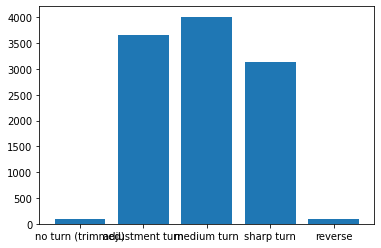

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


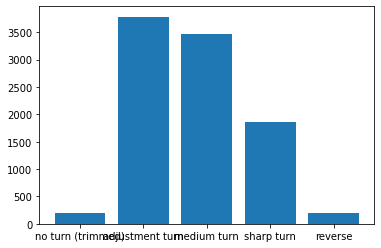

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0474 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


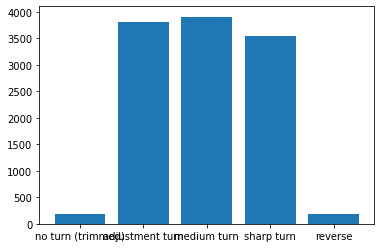

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


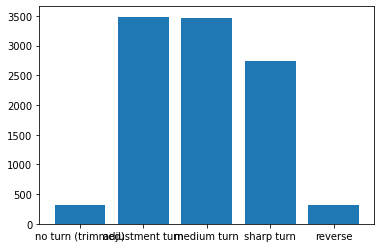

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6541
80
81
82
83
84
85
86
87
88
89


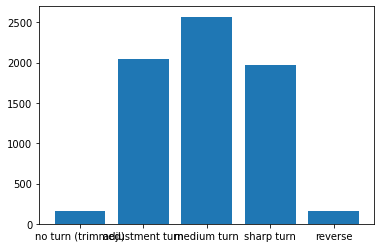

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0626 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


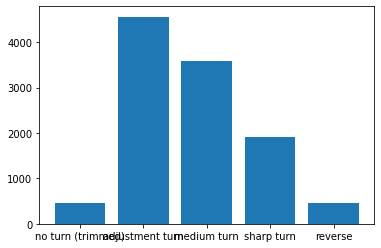

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


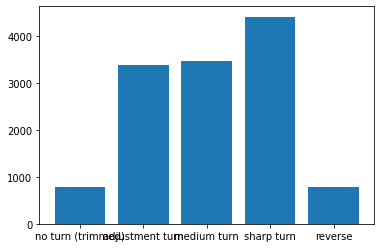

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


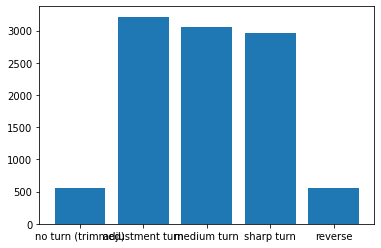

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0693 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


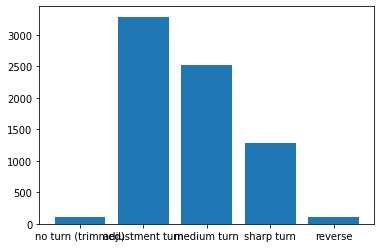

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0452 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


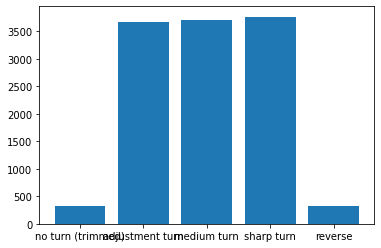

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0643 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 33-------------
0
1
2
3
4
5
6
7
8
9


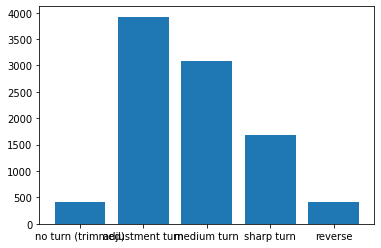

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


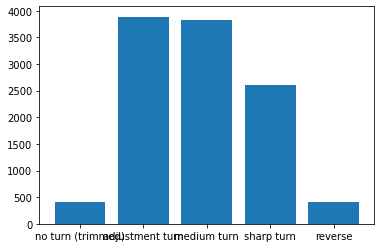

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


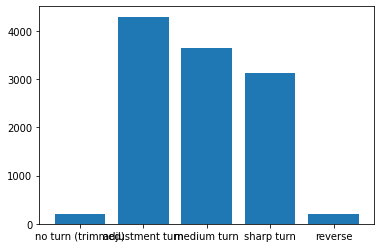

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7550
30
31
32
33
34
35
36
37
38
39


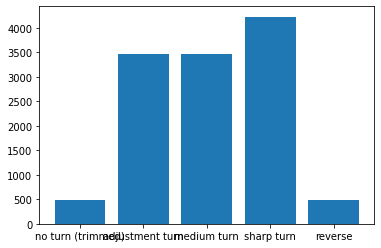

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


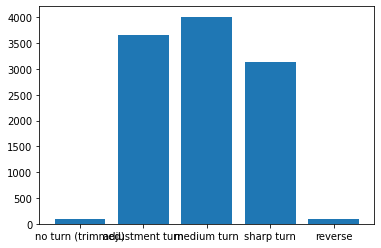

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


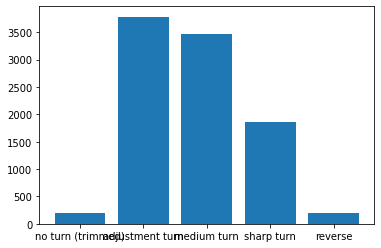

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


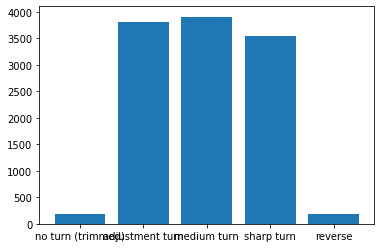

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


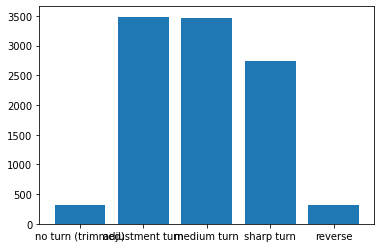

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


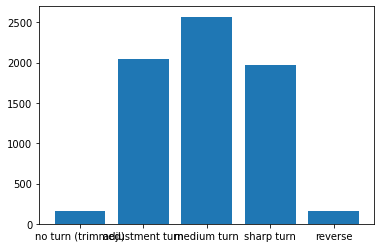

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0624 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


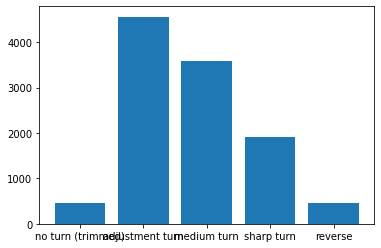

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


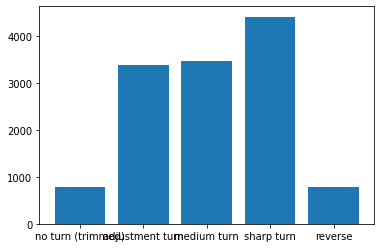

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


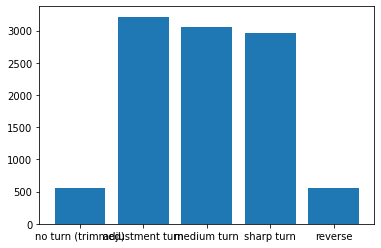

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6755
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


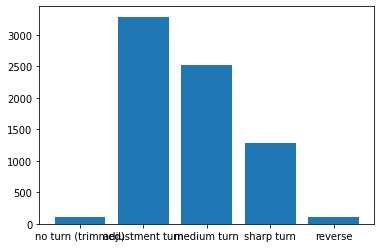

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


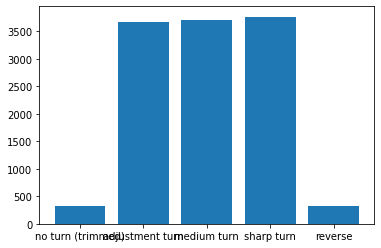

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0641 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 34-------------
0
1
2
3
4
5
6
7
8
9


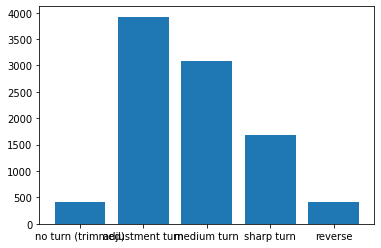

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


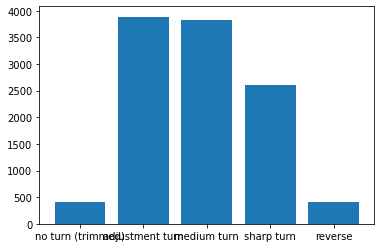

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


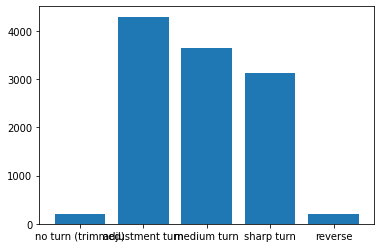

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


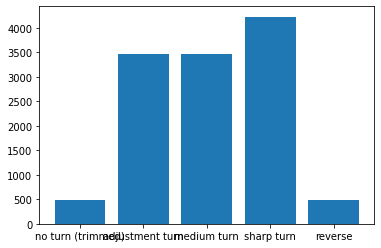

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


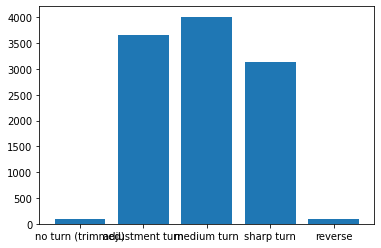

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


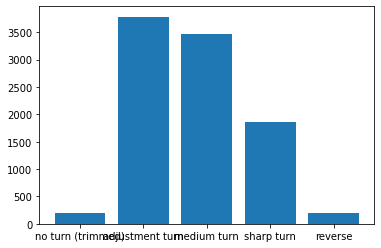

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


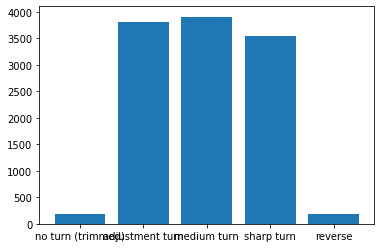

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6795
70
71
72
73
74
75
76
77
78
79


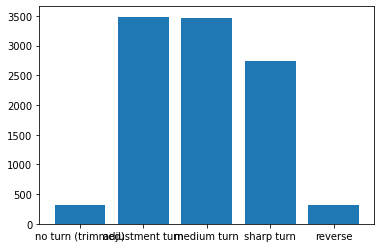

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


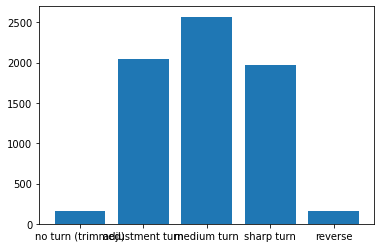

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


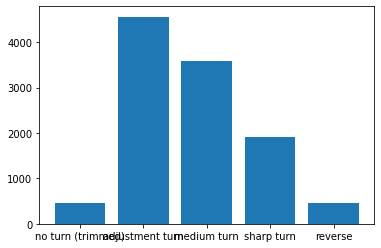

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


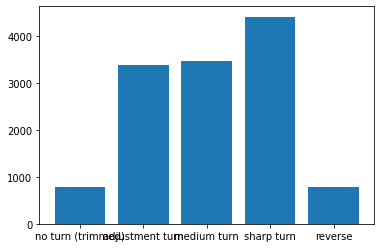

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


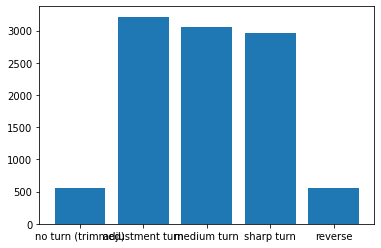

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


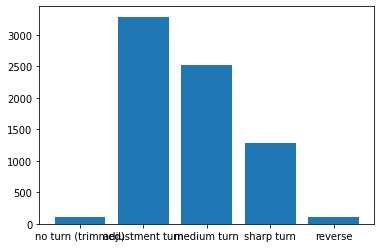

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0452 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


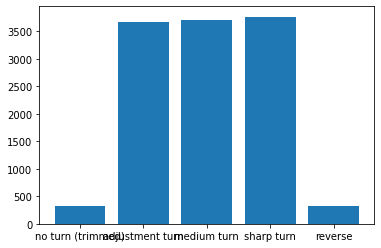

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 35-------------
0
1
2
3
4
5
6
7
8
9


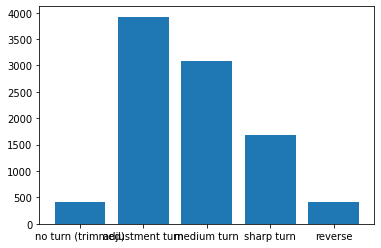

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


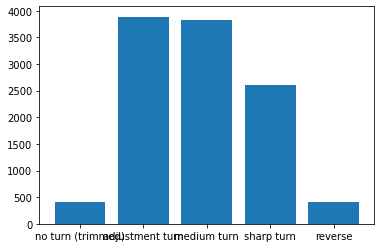

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6875
20
21
22
23
24
25
26
27
28
29


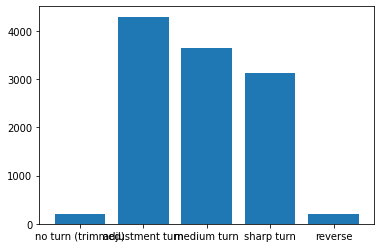

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


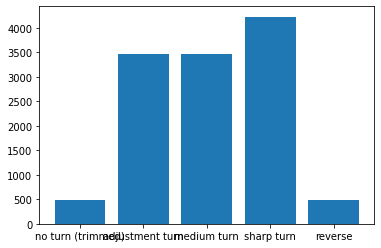

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


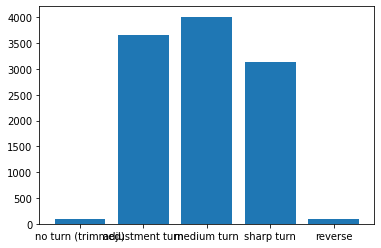

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


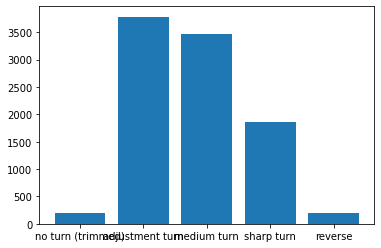

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


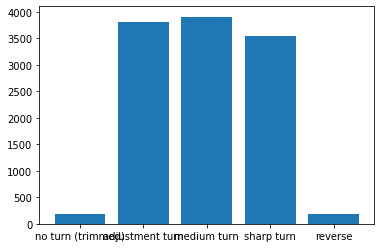

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


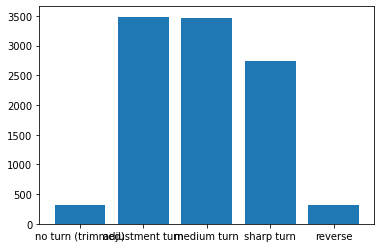

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0603 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


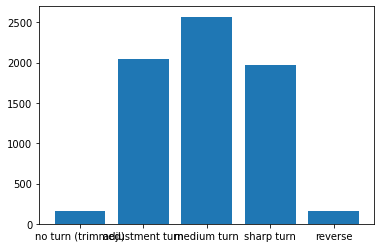

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


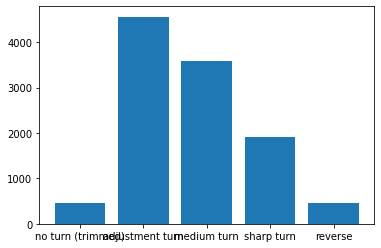

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


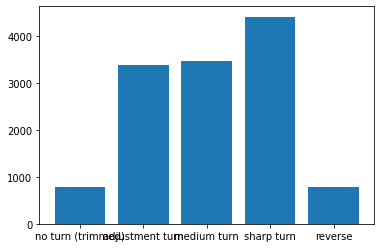

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


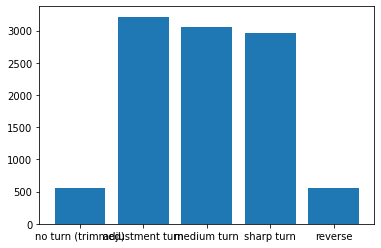

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


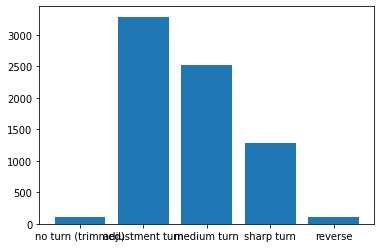

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


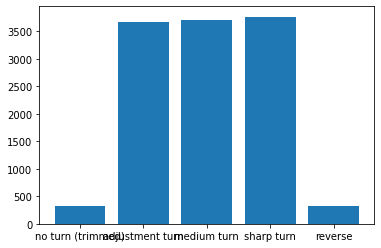

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 36-------------
0
1
2
3
4
5
6
7
8
9


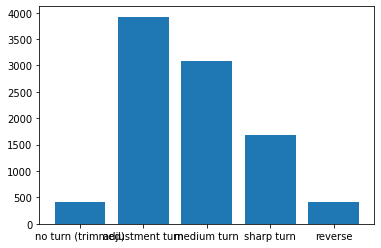

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


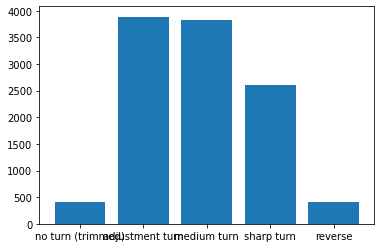

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


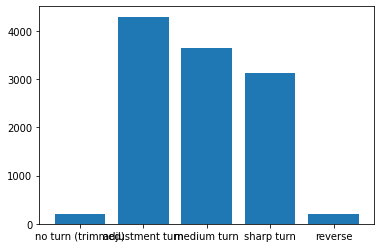

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7547
30
31
32
33
34
35
36
37
38
39


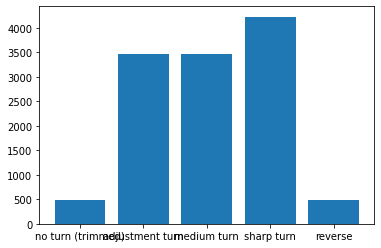

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 11ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


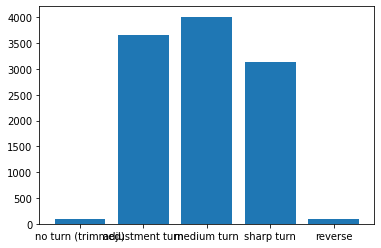

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


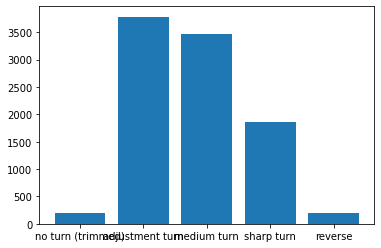

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


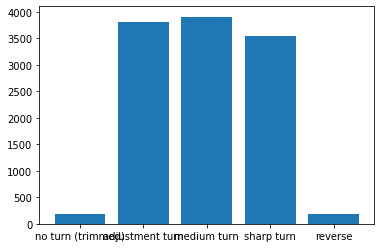

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


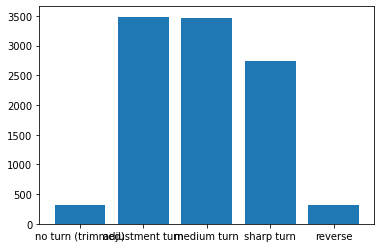

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6537
80
81
82
83
84
85
86
87
88
89


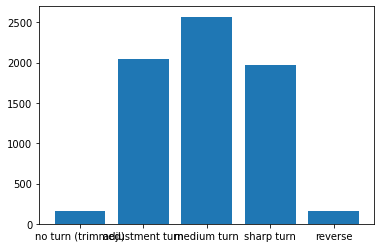

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


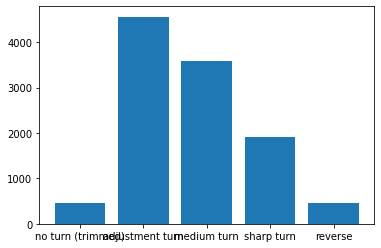

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


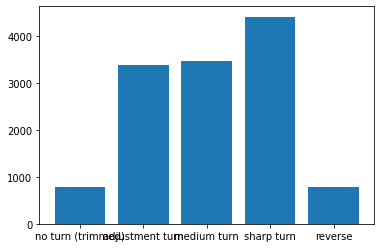

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 5s 11ms/step - loss: 0.0783 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


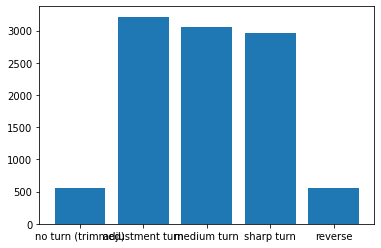

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6755
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


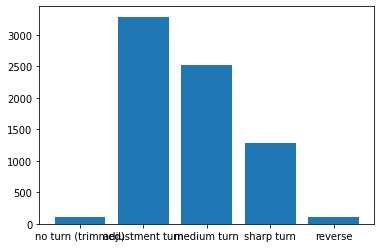

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


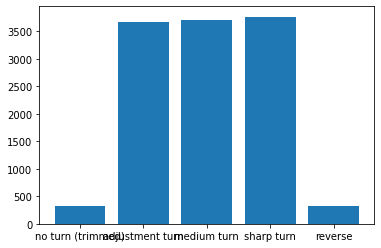

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 37-------------
0
1
2
3
4
5
6
7
8
9


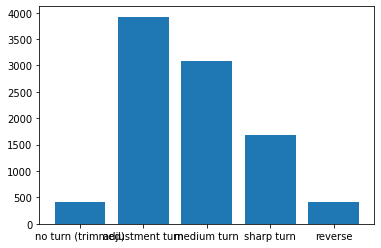

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6447
10
11
12
13
14
15
16
17
18
19


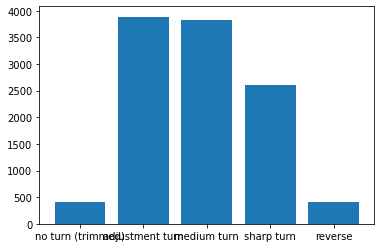

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


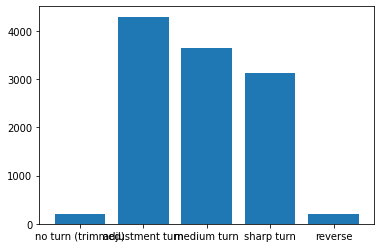

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


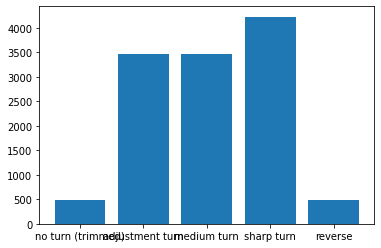

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


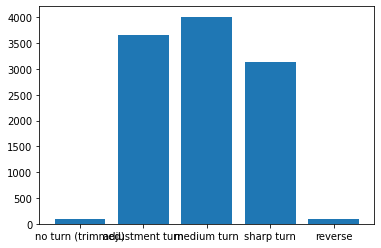

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


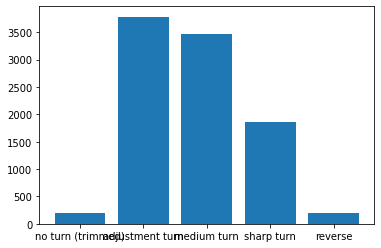

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


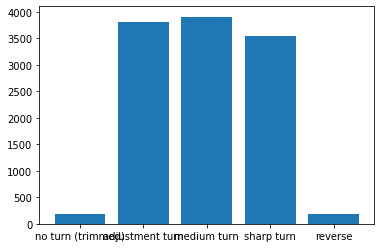

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


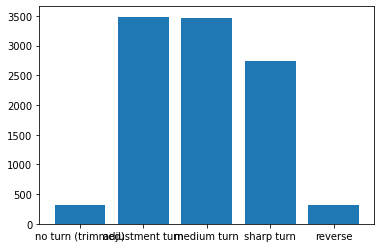

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


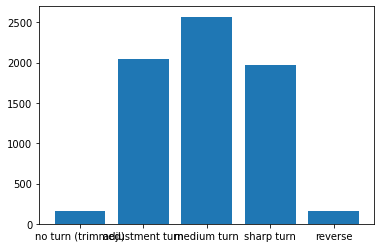

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


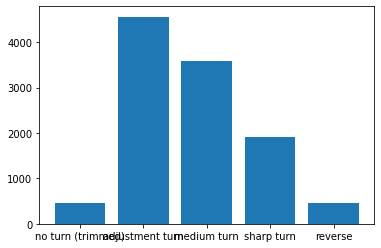

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


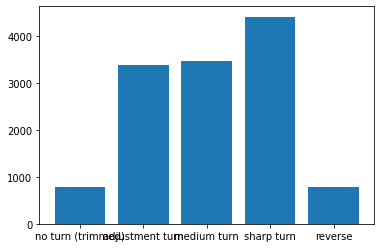

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


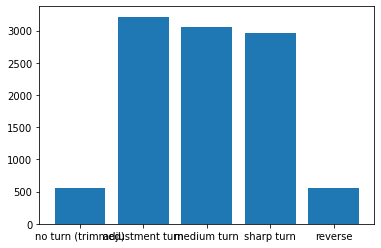

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


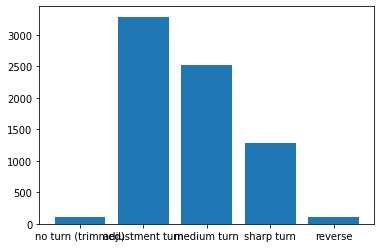

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0450 - accuracy: 0.7443
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


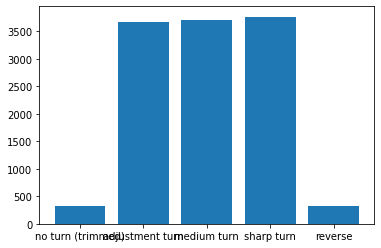

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 38-------------
0
1
2
3
4
5
6
7
8
9


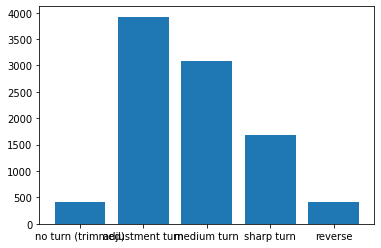

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


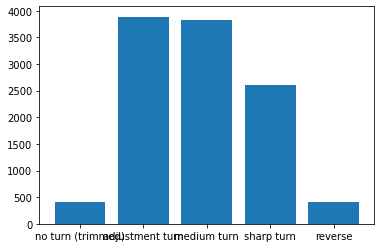

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


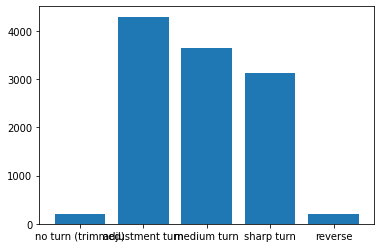

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


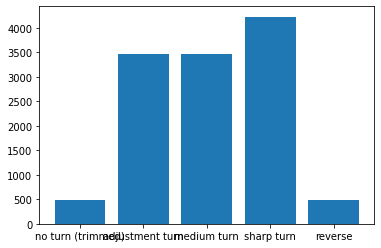

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


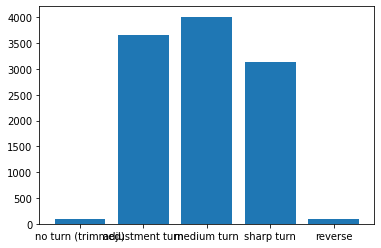

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


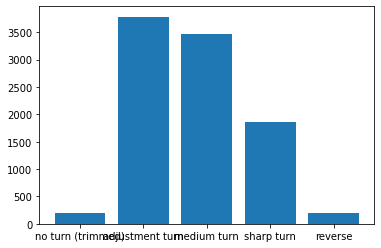

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


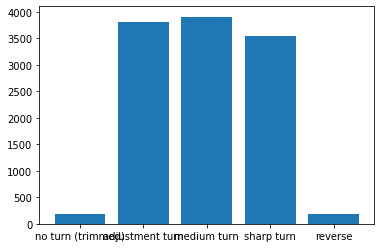

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


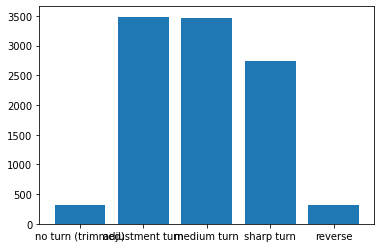

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


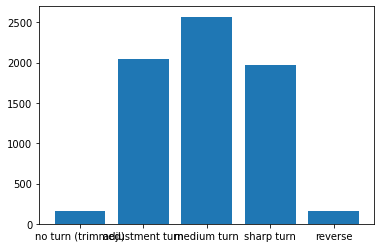

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6975
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


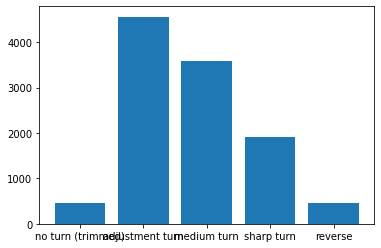

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


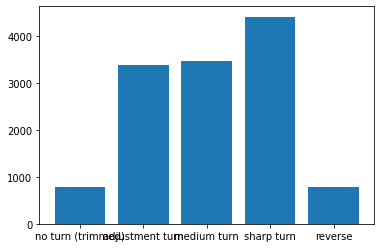

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6240
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


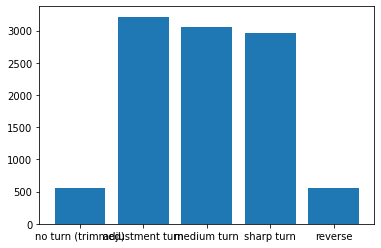

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


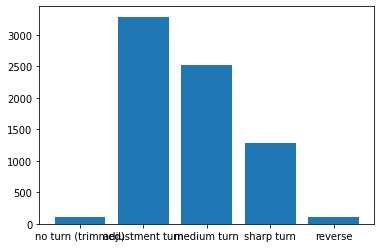

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


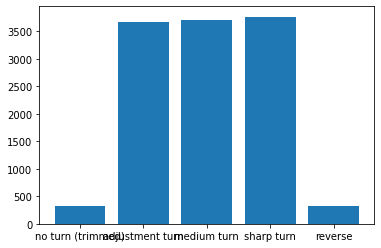

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0638 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 39-------------
0
1
2
3
4
5
6
7
8
9


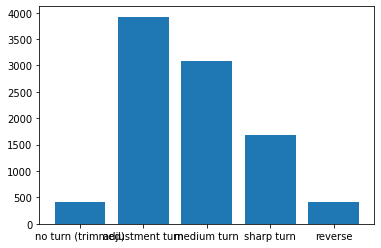

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


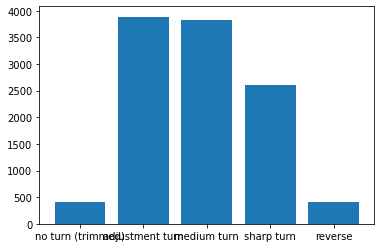

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


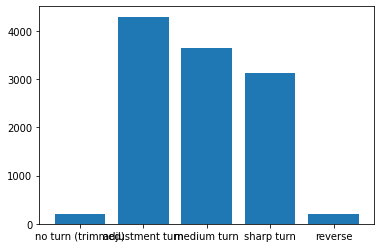

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


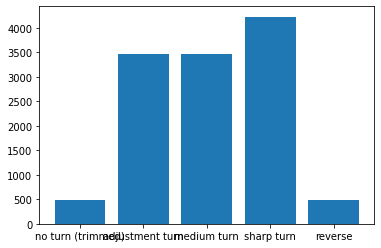

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


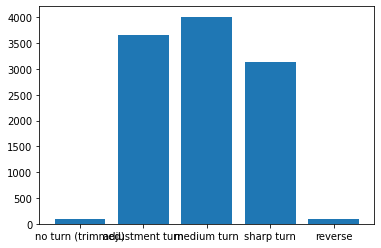

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


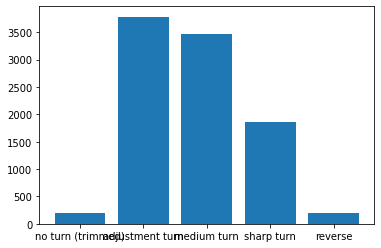

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0474 - accuracy: 0.8272
60
61
62
63
64
65
66
67
68
69


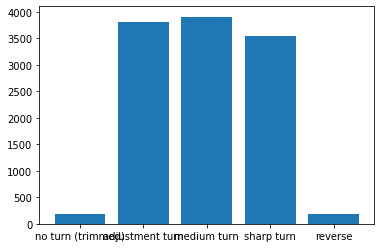

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


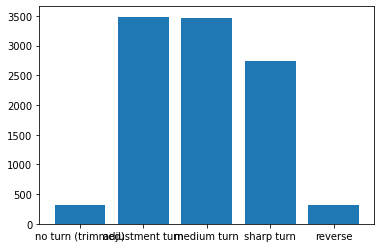

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


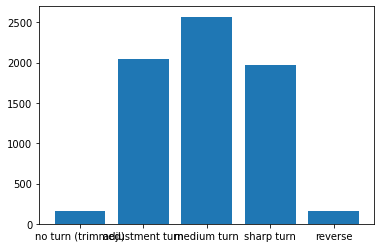

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


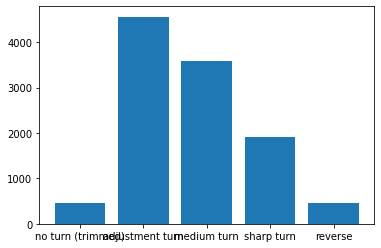

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


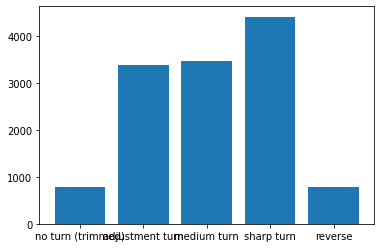

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


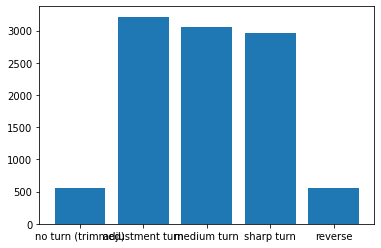

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


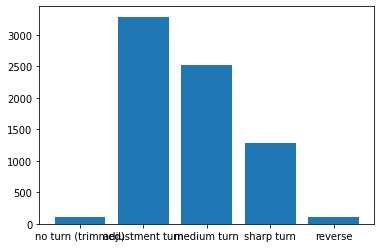

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


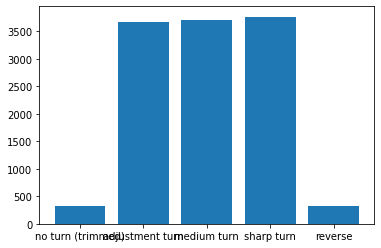

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 40-------------
0
1
2
3
4
5
6
7
8
9


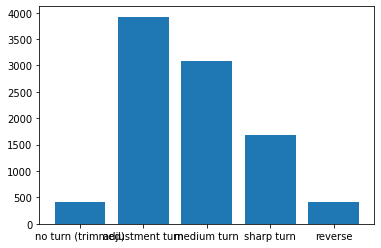

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


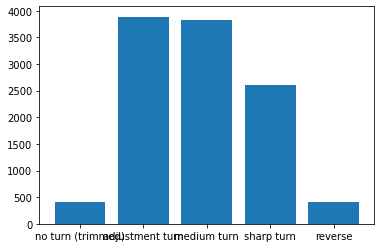

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0562 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


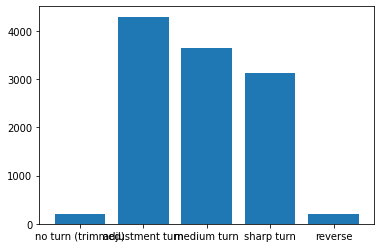

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


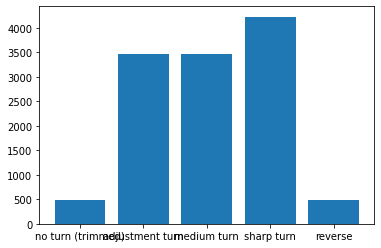

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


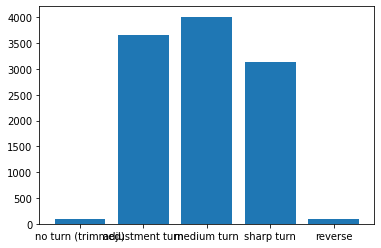

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


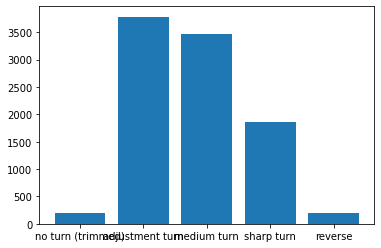

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0474 - accuracy: 0.8272
60
61
62
63
64
65
66
67
68
69


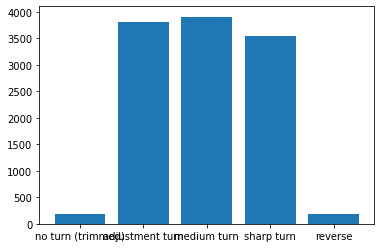

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


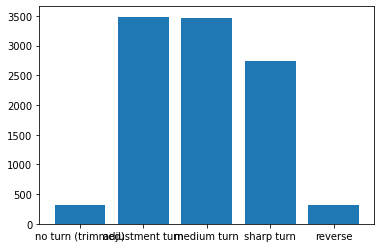

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6537
80
81
82
83
84
85
86
87
88
89


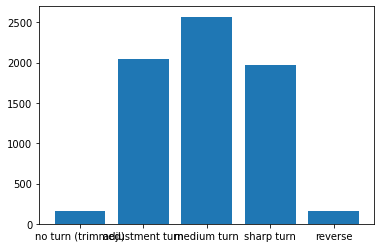

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0626 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


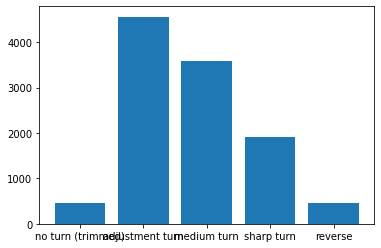

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0583 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


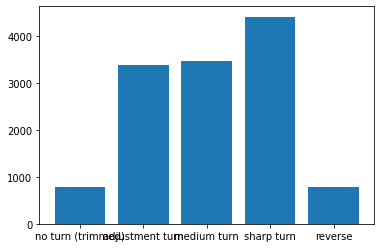

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


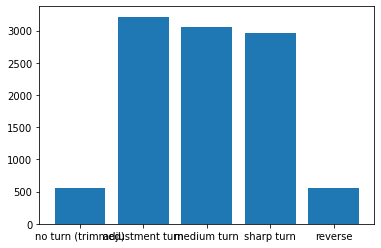

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


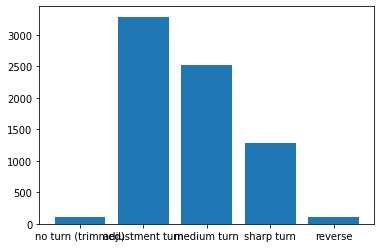

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


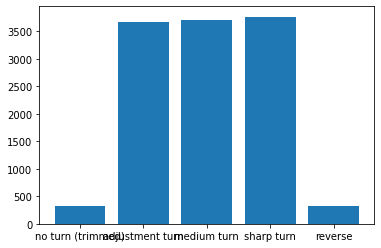

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0636 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
SAVED
-------------STARTING EPOCH 41-------------
0
1
2
3
4
5
6
7
8
9


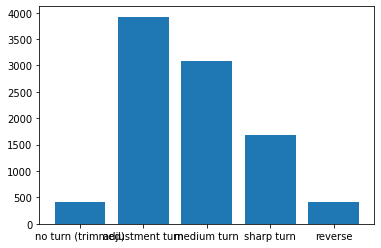

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


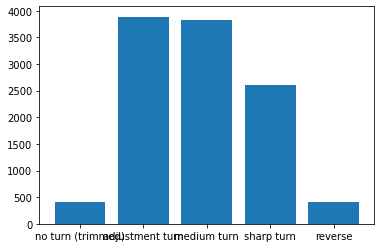

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


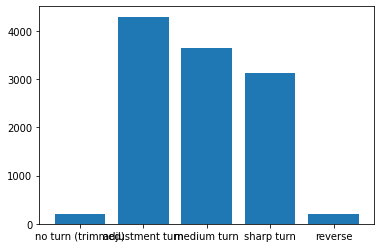

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


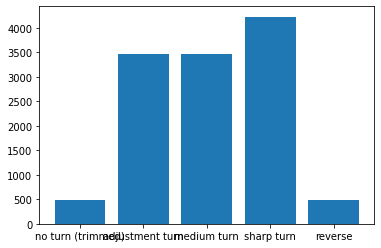

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


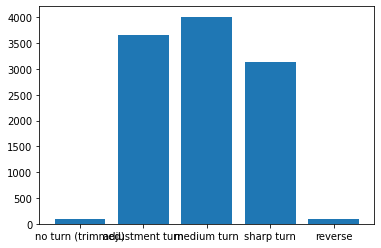

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


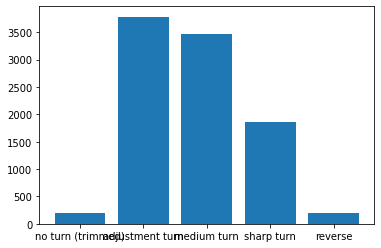

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


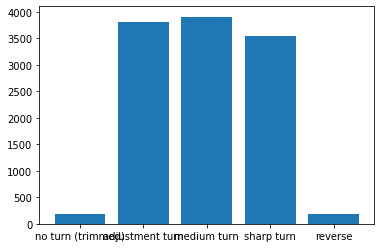

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6795
70
71
72
73
74
75
76
77
78
79


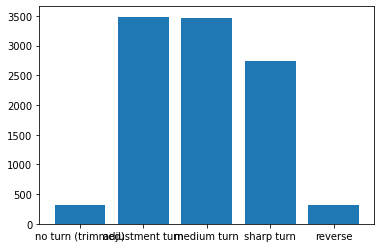

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


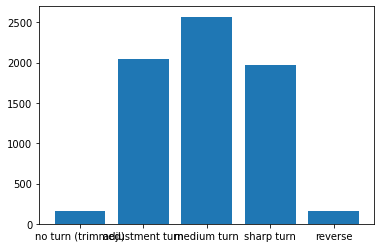

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


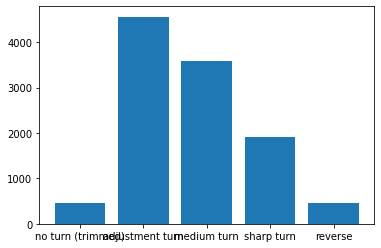

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0581 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


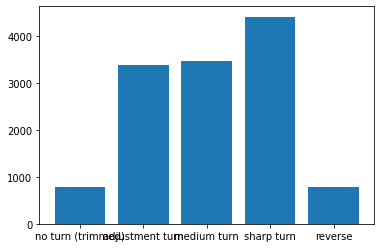

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6243
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


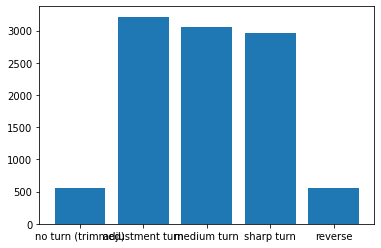

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


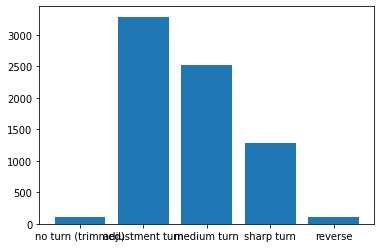

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


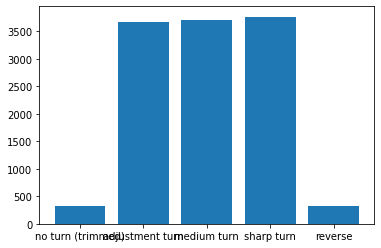

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 42-------------
0
1
2
3
4
5
6
7
8
9


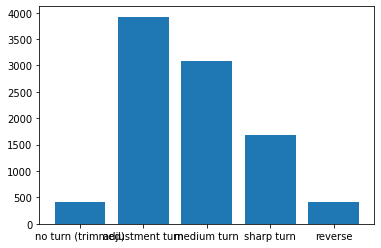

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


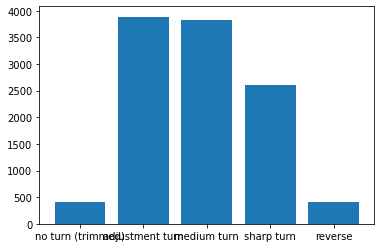

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


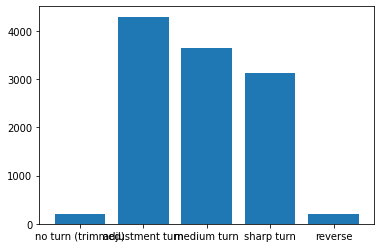

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


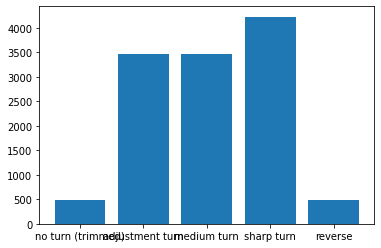

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0662 - accuracy: 0.6009
40
42
43
44
45
46
47
48
49


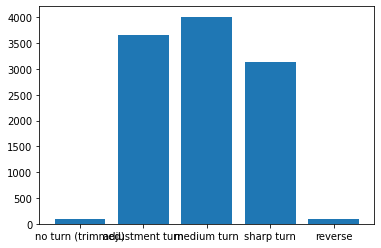

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7360
50
51
52
53
56
57
58
59


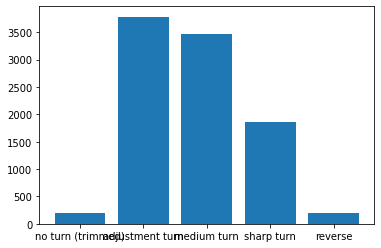

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


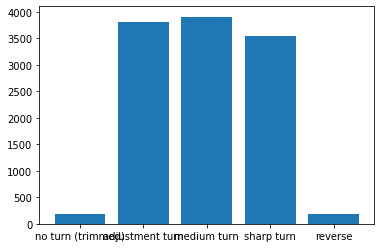

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


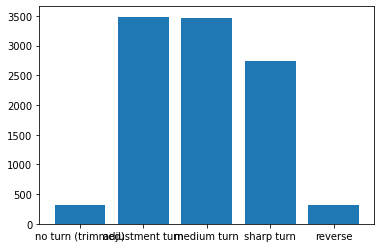

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 12ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


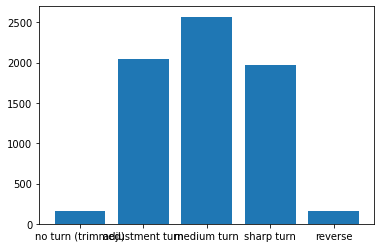

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


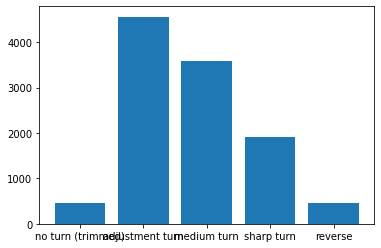

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


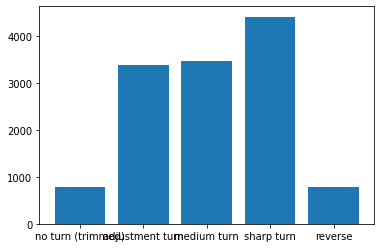

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


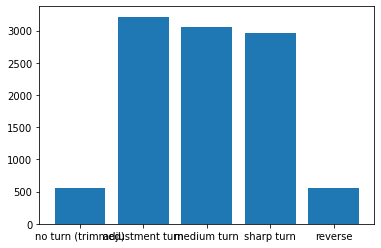

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6759
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


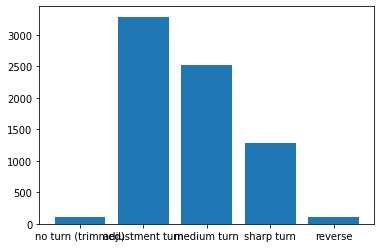

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


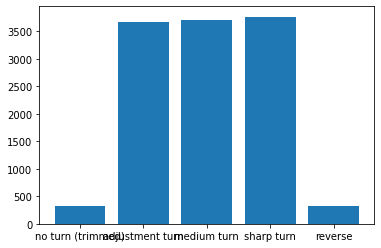

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0639 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 43-------------
0
1
2
3
4
5
6
7
8
9


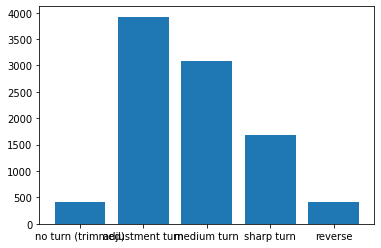

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


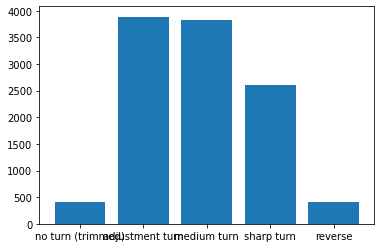

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0562 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


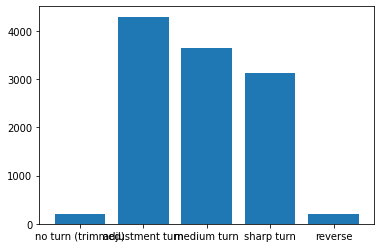

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


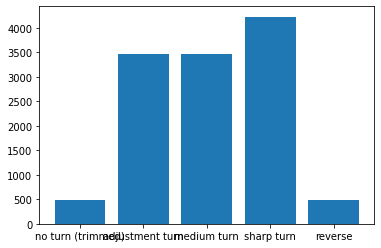

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


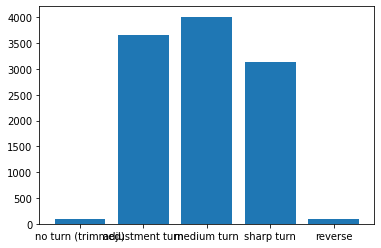

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7358
50
51
52
53
56
57
58
59


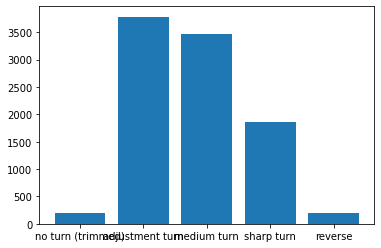

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


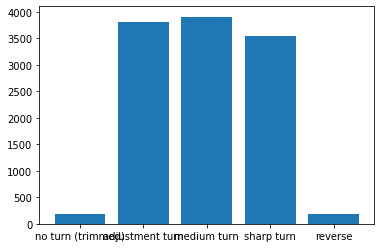

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


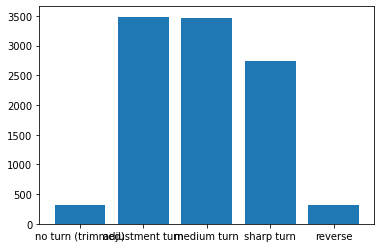

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6540
80
81
82
83
84
85
86
87
88
89


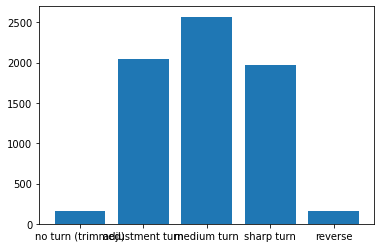

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


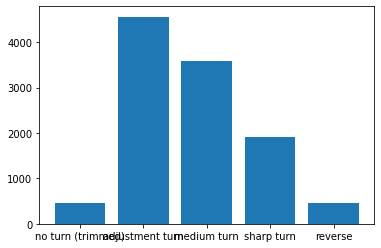

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


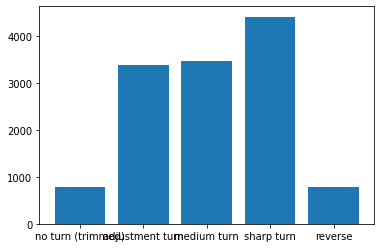

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


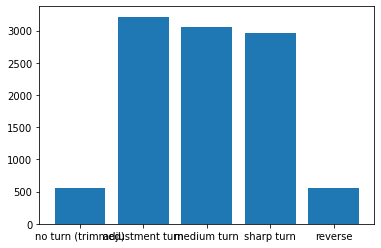

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0695 - accuracy: 0.6757
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


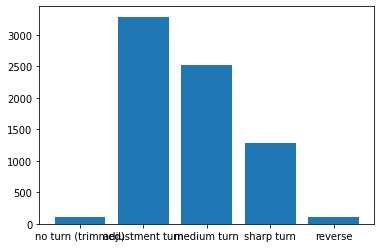

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


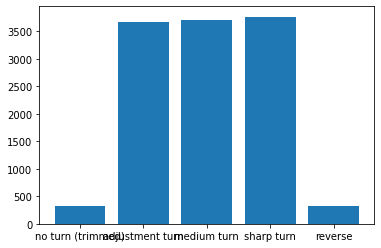

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0639 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 44-------------
0
1
2
3
4
5
6
7
8
9


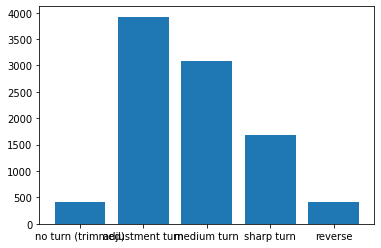

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


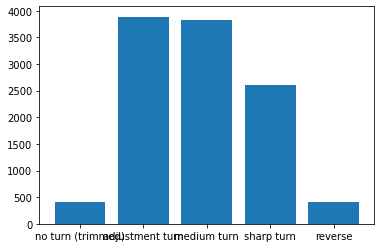

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


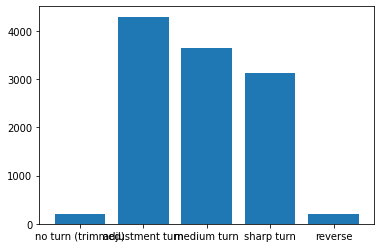

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7547
30
31
32
33
34
35
36
37
38
39


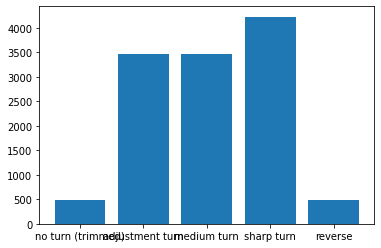

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 11ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


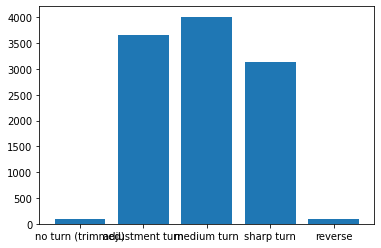

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7360
50
51
52
53
56
57
58
59


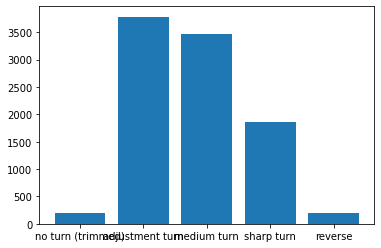

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


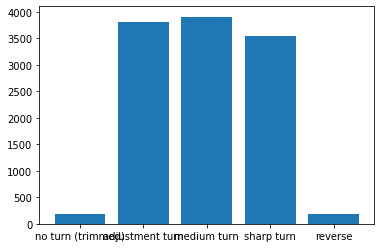

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


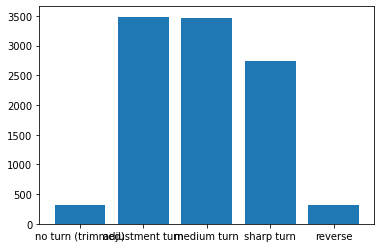

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


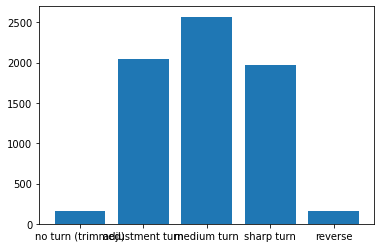

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


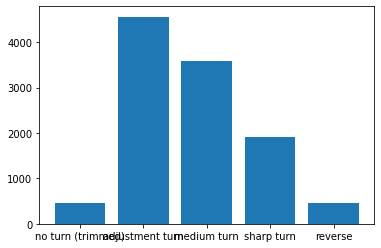

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0581 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


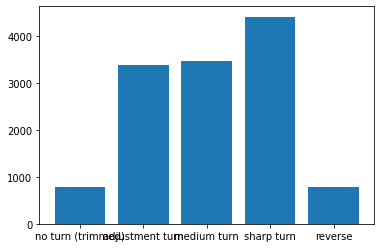

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0782 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


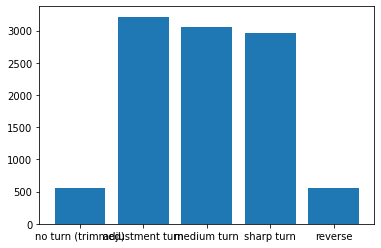

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0695 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


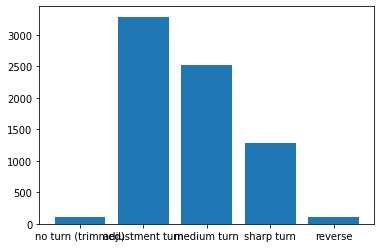

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


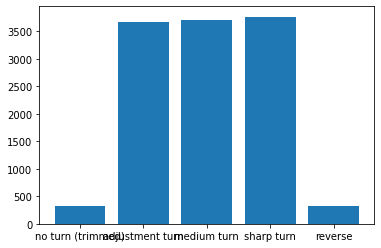

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0638 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 45-------------
0
1
2
3
4
5
6
7
8
9


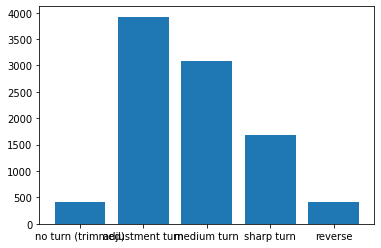

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


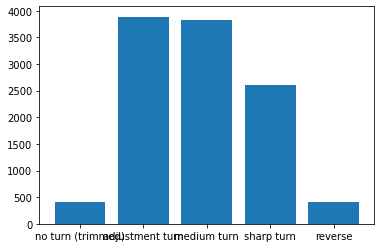

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


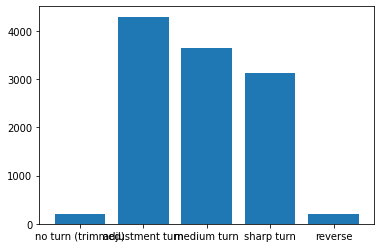

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


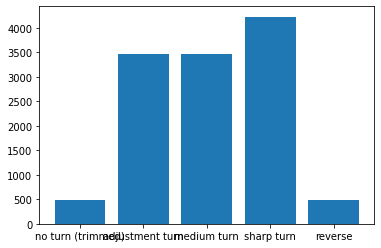

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


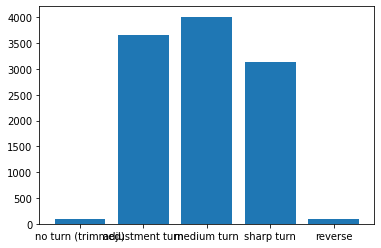

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


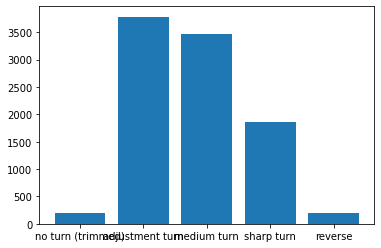

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


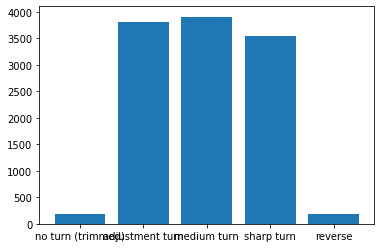

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


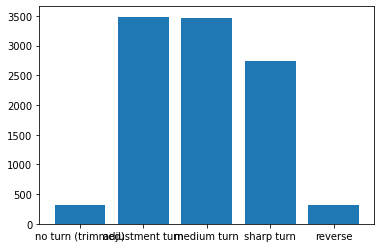

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 10ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


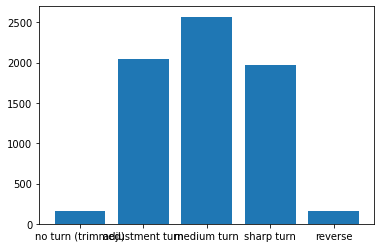

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


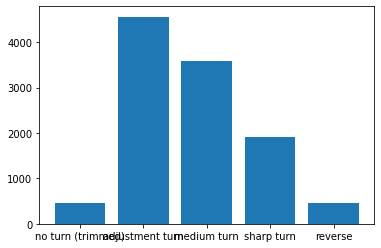

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0581 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


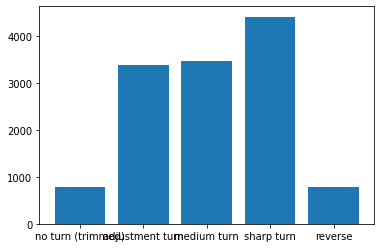

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 5s 11ms/step - loss: 0.0783 - accuracy: 0.6240
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


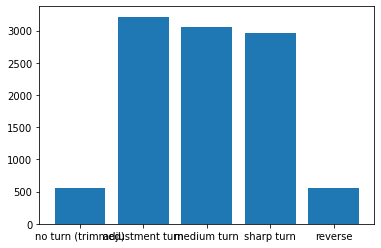

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0695 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


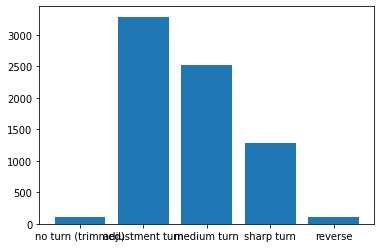

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0451 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


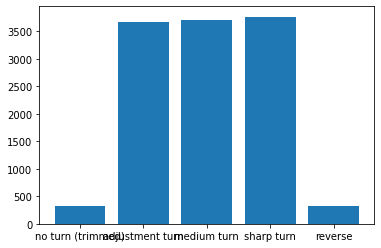

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 46-------------
0
1
2
3
4
5
6
7
8
9


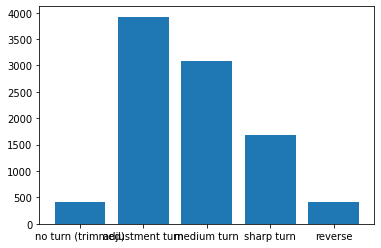

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


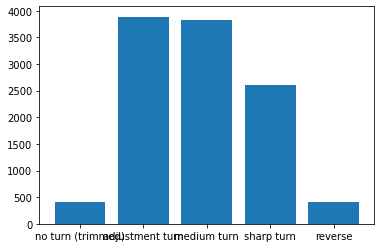

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


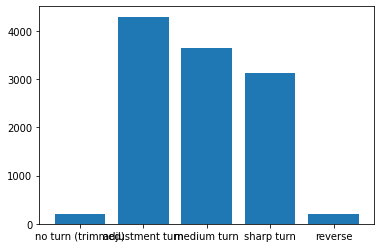

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


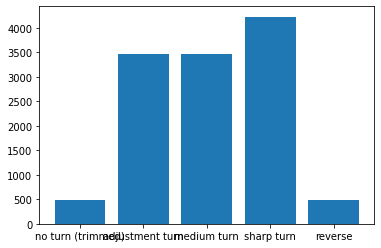

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0661 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


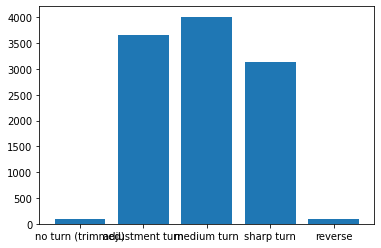

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7359
50
51
52
53
56
57
58
59


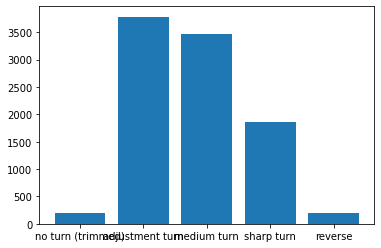

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


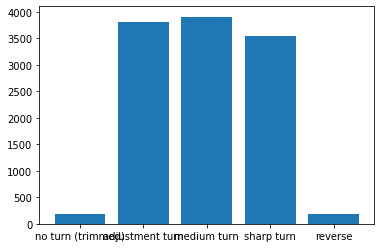

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


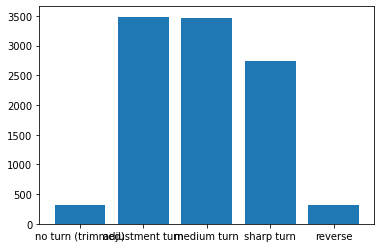

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6539
80
81
82
83
84
85
86
87
88
89


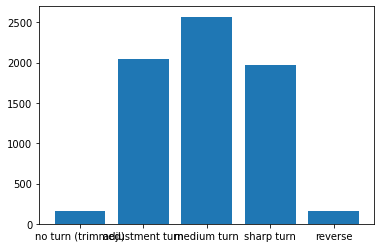

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


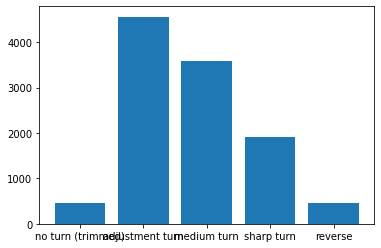

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


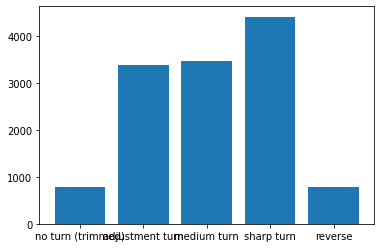

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


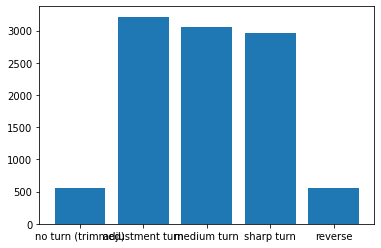

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6755
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


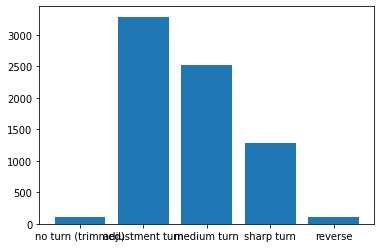

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 10ms/step - loss: 0.0451 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


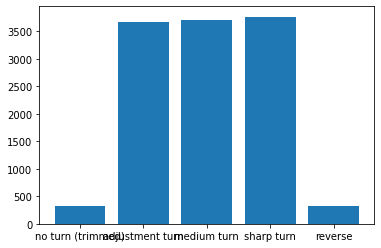

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0637 - accuracy: 0.7180
Test accuracy: 0.7179887294769287
-------------STARTING EPOCH 47-------------
0
1
2
3
4
5
6
7
8
9


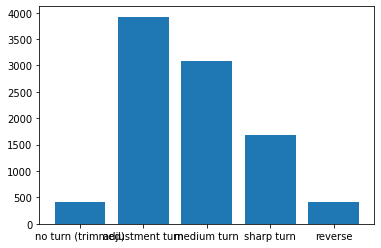

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


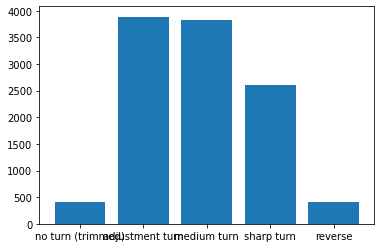

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


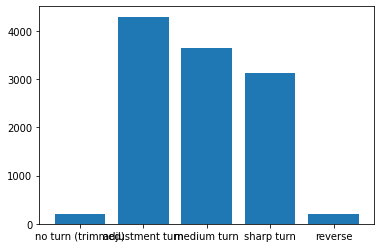

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0509 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


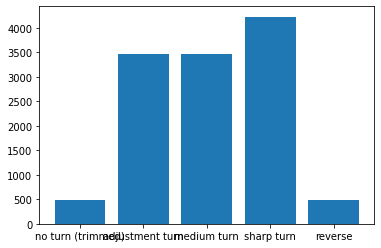

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


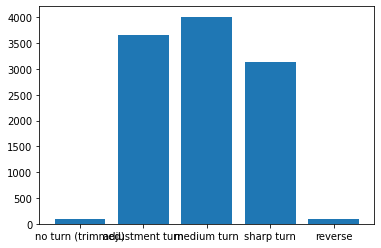

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7358
50
51
52
53
56
57
58
59


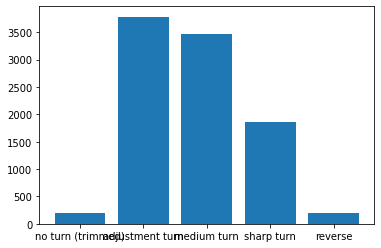

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0474 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


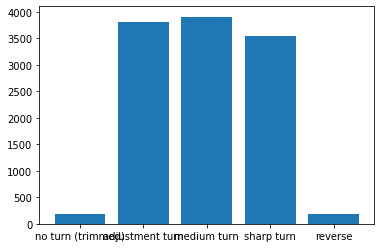

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6794
70
71
72
73
74
75
76
77
78
79


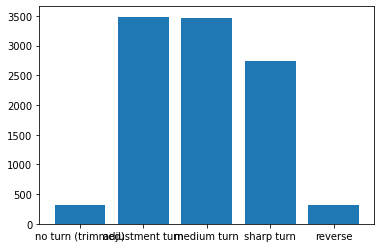

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


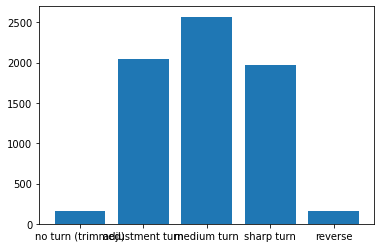

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


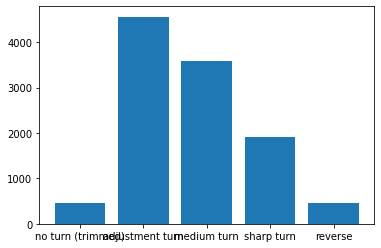

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


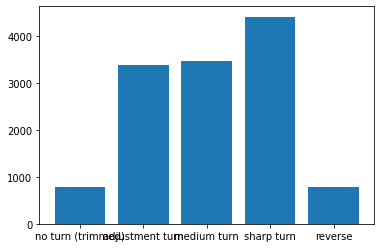

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 5s 11ms/step - loss: 0.0783 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


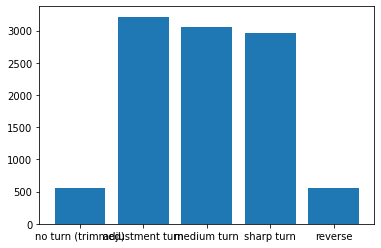

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6758
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


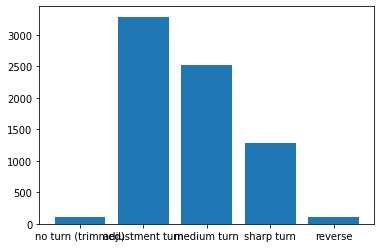

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


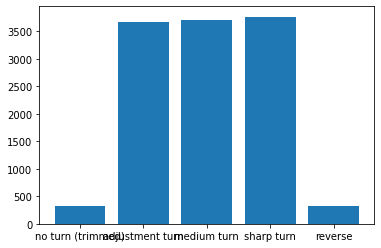

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0638 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 48-------------
0
1
2
3
4
5
6
7
8
9


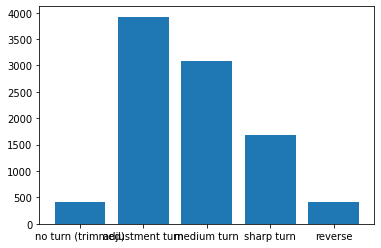

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


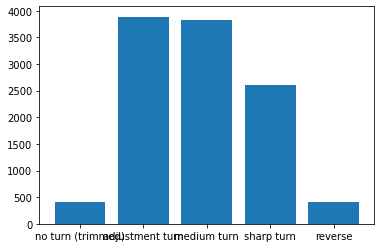

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


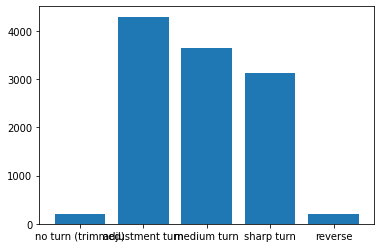

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


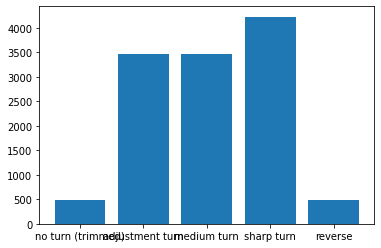

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


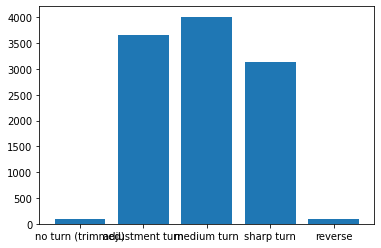

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7358
50
51
52
53
56
57
58
59


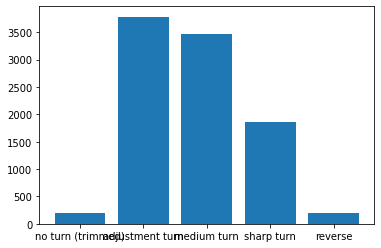

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


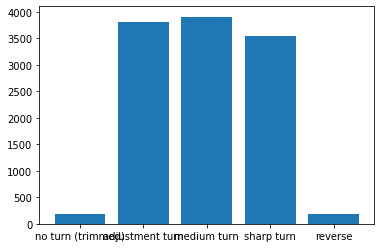

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 10ms/step - loss: 0.0525 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


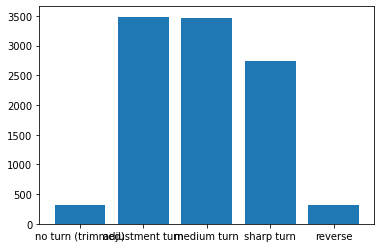

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


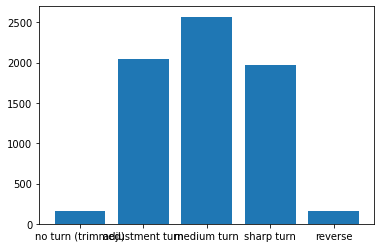

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0626 - accuracy: 0.6974
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


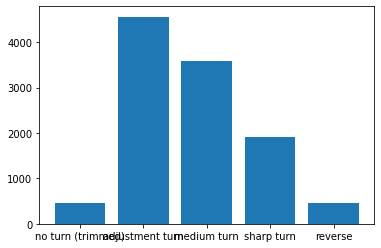

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


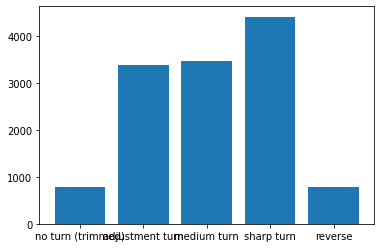

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.6241
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


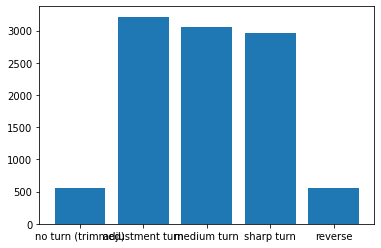

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


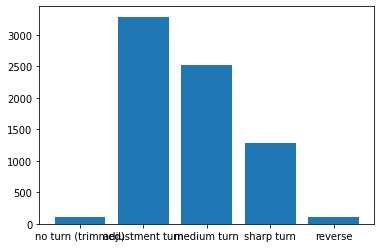

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


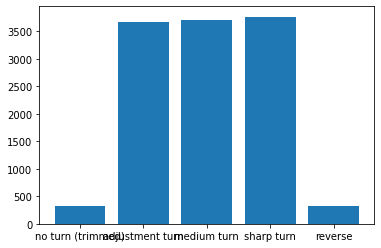

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 2s 7ms/step - loss: 0.0641 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 49-------------
0
1
2
3
4
5
6
7
8
9


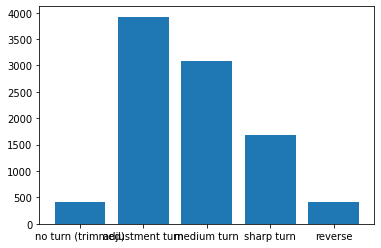

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6444
10
11
12
13
14
15
16
17
18
19


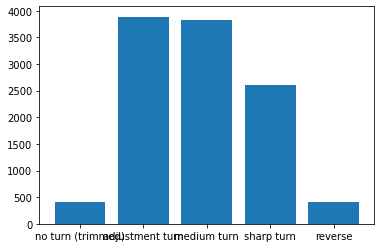

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0560 - accuracy: 0.6874
20
21
22
23
24
25
26
27
28
29


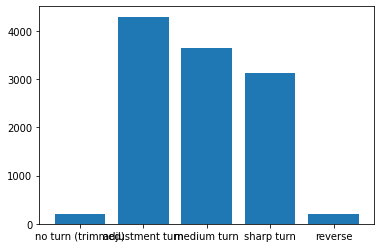

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0508 - accuracy: 0.7549
30
31
32
33
34
35
36
37
38
39


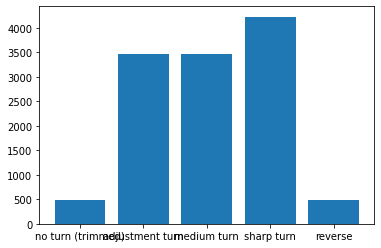

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


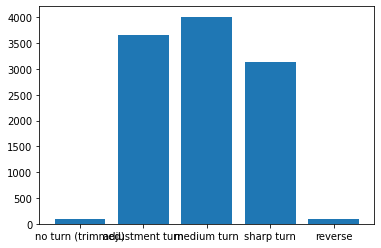

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7359
50
51
52
53
56
57
58
59


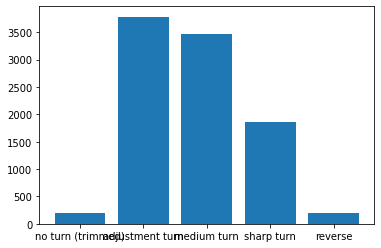

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0472 - accuracy: 0.8270
60
61
62
63
64
65
66
67
68
69


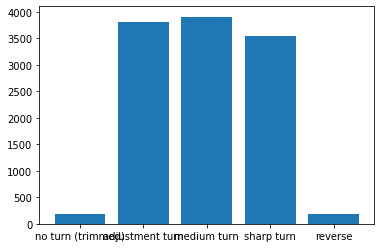

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6796
70
71
72
73
74
75
76
77
78
79


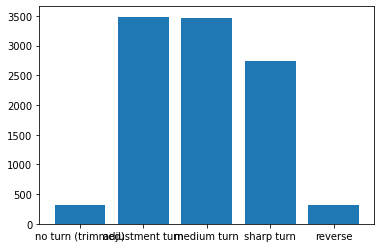

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


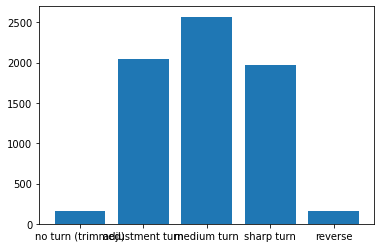

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


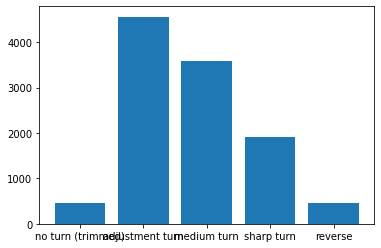

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


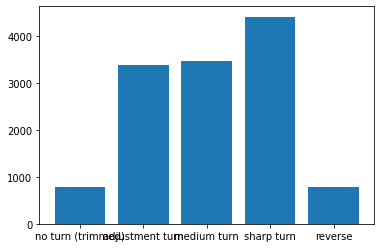

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


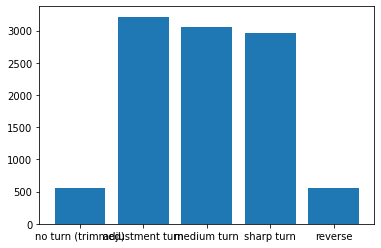

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0694 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


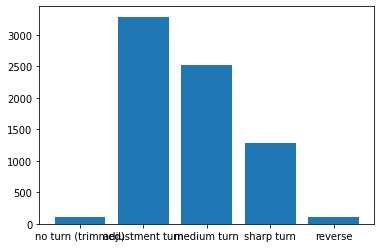

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 2s 11ms/step - loss: 0.0450 - accuracy: 0.7442
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


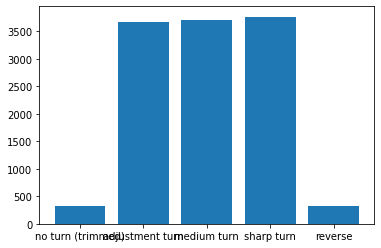

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0637 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 50-------------
0
1
2
3
4
5
6
7
8
9


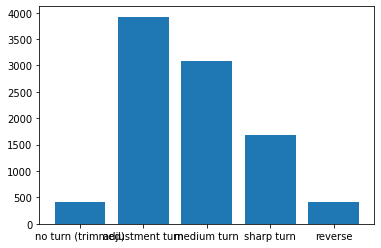

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0502 - accuracy: 0.6443
10
11
12
13
14
15
16
17
18
19


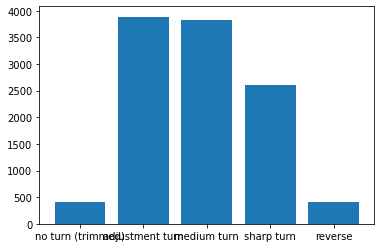

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6873
20
21
22
23
24
25
26
27
28
29


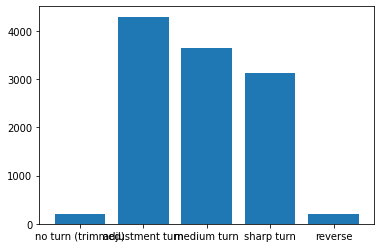

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 10ms/step - loss: 0.0509 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


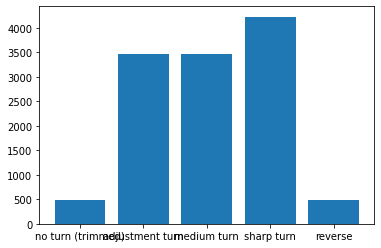

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


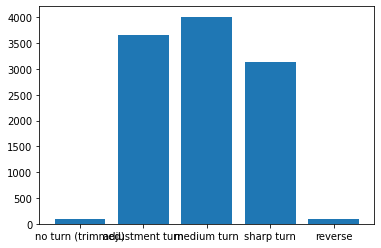

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0510 - accuracy: 0.7359
50
51
52
53
56
57
58
59


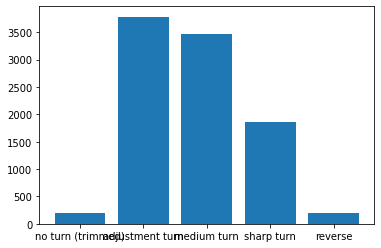

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8271
60
61
62
63
64
65
66
67
68
69


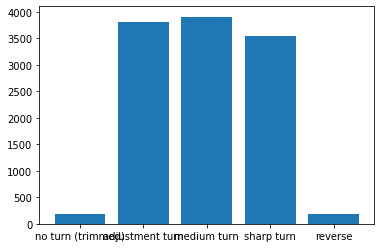

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0524 - accuracy: 0.6795
70
71
72
73
74
75
76
77
78
79


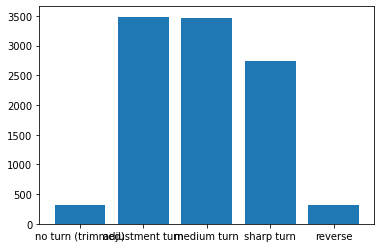

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0602 - accuracy: 0.6538
80
81
82
83
84
85
86
87
88
89


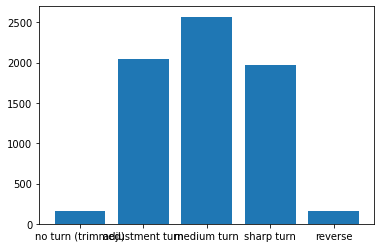

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0625 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


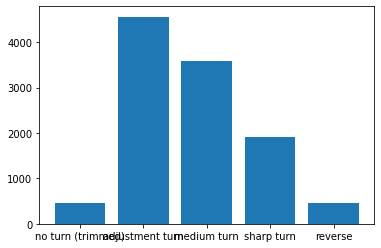

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6882
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


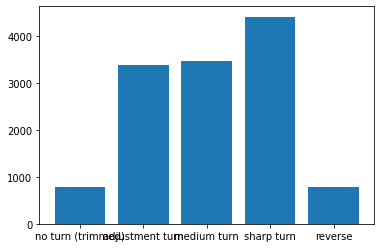

done! have 12878 test cases
(12878, 3)
(12878, 1, 3)
403/403 [==============================] - 4s 11ms/step - loss: 0.0783 - accuracy: 0.6242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


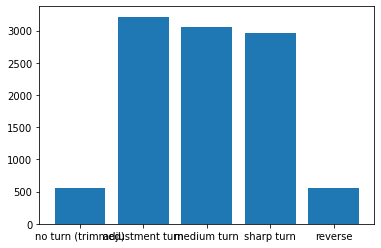

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 3s 11ms/step - loss: 0.0693 - accuracy: 0.6756
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


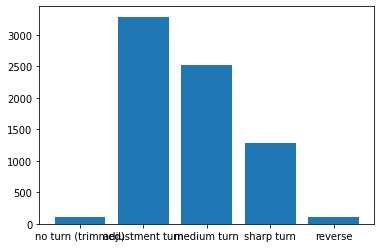

done! have 7320 test cases
(7320, 3)
(7320, 1, 3)
229/229 [==============================] - 3s 11ms/step - loss: 0.0450 - accuracy: 0.7441
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233


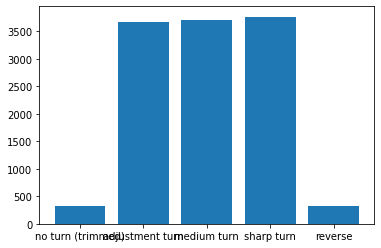

done! have 11778 test cases
(11778, 3)
(11778, 1, 3)
369/369 [==============================] - 3s 7ms/step - loss: 0.0636 - accuracy: 0.7181
Test accuracy: 0.7180683612823486
-------------STARTING EPOCH 51-------------
0
1
2
3
4
5
6
7
8
9


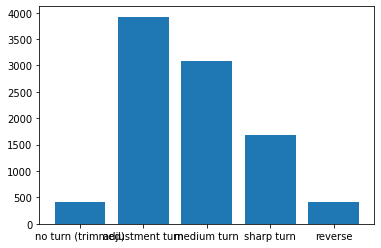

done! have 9516 test cases
(9516, 3)
(9516, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0501 - accuracy: 0.6445
10
11
12
13
14
15
16
17
18
19


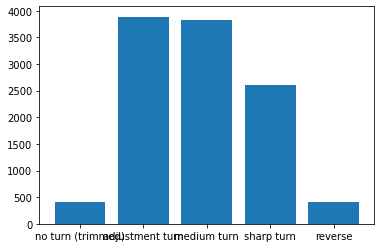

done! have 11126 test cases
(11126, 3)
(11126, 1, 3)
348/348 [==============================] - 4s 11ms/step - loss: 0.0561 - accuracy: 0.6872
20
21
22
23
24
25
26
27
28
29


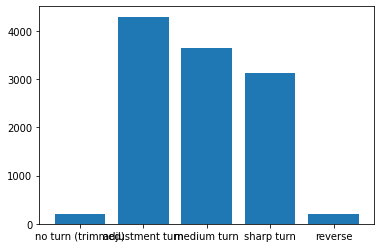

done! have 11478 test cases
(11478, 3)
(11478, 1, 3)
359/359 [==============================] - 4s 11ms/step - loss: 0.0507 - accuracy: 0.7548
30
31
32
33
34
35
36
37
38
39


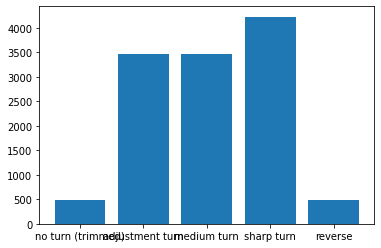

done! have 12128 test cases
(12128, 3)
(12128, 1, 3)
379/379 [==============================] - 4s 10ms/step - loss: 0.0660 - accuracy: 0.6023
40
42
43
44
45
46
47
48
49


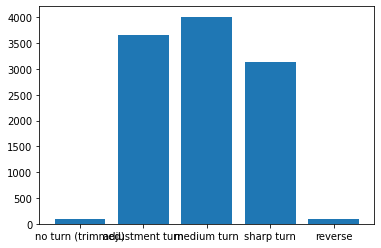

done! have 10992 test cases
(10992, 3)
(10992, 1, 3)
344/344 [==============================] - 4s 11ms/step - loss: 0.0511 - accuracy: 0.7360
50
51
52
53
56
57
58
59


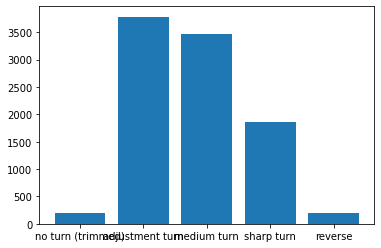

done! have 9514 test cases
(9514, 3)
(9514, 1, 3)
298/298 [==============================] - 3s 11ms/step - loss: 0.0473 - accuracy: 0.8269
60
61
62
63
64
65
66
67
68
69


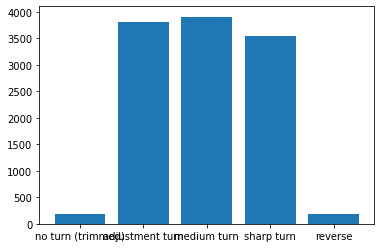

done! have 11622 test cases
(11622, 3)
(11622, 1, 3)
364/364 [==============================] - 4s 11ms/step - loss: 0.0525 - accuracy: 0.6795
70
71
72
73
74
75
76
77
78
79


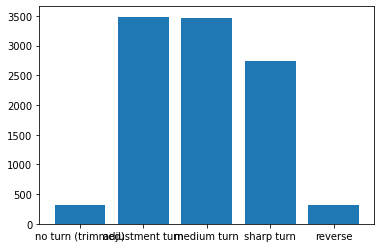

done! have 10342 test cases
(10342, 3)
(10342, 1, 3)
324/324 [==============================] - 4s 11ms/step - loss: 0.0603 - accuracy: 0.6540
80
81
82
83
84
85
86
87
88
89


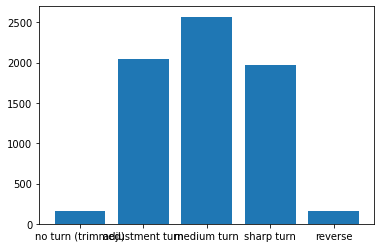

done! have 6906 test cases
(6906, 3)
(6906, 1, 3)
216/216 [==============================] - 2s 11ms/step - loss: 0.0626 - accuracy: 0.6973
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


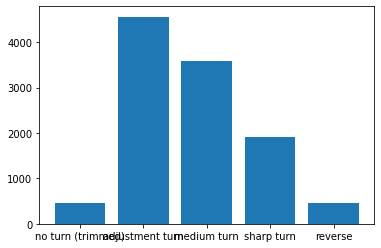

done! have 10970 test cases
(10970, 3)
(10970, 1, 3)
343/343 [==============================] - 4s 11ms/step - loss: 0.0582 - accuracy: 0.6883
120
121
122
123
124
125
126
127
128


In [ ]:

"""
import mxnet as mx
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
"""

#set up alexnet


def build_alexnet_model():
  #image_shape = (80,60,1)
  np.random.seed(1000)
  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
  model = tf.keras.Sequential([
    #tf.keras.layers.InputLayer(input_shape=image_shape),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5),strides=(2,2),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation=tf.nn.relu), 
    #tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.linear)])
  
  return model

def build_alexnet_batchnorm_model():
  model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),#, input_shape=(120, 160, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='relu')
  ])

  return model

def nvidia_modified():
  model = Sequential()

  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2),activation='elu'))

  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))

  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))

  #5th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))


  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))

  #3rd Dense Layer
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))

  #output
  model.add(Dense(3))
  
  #Compile model
  #model.compile(tf.keras.optimizers.Adam(lr=0.001), loss = 'mse', metrics = ['accuracy'])
  return model



def build_cnn_model():
      cnn_model = tf.keras.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 2 to reduce the height and width of
        # the output.
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=2),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(axis=3),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        #tf.keras.layers.BatchNormalization(axis=-1),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Because control vector is made up of 3 values, 
        # this dense layer is made up of only 3 units
        tf.keras.layers.Dense(3)])
      
      return cnn_model


#x = np.random.rand(2,160,120,1)
#X = tf.convert_to_tensor(x)

# Initialize the model by passing some data through
#predictions = cnn_model.predict(X_train_0)
#print(predictions)
#print(predictions.shape)
# Print the summary of the layers in the model.
#print(cnn_model.summary())

#load cnn model, load arrays
time_vals = []
train_accuracy = []
test_accuracy = []

epoch_to_load = int(input("which epoch to load?"))
if epoch_to_load > 0:
  cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/GTA Driving Data/training weights/gta_cnn_model_epoch_{}.h5'.format(epoch_to_load))
  graph_data = np.load('/content/drive/MyDrive/GTA Driving Data/progress data/graph_data.npy',allow_pickle=True)
  time_vals = graph_data[0][0:epoch_to_load].tolist()
  train_accuracy = graph_data[1][0:epoch_to_load].tolist()
  test_accuracy = graph_data[2][0:epoch_to_load].tolist()
  print(type(time_vals))
  print(time_vals)

else:
  cnn_model = nvidia_modified()
  cnn_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['accuracy'])
  #cnn_model = build_alexnet_batchnorm_model() 


BATCH_SIZE = 32
EPOCHS = 150

files_in_epoch = 0
accuracy_store = 0
start_val = 0
num_files_to_retrieve = 10
num_files_to_test = 200
for epoch in range(epoch_to_load+1,EPOCHS+1):
  print('----- --------STARTING EPOCH {}-------------'.format(epoch))
  files_in_epoch = 0
  accuracy_store = 0
  while start_val < num_files_to_test-num_files_to_retrieve*3:
    if(start_val < 83):
      X_train, Y_train = data_processing(start_val,num_files_to_retrieve)
      #print("len {}".format(len(X_train)))
      start_val += num_files_to_retrieve
    else:
      X_train, Y_train = data_processing(start_val,num_files_to_retrieve*3)
      start_val += num_files_to_retrieve*3
    
    num_files = X_train.shape[0]
    files_in_epoch += num_files

    history = cnn_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=1)#,callbacks=[cp_callback])
    #weights accuracy by number of files it is measured over
    group_accuracy = num_files*history.history['accuracy'][0]
    accuracy_store += group_accuracy  

  #train on tail end of dataset
  X_train, Y_train = data_processing(start_val,num_files_to_test-start_val+1)

  num_files = X_train.shape[0]
  files_in_epoch += num_files

  history = cnn_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=1)#,callbacks=[cp_callback])
  
  group_accuracy = num_files*history.history['accuracy'][0]
  accuracy_store += group_accuracy

  #appends average epoch accuracy
  train_accuracy.append(accuracy_store/(files_in_epoch))
  time_vals.append(epoch)

  X_test, Y_test = data_processing(201,33)
  test_loss, test_acc = cnn_model.evaluate(X_test,Y_test)
  print('Test accuracy:', test_acc)
  test_accuracy.append(test_acc)

  #saving model
  if epoch % 20 == 0:
    #if epoch % 5 == 0 and epoch != 10:
    print("SAVED")
    file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/gta_cnn_model_epoch_{}.h5".format(epoch)
    cnn_model.save(file_name)
    graph_data = [time_vals,train_accuracy,test_accuracy]
    np.save('/content/drive/MyDrive/GTA Driving Data/progress data/graph_data.npy',graph_data)
  
  start_val = 0

plt.plot(time_vals, test_accuracy, label = "test accuracy")
plt.plot(time_vals, train_accuracy, label = "train accuracy")
plt.show()

In [21]:
file_name = "/content/drive/MyDrive/GTA Driving Data/training weights/gta_cnn_model_epoch_{}.h5".format(10)
cnn_model.save(file_name)
graph_data = [time_vals,train_accuracy,test_accuracy]
np.save('/content/drive/MyDrive/GTA Driving Data/progress data/graph_data.npy',graph_data)

In [22]:
"""
#defining lstm model
#rnn is later
def build_LSTM_model():#vocab_size, embedding_dim, rnn_units, batch_size):
  model = keras.Sequential(
      [
       layers.ConvLSTM2D(
           filters=40,kernel_size=(3,3),padding='same',return_sequences=True
       ),
       layers.BatchNormalization(),
       layers.ConvLSTM2D(
           filters=40,kernel_size=(3,3),padding='same',return_sequences=True
       ),
       layers.BatchNormalization()
       ])
  model.compile(loss=keras.losses.MeanSquaredError(),optimizer='adam',metrics=["accuracy"])
  return model

x = np.random.rand(1600,120,160,1)
X = tf.convert_to_tensor(x)
print(X.shape[0])


rnn_model = build_LSTM_model()
# Initialize the model by passing some data through
predictions = rnn_model.predict(X)

#print(predictions)
# Print the summary of the layers in the model.
print(rnn_model.summary())



    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
  ])
"""

  #return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
#model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

'\n#defining lstm model\n#rnn is later\ndef build_LSTM_model():#vocab_size, embedding_dim, rnn_units, batch_size):\n  model = keras.Sequential(\n      [\n       layers.ConvLSTM2D(\n           filters=40,kernel_size=(3,3),padding=\'same\',return_sequences=True\n       ),\n       layers.BatchNormalization(),\n       layers.ConvLSTM2D(\n           filters=40,kernel_size=(3,3),padding=\'same\',return_sequences=True\n       ),\n       layers.BatchNormalization()\n       ])\n  model.compile(loss=keras.losses.MeanSquaredError(),optimizer=\'adam\',metrics=["accuracy"])\n  return model\n\nx = np.random.rand(1600,120,160,1)\nX = tf.convert_to_tensor(x)\nprint(X.shape[0])\n\n\nrnn_model = build_LSTM_model()\n# Initialize the model by passing some data through\npredictions = rnn_model.predict(X)\n\n#print(predictions)\n# Print the summary of the layers in the model.\nprint(rnn_model.summary())\n\n\n\n    # Layer 1: Embedding layer to transform indices into dense vectors \n    #   of a fixed embedd

In [23]:
#figure out batches w/ input data, set that up, break them down into 100 frames

In [24]:
"""
# saving and loading the model weights
 
# save model
model.save_weights('gfgModelWeights')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('gfgModelWeights')
print('Model Loaded!')
"""

"\n# saving and loading the model weights\n \n# save model\nmodel.save_weights('gfgModelWeights')\nprint('Model Saved!')\n \n# load model\nsavedModel = model.load_weights('gfgModelWeights')\nprint('Model Loaded!')\n"

In [25]:
"""import cv2
import time
from keyboard import is_pressed  # using module keyboard
import os
from PIL import Image
import numpy as np
from grabscreen import grab_screen
from skimage.color import rgb2gray
import IPython.display as display

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

import vgamepad as vg

def start(model_file_name):
    gamepad = vg.VX360Gamepad()
    cnn_model = tf.load_model(model_file_name)
    print(cnn_model.summary)
    #time_end = time_start + 10
    avg_fps = []
    time1 = time.time()
    bool_val = True
    i = 0
    paused = False
    data_array = []
    counter = 0
    while True:
        if not paused:
            screen = grab_screen(region=(0,0,1270,720))
            
            #plt.imshow(screen)
            #plt.show()
            screen = cv2.resize(screen, (160,120))
            
            gray_tensor = tf.convert_to_tensor(rgb2gray(screen))
            
            input_data_shape = list(gray_tensor.shape) + [1]
            
            gray_tensor_reshaped = tf.reshape(gray_tensor,input_data_shape)
            
            control_vector = cnn_model.predict(gray_tensor_reshaped)

            lt = control_vector[0]
            rt = control_vector[1]
            ls = control_vector[2]

            #modifying controls for vgamepad
            ls = (ls - 0.5)*2
            gamepad.left_trigger_float(lt)
            gamepad.right_trigger_float(rt)
            gamepad.left_joystick_float(x_value_float=ls)
            gamepad.update()

            time.sleep(0.0001)

        if is_pressed('p'):
            if paused:
                paused = False
                print('unpaused!')
                time.sleep(1)
            else:
                print('Pausing!')
                paused = True
                time.sleep(1)
if __name__ == "__main__":
    print("press q to start")
    while True:
        if is_pressed('q'):
            break
    print("STARTING")
    start()

"""

'import cv2\nimport time\nfrom keyboard import is_pressed  # using module keyboard\nimport os\nfrom PIL import Image\nimport numpy as np\nfrom grabscreen import grab_screen\nfrom skimage.color import rgb2gray\nimport IPython.display as display\n\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom keras import layers\nfrom keras import Sequential\nfrom keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D\nfrom keras.layers.normalization import BatchNormalization\n\nimport vgamepad as vg\n\ndef start(model_file_name):\n    gamepad = vg.VX360Gamepad()\n    cnn_model = tf.load_model(model_file_name)\n    print(cnn_model.summary)\n    #time_end = time_start + 10\n    avg_fps = []\n    time1 = time.time()\n    bool_val = True\n    i = 0\n    paused = False\n    data_array = []\n    counter = 0\n    while True:\n        if not paused:\n            screen = grab_screen(region=(0,0,1270,720))\n            \n            #plt.imshow(screen)\n            #plt.show()\n 

In [26]:
"""
colab macro kkklllkksdsdsdsssdsdsaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssscsdsdsdsdsddddsssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaap
"""

'\ncolab macro kkklllkksdsdsdsssdsdsaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssscsdsdsdsdsddddsssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaasaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaassssssssssssssssssssssssssssssssssssdddddddddddddddddddddddddddddddddddddddddddddddddddddddaaaaaaaa